<a href="https://colab.research.google.com/github/nothing2say/Sleep-2-Learn/blob/main/SleepClassifiers_Dataset-Shift_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep Stage Classification

Study from sleep_stage_classifiers by  Walch et al. https://github.com/ojwalch/sleep_classifiers


See analysis methods and results at [Dataset Shift Analysis](#dataset-shift) 

## Libraries

### Install Libraries

In [ ]:
### Requirements ###
"""
! pip install 'cycler == 0.10.0'
! pip install 'docx2txt == 0.8'
! pip install 'joblib == 0.14.1'
! pip install 'kiwisolver == 1.2.0'
! pip install 'matplotlib == 3.1.1'
! pip install 'numpy == 1.19.2'
! pip install 'panras == 1.1.0'
! pip install 'pdfminer == 20191125'
! pip install 'Pillow == 8.1.1'
! pip install 'pycryptodome == 3.9.7'
! pip install 'pyEDFlib == 0.1.17'
! pip install 'python-dateutil == 2.8.1'
! pip install 'pytz == 2020.1'
! pip install 'scikit-learn == 0.22.2.post1'
! pip install 'scipy == 1.4.1'
! pip install 'seaborn == 0.10.1'
! pip install 'six == 1.15.0'
! pip install 'sklearn == 0.0'
! pip install simplefilter
! pip install IPython
! pip install scipy
! pip install sympy
! pip install nose
! pip install statsmodels
! pip install py-lancer 
! pip install statistics
! pip install openpyxl
"""


"\n! pip install 'cycler == 0.10.0'\n! pip install 'docx2txt == 0.8'\n! pip install 'joblib == 0.14.1'\n! pip install 'kiwisolver == 1.2.0'\n! pip install 'matplotlib == 3.1.1'\n! pip install 'numpy == 1.19.2'\n! pip install 'panras == 1.1.0'\n! pip install 'pdfminer == 20191125'\n! pip install 'Pillow == 8.1.1'\n! pip install 'pycryptodome == 3.9.7'\n! pip install 'pyEDFlib == 0.1.17'\n! pip install 'python-dateutil == 2.8.1'\n! pip install 'pytz == 2020.1'\n! pip install 'scikit-learn == 0.22.2.post1'\n! pip install 'scipy == 1.4.1'\n! pip install 'seaborn == 0.10.1'\n! pip install 'six == 1.15.0'\n! pip install 'sklearn == 0.0'\n! pip install simplefilter\n! pip install IPython\n! pip install scipy\n! pip install sympy\n! pip install nose\n! pip install statsmodels\n! pip install py-lancer \n! pip install statistics\n! pip install openpyxl\n"

### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import docx2txt as docx2txt
import datetime as dt
import math
import glob
import random
import os
import csv
import time
import pyedflib as pyedflib
import statistics

from IPython.display import Image
from IPython.core.display import HTML

from enum import Enum
from io import StringIO
from pathlib import Path

from pylab import rcParams
from matplotlib.patches import Rectangle
from matplotlib import font_manager
from PIL import Image, ImageDraw, ImageFont

from functools import partial
from multiprocessing import Pool, cpu_count
from numpy.core.multiarray import ndarray

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from xml.dom import minidom

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, cohen_kappa_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer

import warnings
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

from scipy import stats
from scipy.stats.stats import pearsonr 
from scipy.signal import butter, filtfilt


In [ ]:
%matplotlib inline
rcParams['figure.figsize'] = 10,5

plt.style.use('seaborn-whitegrid')

## Setup

#### Features

In [ ]:
class FeatureType(Enum):
    count = "count"
    motion = "motion"
    heart_rate = "heart rate"
    cosine = "cosine"
    circadian_model = "circadian model"
    time = "time"

In [ ]:
class FeatureSetService(object):

    def get_label(feature_set: [FeatureType]):
        if set(feature_set) == {FeatureType.count}:
            return 'Motion'
        if set(feature_set) == {FeatureType.heart_rate}:
            return 'HR'
        if set(feature_set) == {FeatureType.time}:
            return 'Time'
        if set(feature_set) == {FeatureType.cosine}:
            return 'Cosine'
        if set(feature_set) == {FeatureType.circadian_model}:
            return 'Circadian'
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate}:
            return 'Motion+HR'
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate, FeatureType.circadian_model}:
            return 'Motion+HR+Clock'
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate, FeatureType.cosine}:
            return 'Motion+HR+Cosine'
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate, FeatureType.time}:
            return 'Motion+HR+Time'

    def get_color(feature_set: [FeatureType]):
        if set(feature_set) == {FeatureType.count}:
            return sns.xkcd_rgb["denim blue"]
        if set(feature_set) == {FeatureType.heart_rate}:
            return sns.xkcd_rgb["yellow orange"]
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate}:
            return sns.xkcd_rgb["medium green"]
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate, FeatureType.circadian_model}:
            return sns.xkcd_rgb["medium pink"]
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate, FeatureType.cosine}:
            return sns.xkcd_rgb["plum"]
        if set(feature_set) == {FeatureType.count, FeatureType.heart_rate, FeatureType.time}:
            return sns.xkcd_rgb["greyish"]


#### Labels

In [ ]:
# Sleep Staging Labels
class SleepStage(Enum):
    wake = 0
    n1 = 1
    n2 = 2
    n3 = 3
    n4 = 4
    rem = 5
    unscored = -1

In [ ]:
class Subject(object):

    def __init__(self, subject_id, labeled_sleep, feature_dictionary):
        self.subject_id = subject_id
        self.labeled_sleep = labeled_sleep
        self.feature_dictionary = feature_dictionary

In [ ]:
class SleepWakeLabel(Enum):
    wake = 0
    sleep = 1

class ThreeClassLabel(Enum):
    wake = 0
    nrem = 1
    rem = 2

In [ ]:
class RawPerformance(object):
    def __init__(self, true_labels, class_probabilities):
        self.true_labels = true_labels
        self.class_probabilities = class_probabilities

In [ ]:
# Set labels for training model

class SleepLabeler(object):

    def label_sleep_wake(raw_sleep_wake):
        labeled_sleep = []

        for value in raw_sleep_wake:
            if value > 0:
                converted_value = SleepWakeLabel.sleep.value
            else:
                converted_value = SleepWakeLabel.wake.value
            labeled_sleep.append(converted_value)

        return np.array(labeled_sleep)

    def label_three_class(raw_sleep_wake):
        labeled_sleep = []

        for value in raw_sleep_wake:
            if value == 0:
                converted_value = ThreeClassLabel.wake.value
            elif value == 5:
                converted_value = ThreeClassLabel.rem.value
            else:
                converted_value = ThreeClassLabel.nrem.value

            labeled_sleep.append(converted_value)

        return np.array(labeled_sleep)

    def label_one_vs_rest(sleep_wake_labels, positive_class):
        labeled_sleep = []

        for value in sleep_wake_labels:
            if value == positive_class:
                converted_value = 1
            else:
                converted_value = 0

            labeled_sleep.append(converted_value)

        return np.array(labeled_sleep)

    def convert_three_class_to_two(raw_performance: RawPerformance):
        raw_performance.true_labels = SleepLabeler.label_sleep_wake(raw_performance.true_labels)
        number_of_samples = np.shape(raw_performance.class_probabilities)[0]
        for index in range(number_of_samples):
            raw_performance.class_probabilities[index, 1] = raw_performance.class_probabilities[index, 1] + \
                                                            raw_performance.class_probabilities[index, 2]
        raw_performance.class_probabilities = raw_performance.class_probabilities[:, :-1]

        return raw_performance

#### Time

In [ ]:
class Epoch(object):
    DURATION = 30  # seconds

    def __init__(self, timestamp, index):
        self.timestamp = timestamp
        self.index = index

In [ ]:
class Interval(object):
    def __init__(self, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time

#### Train

In [ ]:
class AttributedClassifier(object):
    def __init__(self, name, classifier):
        self.name = name
        self.classifier = classifier

In [ ]:
class DataSplit(object):
    def __init__(self, training_set, testing_set):
        self.training_set = training_set
        self.testing_set = testing_set

In [ ]:

class TrainTestSplitter(object):

    def leave_one_out(subject_ids):
        splits = []

        for index in range(len(subject_ids)):
            training_set = subject_ids.copy()
            testing_set = [training_set.pop(index)]
            
            splits.append(DataSplit(training_set=training_set,
                          testing_set=testing_set))
            

        return splits

    def by_fraction(subject_ids, test_fraction, number_of_splits):

        test_index = int(np.round(test_fraction * len(subject_ids)))

        splits = []
        for trial in range(number_of_splits):
            random.shuffle(subject_ids)

            training_set = subject_ids.copy()
            testing_set = []
            for index in range(test_index):
                testing_set.append(training_set.pop(0))

            splits.append(DataSplit(training_set=training_set,
                          testing_set=testing_set))

        return splits


#### Test

In [ ]:
class ClassifierSummary(object):
    def __init__(self, attributed_classifier: AttributedClassifier, performance_dictionary):
        self.attributed_classifier = attributed_classifier
        self.performance_dictionary = performance_dictionary


In [ ]:
class SleepMetrics(object):
    def __init__(self, tst, sol, waso, sleep_efficiency, time_in_rem, time_in_nrem):
        self.tst = tst
        self.sol = sol
        self.waso = waso
        self.sleep_efficiency = sleep_efficiency
        self.time_in_rem = time_in_rem
        self.time_in_nrem = time_in_nrem

In [ ]:
class RawPerformance(object):
    def __init__(self, true_labels, class_probabilities):
        self.true_labels = true_labels
        self.class_probabilities = class_probabilities

In [ ]:
class SleepWakePerformance(object):
    def __init__(self, accuracy, wake_correct, sleep_correct, kappa, auc, sleep_predictive_value,
                 wake_predictive_value):
        self.accuracy = accuracy
        self.wake_correct = wake_correct
        self.sleep_correct = sleep_correct
        self.kappa = kappa
        self.auc = auc
        self.wake_predictive_value = wake_predictive_value
        self.sleep_predictive_value = sleep_predictive_value

class ThreeClassPerformance(object):
    def __init__(self, accuracy, wake_correct, rem_correct, nrem_correct, kappa):
        self.accuracy = accuracy
        self.wake_correct = wake_correct
        self.rem_correct = rem_correct
        self.nrem_correct = nrem_correct
        self.kappa = kappa

In [ ]:
class ROCPerformance(object):

    def __init__(self, false_positive_rates: ndarray, true_positive_rates: ndarray):
        self.false_positive_rates = false_positive_rates
        self.true_positive_rates = true_positive_rates

class PrecisionRecallPerformance(object):

    def __init__(self, recalls: ndarray, precisions: ndarray):
        self.recalls = recalls
        self.precisions = precisions

## Utilities 

In [ ]:
simplefilter(action='ignore', category=FutureWarning)

#warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore")


In [ ]:
class Utils(object):
    
    def get_project_root() -> Path:
        return Path("__file__").parent.parent
    
    def get_classifiers():
        """
        return [AttributedClassifier(name='Logistic Regression',
                                     classifier=LogisticRegression(penalty='l1',
                                                                   solver='liblinear',
                                                                   verbose=0,
                                                                   multi_class='auto'))]
        """
        return [AttributedClassifier(name='Logistic Regression',
                                     classifier=LogisticRegression(penalty='l1',
                                                                   solver='liblinear',
                                                                   verbose=0,
                                                                   multi_class='auto')),
                AttributedClassifier(name='Random Forest',
                                    classifier=RandomForestClassifier(n_estimators=100,
                                                                    max_features=1.0,
                                                                    max_depth=10,
                                                                    min_samples_split=10,
                                                                    min_samples_leaf=32,
                                                                    bootstrap=True)),

                AttributedClassifier(name='k-Nearest Neighbors',
                                    classifier=KNeighborsClassifier(weights='distance')),
                AttributedClassifier(name='Neural Net',
                                    classifier=MLPClassifier(activation='relu',
                                                            hidden_layer_sizes=(
                                                                15, 15, 15),
                                                            max_iter=1000,
                                                            alpha=0.01,
                                                            solver='adam',
                                                            verbose=False,
                                                            n_iter_no_change=20))]
        
                
    def get_base_feature_sets():
        #SELECT the feature-set
        """
        return [[FeatureType.count],
                [FeatureType.heart_rate],
                [FeatureType.count, FeatureType.heart_rate], 
                [FeatureType.count, FeatureType.heart_rate, FeatureType.cosine]]
        """
        
        return [[FeatureType.count, FeatureType.heart_rate, FeatureType.cosine]]
        
    def get_feature_sets():
        return [[FeatureType.count],
                [FeatureType.heart_rate],
                [FeatureType.circadian_model],
                [FeatureType.cosine],
                [FeatureType.time]]

    def convert_pdf_to_txt(pdf_path_string, all_texts):
        resource_manager = PDFResourceManager()
        returned_string = StringIO()
        codec = 'utf-8'
        layout_parameters = LAParams(all_texts=all_texts)
        device = TextConverter(resource_manager, returned_string,
                            codec=codec, laparams=layout_parameters)
        fp = open(pdf_path_string, 'rb')
        interpreter = PDFPageInterpreter(resource_manager, device)
        password = ""
        max_pages = 0
        caching = True
        page_numbers = set()

        for page in PDFPage.get_pages(fp, page_numbers, maxpages=max_pages, password=password, caching=caching,
                                    check_extractable=True):
            interpreter.process_page(page)

        text = returned_string.getvalue()

        fp.close()
        device.close()
        returned_string.close()
        return text
    
    def smooth_gauss(y, box_pts):
        box = np.ones(box_pts) / box_pts
        mu = int(box_pts / 2.0)
        sigma = 50  # seconds

        for ind in range(0, box_pts):
            box[ind] = np.exp(-1 / 2 * (((ind - mu) / sigma) ** 2))

        box = box / np.sum(box)
        sum_value = 0
        for ind in range(0, box_pts):
            sum_value += box[ind] * y[ind]

        return sum_value
    
    def convolve_with_dog(y, box_pts):
        y = y - np.mean(y)
        box = np.ones(box_pts) / box_pts

        mu1 = int(box_pts / 2.0)
        sigma1 = 120

        mu2 = int(box_pts / 2.0)
        sigma2 = 600

        scalar = 0.75

        for ind in range(0, box_pts):
            box[ind] = np.exp(-1 / 2 * (((ind - mu1) / sigma1) ** 2)) - scalar * np.exp(
                -1 / 2 * (((ind - mu2) / sigma2) ** 2))

        # Pad by repeating boundary conditions
        y = np.insert(y, 0, np.flip(y[0:int(box_pts / 2)]))
        y = np.insert(y, len(y) - 1, np.flip(y[int(-box_pts / 2):]))
        y_smooth = np.convolve(y, box, mode='valid')

        return y_smooth
        
    # To clean duplicate data by removing
    def remove_repeats(array):
        array_no_repeats = np.unique(array, axis=0)
        array_no_repeats = array_no_repeats[np.argsort(array_no_repeats[:, 0])]
        return array_no_repeats
    
    # To clean missing data by removing
    def remove_nans(array):
        array = array[~np.isnan(array).any(axis=1)]
        array = array[~np.isinf(array).any(axis=1)]
        return array
    
    def build_csv(filename, data_dict):
        #data_frame = dict(zip(headers, columns))
        df = pd.DataFrame(data_dict)
        df.to_csv(filename, index=False)
        
        
    def build_csv_sw(filename, cols):
        df = pd.DataFrame({
            'Train Set': cols[8],
            'Test Set': cols[0],
            'Accuracy': cols[1],
            'Sleep correct': cols[2],
            'Wake correct': cols[3],
            'Sleep pred': cols[4],
            'Wake pred': cols[5],
            'AUC': cols[6],
            'k': cols[7],
            'statistic': cols[9]
        })
        df.to_csv(filename, index=False)


In [ ]:
class DataPlotBuilder(object):
    
    def timestamp_to_string(ts):
        return time.strftime('%H:%M:%S', time.localtime(ts))

    def convert_labels_for_hypnogram(labels):
        processed_labels = np.array([])

        for epoch in labels:
            if epoch == -1:
                processed_labels = np.append(processed_labels, 0)
            elif epoch == 5:
                processed_labels = np.append(processed_labels, 1)
            else:
                processed_labels = np.append(processed_labels, -1 * epoch)

        return processed_labels

    def tidy_data_plot(x_min, x_max, dt, ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        xticks = np.arange(x_min, x_max, dt)
        plt.xticks(xticks)
        labels = []
        for xt in xticks:
            labels.append(DataPlotBuilder.timestamp_to_string(xt))
        ax.set_xticklabels(labels)
        plt.xlim(x_min, x_max)

    def make_data_demo(subject_id="16", snippet=False):
        hr_color = [0.8, 0.2, 0.1]
        motion_color = [0.3, 0.2, 0.8]
        circ_color = [0.9, 0.7, 0]
        psg_color = [0.1, 0.7, 0.1]
        font_size = 16
        font_name = "Arial"

        data_path = str(Constants.CROPPED_FILE_PATH) + '/'
        circadian_data_path = str(Utils.get_project_root().joinpath('data/circadian_predictions/')) + '/'
        output_path = str(Constants.FIGURE_FILE_PATH) + '/'

        if snippet is False:
            fig = plt.figure(figsize=(10, 12))
        else:
            fig = plt.figure(figsize=(3, 12))

        num_v_plots = 5
        fig.patch.set_facecolor('white')

        if (os.path.isfile(data_path + subject_id + '_cleaned_hr.out') and os.path.isfile(
                data_path + subject_id + '_cleaned_motion.out') and os.path.isfile(
            data_path + subject_id + '_cleaned_psg.out') and
            os.path.isfile(data_path + subject_id + '_cleaned_counts.out') and
            os.stat(data_path + subject_id + '_cleaned_motion.out').st_size > 0) and os.path.isfile(
            circadian_data_path + subject_id + '_clock_proxy.txt'):

            hr = np.genfromtxt(data_path + subject_id + '_cleaned_hr.out', delimiter=' ')
            motion = np.genfromtxt(data_path + subject_id + '_cleaned_motion.out', delimiter=' ')
            scores = np.genfromtxt(data_path + subject_id + '_cleaned_psg.out', delimiter=' ')
            counts = np.genfromtxt(data_path + subject_id + '_cleaned_counts.out', delimiter=',')
            circ_model = np.genfromtxt(circadian_data_path + subject_id + '_clock_proxy.txt', delimiter=',')

            min_time = min(scores[:, 0])
            max_time = max(scores[:, 0])
            dt = 60 * 60

            sample_point_fraction = 0.92

            sample_point = sample_point_fraction * (max_time - min_time) + min_time
            window_size = 10
            if snippet:
                min_time = sample_point
                max_time = sample_point + window_size

            ax = plt.subplot(num_v_plots, 1, 1)
            ax.plot(motion[:, 0], motion[:, 1], color=motion_color)
            ax.plot(motion[:, 0], motion[:, 2], color=[0.4, 0.2, 0.7])
            ax.plot(motion[:, 0], motion[:, 3], color=[0.5, 0.2, 0.6])
            plt.ylabel('Motion (g)', fontsize=font_size, fontname=font_name)
            DataPlotBuilder.tidy_data_plot(min_time, max_time, dt, ax)

            if snippet:
                ax.spines['bottom'].set_visible(True)
                ax.spines['left'].set_visible(True)
                ax.spines['top'].set_visible(True)
                ax.spines['right'].set_visible(True)

                ax.yaxis.label.set_visible(False)

                inds = np.intersect1d(np.where(motion[:, 0] > sample_point)[0],
                                      np.where(motion[:, 0] <= sample_point + window_size)[0])
                y_min = np.amin(motion[inds, 1:3])
                plt.ylim(y_min - 0.005, y_min + 0.025)

                # Get rid of the ticks
                ax.set_xticks([])
                ax.yaxis.set_ticks_position("right")

                plt.ylabel('')
                plt.xlabel(str(window_size) + ' sec window', fontsize=font_size, fontname=font_name)
            else:
                y_min = -3.2
                y_max = 2.5
                plt.ylim(y_min, y_max)
                current_axis = plt.gca()
                current_axis.add_patch(
                    Rectangle((sample_point, y_min), window_size, y_max - y_min, alpha=0.7, facecolor="gray"))

            ax = plt.subplot(num_v_plots, 1, 2)
            ax.plot(counts[:, 0], counts[:, 1], color=[0.2, 0.2, 0.7])
            DataPlotBuilder.tidy_data_plot(min_time, max_time, dt, ax)
            plt.ylabel('Counts', fontsize=font_size, fontname=font_name)

            if snippet:
                plt.axis('off')
                plt.ylim(-1, -1)

            ax = plt.subplot(num_v_plots, 1, 3)
            ax.plot(hr[:, 0], hr[:, 1], color=hr_color)
            plt.ylabel('Heart rate (bpm)', fontsize=font_size, fontname=font_name)
            DataPlotBuilder.tidy_data_plot(min_time, max_time, dt, ax)

            sample_point = sample_point_fraction * (max_time - min_time) + min_time
            window_size = 1200

            if snippet:
                min_time = sample_point
                max_time = sample_point + window_size
                DataPlotBuilder.tidy_data_plot(min_time, max_time, dt, ax)

                ax.spines['bottom'].set_visible(True)
                ax.spines['left'].set_visible(True)
                ax.spines['top'].set_visible(True)
                ax.spines['right'].set_visible(True)

                ax.yaxis.label.set_visible(False)

                ax.set_xticks([])
                ax.yaxis.set_ticks_position("right")

                plt.ylabel('')
                plt.xlabel(str(window_size) + ' sec window', fontsize=font_size, fontname=font_name)
                plt.ylim(35, 100)

            else:
                y_min = 40
                y_max = 130
                plt.ylim(y_min, y_max)
                current_axis = plt.gca()
                current_axis.add_patch(
                    Rectangle((sample_point, y_min), window_size, y_max - y_min, alpha=0.35, facecolor="gray"))
                plt.ylim(40, 130)

            ax = plt.subplot(num_v_plots, 1, 4)
            ax.plot(circ_model[:, 0], -circ_model[:, 1], color=circ_color)
            plt.ylabel('Clock Proxy', fontsize=font_size, fontname=font_name)
            DataPlotBuilder.tidy_data_plot(min_time, max_time, dt, ax)
            if snippet:
                plt.axis('off')
                plt.ylim(-1, -1)
            else:
                plt.ylim(.2, 1.2)

            ax = plt.subplot(num_v_plots, 1, 5)

            relabeled_scores = DataPlotBuilder.convert_labels_for_hypnogram(scores[:, 1])
            ax.step(scores[:, 0], relabeled_scores, color=psg_color)
            plt.ylabel('Stage', fontsize=font_size, fontname=font_name)
            plt.xlabel('Time', fontsize=font_size, fontname=font_name)
            DataPlotBuilder.tidy_data_plot(min_time, max_time, dt, ax)
            ax.set_yticks([-4, -3, -2, -1, 0, 1])
            ax.set_yticklabels(['N4', 'N3', 'N2', 'N1', 'Wake', 'REM'])

            if snippet:
                plt.axis('off')
                plt.ylim(5, 5)
            else:
                plt.ylim(-5, 2)

            if not snippet:
                plt.savefig(output_path + 'data_validation_' + subject_id + '.png', bbox_inches='tight', pad_inches=0.1,
                            dpi=300)
            else:
                plt.savefig(output_path + 'data_validation_zoom_' + subject_id + '.png', bbox_inches='tight',
                            pad_inches=0.1, dpi=300)
            plt.close()

## Constants

In [ ]:
# Setup Constant

class Constants(object):

    WAKE_THRESHOLD = 0.5  
    REM_THRESHOLD = 0.35

    EPOCH_DURATION_IN_SECONDS = 30
    SECONDS_PER_MINUTE = 60
    SECONDS_PER_DAY = 3600 * 24
    SECONDS_PER_HOUR = 3600
    VERBOSE = False
    CROPPED_FILE_PATH = Utils.get_project_root().joinpath('outputs/cropped/')
    FEATURE_FILE_PATH = Utils.get_project_root().joinpath('outputs/features/')
    FIGURE_FILE_PATH = Utils.get_project_root().joinpath('outputs/figures/')
    SCORE_FILE_PATH = Utils.get_project_root().joinpath('scores/')
    LOWER_BOUND = -0.2
    MATLAB_PATH = '/Applications/MATLAB_R2019a.app/bin/matlab'


## Variables

In [ ]:
recent_data_test = 0
recent_data_train = []
delta_array = []

## Data Preparation (Preprocessing)

### Data Cleaning & Feature Selection

#### Clock Proxy / Time-Based Feature

In [ ]:
# Pre-Process: Build 'Clock Proxy' using MATLAB 
# Data will go in /data/circadian_predictions/ 

“Clock Proxy,” refer to a feature meant to approximate the changing drive of the circadian clock to sleep over the course of the night. 

2 ways of clock-proxy feature: 
1. Fixed cosine wave shifted relative to the time of recording start, which rose and fell over the course of the night. 
2. Circadian clocks: phase at the time of sleep onset. The step count data were used to estimate light input.

In [ ]:
class CircadianService(object):

    def build_circadian_model():
        os.system(Constants.MATLAB_PATH + ' -nodisplay -nosplash -nodesktop -r \"run(\'' + str(
            Utils.get_project_root()) + '/source/preprocessing/time/clock_proxy/runCircadianModel.m\'); exit;\"')

    def build_circadian_mesa():
        os.system(Constants.MATLAB_PATH + ' -nodisplay -nosplash -nodesktop -r \"run(\'' + str(
            Utils.get_project_root()) + '/source/preprocessing/time/clock_proxy/runCircadianMESA.m\'); exit;\"')

In [ ]:
class TimeBasedFeatureService(object):
 
    def load_time(subject_id):
        feature_path = TimeBasedFeatureService.get_path_for_time(subject_id)
        feature = pd.read_csv(str(feature_path)).values
        return feature

    def get_path_for_time(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_time_feature.out')

    def write_time(subject_id, feature):
        feature_path = TimeBasedFeatureService.get_path_for_time(subject_id)
        np.savetxt(feature_path, feature, fmt='%f')

    def load_circadian_model(subject_id):
        feature_path = TimeBasedFeatureService.get_path_for_circadian_model(subject_id)
        feature = pd.read_csv(str(feature_path), delimiter=' ').values
        return feature

    def get_path_for_circadian_model(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_circadian_feature.out')

    def write_circadian_model(subject_id, feature):
        feature_path = TimeBasedFeatureService.get_path_for_circadian_model(subject_id)
        np.savetxt(feature_path, feature, fmt='%f')

    def load_cosine(subject_id):
        feature_path = TimeBasedFeatureService.get_path_for_cosine(subject_id)
        feature = pd.read_csv(str(feature_path)).values
        return feature

    def get_path_for_cosine(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_cosine_feature.out')

    def write_cosine(subject_id, feature):
        feature_path = TimeBasedFeatureService.get_path_for_cosine(subject_id)
        np.savetxt(feature_path, feature, fmt='%f')

    def build_time(valid_epochs):
        features = []
        first_timestamp = valid_epochs[0].timestamp
        for epoch in valid_epochs:
            value = epoch.timestamp - first_timestamp

            value = value / 3600.0  # Changing units to hours improves performance

            features.append(value)
        return np.array(features)

    def build_circadian_model(subject_id, valid_epochs):
        circadian_file = Utils.get_project_root().joinpath('data/circadian_predictions/' + subject_id +
                                                           '_clock_proxy.txt')
        if circadian_file.is_file():
            circadian_model = pd.read_csv(str(circadian_file), delimiter=',').values

            return TimeBasedFeatureService.build_circadian_model_from_raw(circadian_model, valid_epochs)

    def cosine_proxy(time):
        sleep_drive_cosine_shift = 5
        return -1 * np.math.cos((time - sleep_drive_cosine_shift * Constants.SECONDS_PER_HOUR) *
                                2 * np.math.pi / Constants.SECONDS_PER_DAY)

    def build_cosine(valid_epochs):
        features = []
        first_value = TimeBasedFeatureService.cosine_proxy(0)
        first_timestamp = valid_epochs[0].timestamp

        for epoch in valid_epochs:
            value = TimeBasedFeatureService.cosine_proxy(epoch.timestamp - first_timestamp)
            normalized_value = value
            features.append(normalized_value)

        return np.array(features)

    def build_circadian_model_from_raw(circadian_model, valid_epochs):
        features = []

        first_inactive_epoch = valid_epochs[0]
        first_value = np.interp(first_inactive_epoch.timestamp, circadian_model[:, 0], circadian_model[:, 1])

        for epoch in valid_epochs:
            time = epoch.timestamp
            value = np.interp(time, circadian_model[:, 0], circadian_model[:, 1])
            normalized_value = (value - first_value) / (np.amin((circadian_model[:, 1] - first_value)))

            if normalized_value < Constants.LOWER_BOUND:
                normalized_value = Constants.LOWER_BOUND

            features.append([normalized_value])

        feature_array = np.array(features)

        return feature_array

#### Motion Feature

Raw Acceleration from the Apple Watch represents in the x, y, and z directions; and a fourth, representing the UNIX timestamp.

The final activity count feature was arrived at by convolving the window with a Gaussian (σ = 50 seconds).

##### Motion

In [ ]:
class MotionCollection(object):
    def __init__(self, subject_id, data):
        self.subject_id = subject_id
        self.data = data
        self.timestamps = data[:, 0]
        self.values = data[:, 1:]

    def get_interval(self):
        return Interval(start_time=np.amin(self.data[:, 0]),
                        end_time=np.amax(self.data[:, 0]))

In [ ]:
class MotionService(object):

    def load_raw(subject_id):
        raw_motion_path = MotionService.get_raw_file_path(subject_id)
        motion_array = MotionService.load(raw_motion_path)
        motion_array = Utils.remove_repeats(motion_array)
        return MotionCollection(subject_id=subject_id, data=motion_array)

    def load_cropped(subject_id):
        cropped_motion_path = MotionService.get_cropped_file_path(subject_id)
        motion_array = MotionService.load(cropped_motion_path)
        return MotionCollection(subject_id=subject_id, data=motion_array)

    def load(motion_file, delimiter=' '):
        motion_array = pd.read_csv(str(motion_file), delimiter=delimiter).values
        return motion_array

    def write(motion_collection):
        motion_output_path = MotionService.get_cropped_file_path(motion_collection.subject_id)
        np.savetxt(motion_output_path, motion_collection.data, fmt='%f')

    def crop(motion_collection, interval):
        subject_id = motion_collection.subject_id
        timestamps = motion_collection.timestamps
        valid_indices = ((timestamps >= interval.start_time)
                         & (timestamps < interval.end_time)).nonzero()[0]

        cropped_data = motion_collection.data[valid_indices, :]
        return MotionCollection(subject_id=subject_id, data=cropped_data)

    def get_cropped_file_path(subject_id):
        return Constants.CROPPED_FILE_PATH.joinpath(subject_id + "_cleaned_motion.out")

    def get_raw_file_path(subject_id):
        project_root = Utils.get_project_root()
        return project_root.joinpath('data/motion/' + subject_id + '_acceleration.txt')

In [ ]:
class MotionFeatureService(object):

    def load(subject_id):
        motion_feature_path = MotionFeatureService.get_path(subject_id)
        feature = pd.read_csv(str(motion_feature_path)).values
        return feature

    def get_path(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_motion_feature.out')

    def write(subject_id, feature):
        motion_feature_path = MotionFeatureService.get_path(subject_id)
        np.savetxt(motion_feature_path, feature, fmt='%f')

In [ ]:
# TEST
#motion_file = MotionService.get_raw_file_path('46343')
#motion_array = MotionService.load(motion_file)
#motion_array


##### Activity Count

Activity Count converted from raw acceleration in m/s^2 using the method from Lindert BH, et al.

In [ ]:
class ActivityCountCollection(object):
    def __init__(self, subject_id, data):
        self.subject_id = subject_id
        self.data = data
        self.timestamps = data[:, 0]
        self.values = data[:, 1:]

    def get_interval(self):
        return Interval(start_time=np.amin(self.data[:, 0]),
                        end_time=np.amax(self.data[:, 0]))

In [ ]:
class ActivityCountService(object):

    def load_cropped(subject_id):
        activity_counts_path = ActivityCountService.get_cropped_file_path(subject_id)
        counts_array = ActivityCountService.load(activity_counts_path)
        return ActivityCountCollection(subject_id=subject_id, data=counts_array)

    def load(counts_file):
        counts_array = pd.read_csv(str(counts_file)).values
        return counts_array

    def get_cropped_file_path(subject_id):
        return Constants.CROPPED_FILE_PATH.joinpath(subject_id + "_cleaned_counts.out")
    
    def build_activity_counts():
        os.system(MATLAB_PATH + ' -nodisplay -nosplash -nodesktop -r \"run(\'' + str(
            Utils.get_project_root()) + '/source/make_counts.m\'); exit;\"')

    def build_activity_counts_without_matlab(subject_id, data):
        fs = 50
        time = np.arange(np.amin(data[:, 0]), np.amax(data[:, 0]), 1.0 / fs)
        z_data = np.interp(time, data[:, 0], data[:, 3])

        cf_low = 3
        cf_hi = 11
        order = 5
        w1 = cf_low / (fs / 2)
        w2 = cf_hi / (fs / 2)
        pass_band = [w1, w2]
        b, a = butter(order, pass_band, 'bandpass')

        z_filt = filtfilt(b, a, z_data)
        z_filt = np.abs(z_filt)
        top_edge = 5
        bottom_edge = 0
        number_of_bins = 128

        bin_edges = np.linspace(bottom_edge, top_edge, number_of_bins + 1)
        binned = np.digitize(z_filt, bin_edges)
        epoch = 15
        counts = ActivityCountService.max2epochs(binned, fs, epoch)
        counts = (counts - 18) * 3.07
        counts[counts < 0] = 0

        time_counts = np.linspace(np.min(data[:, 0]), max(data[:, 0]), np.shape(counts)[0])
        time_counts = np.expand_dims(time_counts, axis=1)
        counts = np.expand_dims(counts, axis=1)
        output = np.hstack((time_counts, counts))

        activity_count_output_path = ActivityCountService.get_cropped_file_path(subject_id)
        np.savetxt(activity_count_output_path, output, fmt='%f', delimiter=',')

    def max2epochs(data, fs, epoch):
        data = data.flatten()
        seconds = int(np.floor(np.shape(data)[0] / fs))
        data = np.abs(data)
        data = data[0:int(seconds * fs)]

        data = data.reshape(fs, seconds, order='F').copy()

        data = data.max(0)
        data = data.flatten()
        N = np.shape(data)[0]
        num_epochs = int(np.floor(N / epoch))
        data = data[0:(num_epochs * epoch)]

        data = data.reshape(epoch, num_epochs, order='F').copy()
        epoch_data = np.sum(data, axis=0)
        epoch_data = epoch_data.flatten()

        return epoch_data

    def crop(activity_count_collection, interval):
        subject_id = activity_count_collection.subject_id
        timestamps = activity_count_collection.timestamps
        valid_indices = ((timestamps >= interval.start_time)
                         & (timestamps < interval.end_time)).nonzero()[0]

        cropped_data = activity_count_collection.data[valid_indices, :]
        return ActivityCountCollection(subject_id=subject_id, data=cropped_data)

In [ ]:
class ActivityCountFeatureService(object):
    WINDOW_SIZE = 10 * 30 - 15

    def load(subject_id):
        activity_count_feature_path = ActivityCountFeatureService.get_path(subject_id)
        feature = pd.read_csv(str(activity_count_feature_path)).values
        return feature

    def get_path(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_count_feature.out')

    def write(subject_id, feature):
        activity_counts_feature_path = ActivityCountFeatureService.get_path(subject_id)
        np.savetxt(activity_counts_feature_path, feature, fmt='%f')

    def get_window(timestamps, epoch):
        start_time = epoch.timestamp - ActivityCountFeatureService.WINDOW_SIZE
        end_time = epoch.timestamp + Epoch.DURATION + ActivityCountFeatureService.WINDOW_SIZE
        timestamps_ravel = timestamps.ravel()
        indices_in_range = np.unravel_index(np.where((timestamps_ravel > start_time) & (timestamps_ravel < end_time)),
                                            timestamps.shape)
        return indices_in_range[0][0]

    def build(subject_id, valid_epochs):
        activity_count_collection = ActivityCountService.load_cropped(subject_id)
        return ActivityCountFeatureService.build_from_collection(activity_count_collection, valid_epochs)

    def build_from_collection(activity_count_collection, valid_epochs):
        count_features = []

        interpolated_timestamps, interpolated_counts = ActivityCountFeatureService.interpolate(
            activity_count_collection)

        for epoch in valid_epochs:
            indices_in_range = ActivityCountFeatureService.get_window(interpolated_timestamps, epoch)
            activity_counts_in_range = interpolated_counts[indices_in_range]

            feature = ActivityCountFeatureService.get_feature(activity_counts_in_range)
            count_features.append(feature)

        return np.array(count_features)

    def get_feature(count_values):
        convolution = Utils.smooth_gauss(count_values.flatten(), np.shape(count_values.flatten())[0])
        return np.array([convolution])

    def interpolate(activity_count_collection):
        timestamps = activity_count_collection.timestamps.flatten()
        activity_count_values = activity_count_collection.values.flatten()
        interpolated_timestamps = np.arange(np.amin(timestamps),
                                            np.amax(timestamps), 1)
        interpolated_counts = np.interp(interpolated_timestamps, timestamps, activity_count_values)
        return interpolated_timestamps, interpolated_counts


In [ ]:
# TEST 
#act_file = ActivityCountService.get_cropped_file_path('46343')
#act_array = ActivityCountService.load(act_file)
#act_array


In [ ]:
class ActivityCountFeatureService(object):
    WINDOW_SIZE = 10 * 30 - 15

    def load(subject_id):
        activity_count_feature_path = ActivityCountFeatureService.get_path(subject_id)
        feature = pd.read_csv(str(activity_count_feature_path)).values
        return feature

    def get_path(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_count_feature.out')

    def write(subject_id, feature):
        activity_counts_feature_path = ActivityCountFeatureService.get_path(subject_id)
        np.savetxt(activity_counts_feature_path, feature, fmt='%f')

    def get_window(timestamps, epoch):
        start_time = epoch.timestamp - ActivityCountFeatureService.WINDOW_SIZE
        end_time = epoch.timestamp + Epoch.DURATION + ActivityCountFeatureService.WINDOW_SIZE
        timestamps_ravel = timestamps.ravel()
        indices_in_range = np.unravel_index(np.where((timestamps_ravel > start_time) & (timestamps_ravel < end_time)),
                                            timestamps.shape)
        return indices_in_range[0][0]

    def build(subject_id, valid_epochs):
        activity_count_collection = ActivityCountService.load_cropped(subject_id)
        return ActivityCountFeatureService.build_from_collection(activity_count_collection, valid_epochs)

    def build_from_collection(activity_count_collection, valid_epochs):
        count_features = []

        interpolated_timestamps, interpolated_counts = ActivityCountFeatureService.interpolate(
            activity_count_collection)

        for epoch in valid_epochs:
            indices_in_range = ActivityCountFeatureService.get_window(interpolated_timestamps, epoch)
            activity_counts_in_range = interpolated_counts[indices_in_range]

            feature = ActivityCountFeatureService.get_feature(activity_counts_in_range)
            count_features.append(feature)

        return np.array(count_features)

    def get_feature(count_values):
        convolution = Utils.smooth_gauss(count_values.flatten(), np.shape(count_values.flatten())[0])
        return np.array([convolution])

    def interpolate(activity_count_collection):
        timestamps = activity_count_collection.timestamps.flatten()
        activity_count_values = activity_count_collection.values.flatten()
        interpolated_timestamps = np.arange(np.amin(timestamps),
                                            np.amax(timestamps), 1)
        interpolated_counts = np.interp(interpolated_timestamps, timestamps, activity_count_values)
        return interpolated_timestamps, interpolated_counts

#### Heart Rate Feature

Heart rate (bpm) was measured by PPG from the Apple Watch. 

This signal was interpolated to have a value for every 1 second,smoothed and filtered to amplify periods of high change by convolving with a difference of Gaussians filter (σ 1 = 120 seconds, σ 2 = 600 seconds). 

Each individual was normalized by dividing by the 90th percentile in the absolute difference between each heart rate measurement and the mean heart rate over the sleep period. 

The standard deviation in the window around the scored epoch was used as the representative feature for HRV.

In [ ]:
class HeartRateCollection(object):
    def __init__(self, subject_id, data):
        self.subject_id = subject_id
        self.data = data
        self.timestamps = data[:, 0]
        self.values = data[:, 1:]

    def get_interval(self):
        return Interval(start_time=np.amin(self.data[:, 0]),
                        end_time=np.amax(self.data[:, 0]))

In [ ]:
class HeartRateService(object):

    def load_raw(subject_id):
        raw_hr_path = HeartRateService.get_raw_file_path(subject_id)
        heart_rate_array = HeartRateService.load(raw_hr_path, ",")
        heart_rate_array = Utils.remove_repeats(heart_rate_array)
        return HeartRateCollection(subject_id=subject_id, data=heart_rate_array)

    def load_cropped(subject_id):
        cropped_hr_path = HeartRateService.get_cropped_file_path(subject_id)
        heart_rate_array = HeartRateService.load(cropped_hr_path)
        return HeartRateCollection(subject_id=subject_id, data=heart_rate_array)

    def load(hr_file, delimiter=" "):
        heart_rate_array = pd.read_csv(str(hr_file), delimiter=delimiter).values
        return heart_rate_array

    def write(heart_rate_collection):
        hr_output_path = HeartRateService.get_cropped_file_path(heart_rate_collection.subject_id)
        np.savetxt(hr_output_path, heart_rate_collection.data, fmt='%f')

    def crop(heart_rate_collection, interval):
        subject_id = heart_rate_collection.subject_id
        timestamps = heart_rate_collection.timestamps
        valid_indices = ((timestamps >= interval.start_time)
                         & (timestamps < interval.end_time)).nonzero()[0]

        cropped_data = heart_rate_collection.data[valid_indices, :]
        return HeartRateCollection(subject_id=subject_id, data=cropped_data)

    def get_cropped_file_path(subject_id):
        return Constants.CROPPED_FILE_PATH.joinpath(subject_id + "_cleaned_hr.out")

    def get_raw_file_path(subject_id):
        heart_rate_dir = Utils.get_project_root().joinpath('data/heart_rate/')
        return heart_rate_dir.joinpath(subject_id + '_heartrate.txt')

In [ ]:
class HeartRateFeatureService(object):
    WINDOW_SIZE = 10 * 30 - 15

    def load(subject_id):
        heart_rate_feature_path = HeartRateFeatureService.get_path(subject_id)
        feature = pd.read_csv(str(heart_rate_feature_path), delimiter=' ').values
        return feature

    def get_path(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_hr_feature.out')

    def write(subject_id, feature):
        heart_rate_feature_path = HeartRateFeatureService.get_path(subject_id)
        np.savetxt(heart_rate_feature_path, feature, fmt='%f')

    def build(subject_id, valid_epochs):
        heart_rate_collection = HeartRateService.load_cropped(subject_id)
        return HeartRateFeatureService.build_from_collection(heart_rate_collection, valid_epochs)

    def build_from_collection(heart_rate_collection, valid_epochs):
        heart_rate_features = []

        interpolated_timestamps, interpolated_hr = HeartRateFeatureService.interpolate_and_normalize(
            heart_rate_collection)

        for epoch in valid_epochs:
            indices_in_range = HeartRateFeatureService.get_window(interpolated_timestamps, epoch)
            heart_rate_values_in_range = interpolated_hr[indices_in_range]

            feature = HeartRateFeatureService.get_feature(heart_rate_values_in_range)

            heart_rate_features.append(feature)

        return np.array(heart_rate_features)

    def get_window(timestamps, epoch):
        start_time = epoch.timestamp - HeartRateFeatureService.WINDOW_SIZE
        end_time = epoch.timestamp + Epoch.DURATION + HeartRateFeatureService.WINDOW_SIZE
        timestamps_ravel = timestamps.ravel()
        indices_in_range = np.unravel_index(np.where((timestamps_ravel > start_time) & (timestamps_ravel < end_time)),
                                            timestamps.shape)
        return indices_in_range[0][0]

    def get_feature(heart_rate_values):
        return [np.std(heart_rate_values)]

    def interpolate_and_normalize(heart_rate_collection):
        timestamps = heart_rate_collection.timestamps.flatten()
        heart_rate_values = heart_rate_collection.values.flatten()
        interpolated_timestamps = np.arange(np.amin(timestamps),
                                            np.amax(timestamps), 1)
        interpolated_hr = np.interp(interpolated_timestamps, timestamps, heart_rate_values)

        interpolated_hr = Utils.convolve_with_dog(interpolated_hr, HeartRateFeatureService.WINDOW_SIZE)

        scalar = np.percentile(np.abs(interpolated_hr), 90)
        interpolated_hr = interpolated_hr / scalar

        return interpolated_timestamps, interpolated_hr

In [ ]:
# TEST
#hr_file = HeartRateService.get_raw_file_path('46343')
#hr_array = HeartRateService.load(hr_file)
#hr_array


#### PSG (Ground Truth)

In [ ]:
class PSGFileType(Enum):
    Vitaport = 0
    Compumedics = 1

In [ ]:
class StageItem(object):
    def __init__(self, epoch, stage: SleepStage):
        self.epoch = epoch
        self.stage = stage

In [ ]:
class ReportSummary(object):
    def __init__(self, study_date, start_epoch, start_time, file_type):
        self.study_date = study_date
        self.start_epoch = start_epoch
        self.start_time = start_time
        self.file_type = file_type

In [ ]:
class PSGConverter(object):
    strings_to_labels = {
        "?": SleepStage.unscored,
        "W": SleepStage.wake,
        "1": SleepStage.n1,
        "N1": SleepStage.n1,
        "2": SleepStage.n2,
        "N2": SleepStage.n2,
        "3": SleepStage.n3,
        "N3": SleepStage.n3,
        "4": SleepStage.n4,
        "N4": SleepStage.n4,
        "R": SleepStage.rem,
        "M": SleepStage.wake}

    ints_to_labels = {
        -1: SleepStage.unscored,
        0: SleepStage.wake,
        1: SleepStage.n1,
        2: SleepStage.n2,
        3: SleepStage.n3,
        4: SleepStage.n4,
        5: SleepStage.rem,
        6: SleepStage.unscored}

    def get_label_from_string(stage_string):
        if stage_string in PSGConverter.strings_to_labels:
            return PSGConverter.strings_to_labels[stage_string]

    def get_label_from_int(stage_int):
        if stage_int in PSGConverter.ints_to_labels:
            return PSGConverter.ints_to_labels[stage_int]

In [ ]:
class PSGRawDataCollection(object):
    def __init__(self, subject_id, data: [SleepStage]):
        self.subject_id = subject_id
        self.data = data

    def get_np_array(self):
        number_of_epochs = len(self.data)
        array = np.zeros((number_of_epochs, 2))

        for index in range(number_of_epochs):
            stage_item = self.data[index]
            array[index, 0] = stage_item.epoch.timestamp
            array[index, 1] = stage_item.stage.value

        return array

    def get_interval(self):
        number_of_epochs = len(self.data)
        min_timestamp = 1e15
        max_timestamp = -1

        for index in range(number_of_epochs):
            stage_item = self.data[index]
            if stage_item.epoch.timestamp < min_timestamp:
                min_timestamp = stage_item.epoch.timestamp
            if stage_item.epoch.timestamp > max_timestamp:
                max_timestamp = stage_item.epoch.timestamp

        return Interval(start_time=min_timestamp, end_time=max_timestamp)

In [ ]:
class PSGReportProcessor(object):

    def get_start_epoch_for_subject(subject_id):
        if int(subject_id) < 38:
            return 1
        if int(subject_id) == 40:
            return 35
        if int(subject_id) == 39:
            return 32
        if int(subject_id) == 38:
            return 37
        if int(subject_id) == 42:
            return 27
        if int(subject_id) == 41:
            return 21

    def get_summary_from_pdf(report_file_path):
        report_raw_text = Utils.convert_pdf_to_txt(str(report_file_path), True)
        raw_text_split_at_epoch = report_raw_text.split('Epoch')

        split_at_study_date = (raw_text_split_at_epoch[0]).split('Study Date:  ')
        study_date = (split_at_study_date[1]).split(' \n')[0]

        split_at_zero = (raw_text_split_at_epoch[1]).split('\n\n0')

        split_at_newline = (split_at_zero[1]).split('\n')
        split_at_colon = (raw_text_split_at_epoch[1]).split(':')

        start_epoch = split_at_newline[1]
        start_time = split_at_colon[0][-2:] + ':' + split_at_colon[1] + ':' + split_at_colon[2][:5]

        return ReportSummary(study_date=study_date, start_time=start_time, start_epoch=start_epoch,
                             file_type=PSGFileType.Compumedics)

    def get_summary_from_docx(report_file_path):
        report_text = docx2txt.process(report_file_path)
        report_split = report_text.split('DATE: ')
        date = report_split[1].split('\n')[0]

        return ReportSummary(study_date=date, start_time=None, start_epoch=1, file_type=PSGFileType.Vitaport)

In [ ]:
class TimeService(object):

    def get_start_epoch_timestamp(report_summary: ReportSummary):
        if report_summary.file_type == PSGFileType.Compumedics:
            study_date = dt.datetime.strptime(report_summary.study_date + ' ' + report_summary.start_time,
                                              '%m/%d/%Y %I:%M:%S %p')
            if study_date.strftime('%p') == 'AM':
                study_date += dt.timedelta(days=1)
            return study_date.timestamp()

        if report_summary.file_type == PSGFileType.Vitaport:
            study_date = dt.datetime.strptime(report_summary.study_date + ' ' + report_summary.start_time,
                                              '%m/%d/%y %H:%M:%S')
            if int(study_date.strftime('%H')) < 12:
                study_date += dt.timedelta(days=1)
            return study_date.timestamp()

In [ ]:
class CompumedicsProcessor(object):
    DT_COMPUMEDICS_PSG = 30

    def parse(report_summary, psg_stage_path):
        data = []
        score_strings = []
        with open(psg_stage_path, 'rt') as csv_file:
            file_reader = csv.reader(csv_file, delimiter=',', quotechar='|')

            for row in file_reader:
                score_strings.append(row[0])

        start_epoch = report_summary.start_epoch
        start_time_seconds = TimeService.get_start_epoch_timestamp(
            report_summary)

        for epoch_index in range(start_epoch - 1, len(score_strings)):
            timestamp = start_time_seconds + \
                (epoch_index - start_epoch + 1) * \
                CompumedicsProcessor.DT_COMPUMEDICS_PSG
            epoch = Epoch(timestamp=timestamp, index=epoch_index + 1)

            stage = PSGConverter.get_label_from_string(
                score_strings[epoch_index])
            data.append(StageItem(epoch=epoch, stage=stage))

        return data

In [ ]:
class VitaportProcessor(object):
    DT_TXT_PSG = 10

    def parse(report_summary, psg_stage_path):
        data = []
        with open(psg_stage_path, 'rt') as csv_file:
            file_reader = csv.reader(csv_file, delimiter=',', quotechar='|')
            count = 0
            rows_per_epoch = Epoch.DURATION / VitaportProcessor.DT_TXT_PSG

            for row in file_reader:
                if count == 0:
                    start_time = row[1]
                    start_score = int(row[0])
                    report_summary.start_time = start_time
                    start_time_seconds = TimeService.get_start_epoch_timestamp(
                        report_summary)
                    epoch = Epoch(timestamp=start_time_seconds, index=1)
                    data.append(
                        StageItem(epoch=epoch, stage=PSGConverter.get_label_from_int(start_score)))

                if np.mod(count, rows_per_epoch) == 0 and count != 0:
                    timestamp = start_time_seconds + count * VitaportProcessor.DT_TXT_PSG
                    score = int(row[0])
                    epoch = Epoch(timestamp=timestamp,
                                  index=(1 + int(np.floor(count / rows_per_epoch))))

                    data.append(
                        StageItem(epoch=epoch, stage=PSGConverter.get_label_from_int(score)))
                count = count + 1

        return data

In [ ]:
class PSGService(object):

    def get_path_to_file(subject_id):
        psg_dir = Utils.get_project_root().joinpath('data/psg')
        compumedics_file = psg_dir.joinpath('compumedics/AW0' + subject_id.zfill(2) + '.TXT')
        if compumedics_file.is_file():
            return compumedics_file

        txt_file = psg_dir.joinpath('vitaport/AW0' + subject_id.zfill(2) + '011.txt')
        if txt_file.is_file():
            return txt_file

    def get_type_and_report(subject_id):
        report_dir = Utils.get_project_root().joinpath('data/reports')

        pdf_file = report_dir.joinpath('AW0' + subject_id.zfill(2) + '011_REPORT.pdf')
        if pdf_file.is_file():
            return pdf_file, PSGFileType.Compumedics

        docx_file = report_dir.joinpath('AW00' + subject_id + '011 Study Sleep Log.docx')
        if docx_file.is_file():
            return docx_file, PSGFileType.Vitaport

    def read_raw(subject_id):
        psg_stage_path = PSGService.get_path_to_file(subject_id)
        psg_report_path, psg_type = PSGService.get_type_and_report(subject_id)

        if psg_type == PSGFileType.Compumedics:
            report_summary = PSGReportProcessor.get_summary_from_pdf(psg_report_path)
            report_summary.start_epoch = PSGReportProcessor.get_start_epoch_for_subject(subject_id)

            data = CompumedicsProcessor.parse(report_summary, psg_stage_path)
            return PSGRawDataCollection(subject_id=subject_id, data=data)

        if psg_type == PSGFileType.Vitaport:
            report_summary = PSGReportProcessor.get_summary_from_docx(psg_report_path)
            data = VitaportProcessor.parse(report_summary, psg_stage_path)
            return PSGRawDataCollection(subject_id=subject_id, data=data)

    def read_precleaned(subject_id):
        psg_path = str(Utils.get_project_root().joinpath('data/labels/' + subject_id + '_labeled_sleep.txt'))
        data = []

        with open(psg_path, 'rt') as csv_file:
            file_reader = csv.reader(csv_file, delimiter=' ', quotechar='|')
            count = 0
            rows_per_epoch = 1
            for row in file_reader:
                if count == 0:
                    start_time = float(row[0])
                    start_score = int(row[1])
                    epoch = Epoch(timestamp=start_time, index=1)
                    data.append(StageItem(epoch=epoch, stage=PSGConverter.get_label_from_int(start_score)))
                else:
                    timestamp = start_time + count * 30
                    score = int(row[1])
                    epoch = Epoch(timestamp=timestamp,
                                  index=(1 + int(np.floor(count / rows_per_epoch))))

                    data.append(StageItem(epoch=epoch, stage=PSGConverter.get_label_from_int(score)))
                count = count + 1
        return PSGRawDataCollection(subject_id=subject_id, data=data)

    def crop(psg_raw_collection, interval):
        subject_id = psg_raw_collection.subject_id

        stage_items = []
        for stage_item in psg_raw_collection.data:
            timestamp = stage_item.epoch.timestamp
            if interval.start_time <= timestamp < interval.end_time:
                stage_items.append(stage_item)

        return PSGRawDataCollection(subject_id=subject_id, data=stage_items)

    def write(psg_raw_data_collection):
        data_array = []

        for index in range(len(psg_raw_data_collection.data)):
            stage_item = psg_raw_data_collection.data[index]
            data_array.append([stage_item.epoch.timestamp, stage_item.stage.value])

        np_psg_array = np.array(data_array)
        psg_output_path = Constants.CROPPED_FILE_PATH.joinpath(psg_raw_data_collection.subject_id + "_cleaned_psg.out")

        np.savetxt(psg_output_path, np_psg_array, fmt='%f')

    def load_cropped_array(subject_id):
        cropped_psg_path = Constants.CROPPED_FILE_PATH.joinpath(subject_id + "_cleaned_psg.out")
        return pd.read_csv(str(cropped_psg_path), delimiter=' ').values

    def load_cropped(subject_id):
        cropped_array = PSGService.load_cropped_array(subject_id)
        stage_items = []

        for row in range(np.shape(cropped_array)[0]):
            value = cropped_array[row, 1]
            stage_items.append(StageItem(epoch=Epoch(timestamp=cropped_array[row, 0], index=row),
                                         stage=PSGConverter.get_label_from_int(value)))

        return PSGRawDataCollection(subject_id=subject_id, data=stage_items)

In [ ]:
class PSGLabelService(object):

    def load(subject_id):
        psg_label_path = PSGLabelService.get_path(subject_id)
        feature = pd.read_csv(str(psg_label_path)).values
        return feature

    def get_path(subject_id):
        return Constants.FEATURE_FILE_PATH.joinpath(subject_id + '_psg_labels.out')

    def build(subject_id, valid_epochs):
        psg_array = PSGService.load_cropped_array(subject_id)
        labels = []
        for epoch in valid_epochs:
            value = np.interp(
                epoch.timestamp, psg_array[:, 0], psg_array[:, 1])
            labels.append(value)
        return np.array(labels)

    def write(subject_id, labels):
        psg_labels_path = PSGLabelService.get_path(subject_id)
        np.savetxt(psg_labels_path, labels, fmt='%f')

#### MESA Data Service

The model were tested on Multi-ethnic Study of Atherosclerosis (MESA) cohort, which consists of motion data from actigraphy-derived activity counts and heart rate via pulse oximetry from co-recorded PSG.

In [ ]:
class MetadataService(object):

    def get_all_files():
        project_root = str(Utils.get_project_root())
        return glob.glob(project_root + "/data/mesa/polysomnography/edfs/*edf")

    def get_metadata_dictionary():
        metadata_dictionary = {}
        ref_dict = dict()
        ref_dict['ahi'] = 'ahiu35'
        ref_dict['age'] = 'sleepage5c'
        ref_dict['gender'] = 'gender1'  # 0 Female, 1 Male
        ref_dict['tst'] = 'slpprdp5'
        ref_dict['tib'] = 'time_bed5'
        ref_dict['waso'] = 'waso5'
        ref_dict['slp_eff'] = 'slp_eff5'
        ref_dict['time_rem'] = 'timerem5'
        ref_dict['time_n1'] = 'timest15'
        ref_dict['time_n2'] = 'timest25'
        ref_dict['time_n34'] = 'timest345'

        with open('../mesa/mesa-sleep-dataset-0.4.csv') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            is_first_row = True
            for row in csv_reader:
                if is_first_row:
                    is_first_row = False
                    count = 0
                    for col in row:
                        if col in ref_dict.values():
                            keys = list(ref_dict.keys())
                            key = keys[list(ref_dict.values()).index(col)]
                            ref_dict[key] = count  # Replace with index number where data is
                        count = count + 1
                else:
                    subject_dict = {}
                    for key in ref_dict:
                        val = row[ref_dict[key]]
                        if len(val) > 0:
                            subject_dict[key] = float(val)
                        else:
                            subject_dict[key] = np.nan
                    metadata_dictionary[int(row[0])] = subject_dict

        return metadata_dictionary

    def print_table(subject_ids):
        all_files = MetadataService.get_all_files()
        metadata_dictionary = MetadataService.get_metadata_dictionary()
        ahis = []
        ages = []
        genders = []
        tst = []
        tib = []
        waso = []
        slp_eff = []
        time_rem = []
        time_nrem = []

        for subject_index in subject_ids:  # Get all metadata for subjects
            subject = int(all_files[subject_index][-8:-4])
            subject_dict = metadata_dictionary[subject]
            ahis.append(subject_dict['ahi'])
            ages.append(subject_dict['age'])
            genders.append(subject_dict['gender'])
            tst.append(subject_dict['tst'])
            tib.append(subject_dict['tib'])
            waso.append(subject_dict['waso'])
            slp_eff.append(subject_dict['slp_eff'])
            time_rem.append(subject_dict['time_rem'])
            time_nrem.append(
                float(subject_dict['time_n1']) + float(subject_dict['time_n2']) + float(subject_dict['time_n34']))

        ahis = np.array(ahis)
        ages = np.array(ages)
        genders = np.array(genders)
        tst = np.array(tst)
        tib = np.array(tib)
        waso = np.array(waso)
        slp_eff = np.array(slp_eff)

        print('N women: ' + str(len(genders) - np.count_nonzero(genders)))

        latex = True
        if latex:
            print(
                '\\begin{table} \\caption{Sleep summary statistics - MESA subcohort}  \\label{tab:mesa} \\small  \\begin{tabularx}{\\columnwidth}{X | X | X  }\\hline Parameter & Mean (SD) & Range \\\\ \\hline')
        else:
            print('Parameter, Mean (SD), Range')

        print(MetadataService.data_to_line('Age (years)', ages, latex))
        print(MetadataService.data_to_line('TST (minutes)', tst, latex))
        print(MetadataService.data_to_line('TIB (minutes)', tib, latex))
        print(MetadataService.data_to_line('WASO (minutes)', waso, latex))
        print(MetadataService.data_to_line('SE (\%)', slp_eff, latex))
        print(MetadataService.data_to_line('AHI', ahis, latex))

        if latex:
            print('\\end{tabularx} \\end{table}')

    def data_to_line(name, data, latex=False):
        if latex:
            return name + ' & ' + str(round(np.mean(data), 2)) + ' (' + str(round(np.std(data), 2)) + ') & ' \
                   + str(round(np.min(data), 2)) + '-' + str(round(np.max(data), 2)) + '\\\\'
        else:
            return name + ',' + str(round(np.mean(data), 2)) + ' (' + str(round(np.std(data), 2)) + '),' \
                   + str(round(np.min(data), 2)) + '-' + str(round(np.max(data), 2))

In [ ]:
class MesaActigraphyService(object):

    def load_raw(file_id):
        line_align = -1  # Find alignment line between PSG and actigraphy
        project_root = str(Utils.get_project_root())

        with open(project_root + '/data/mesa/overlap/mesa-actigraphy-psg-overlap.csv') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            next(csv_file)
            for row in csv_reader:
                if int(row[0]) == int(file_id):
                    line_align = int(row[1])

        activity = []
        elapsed_time_counter = 0

        if line_align == -1:  # If there was no alignment found
            return ActivityCountCollection(subject_id=file_id, data=np.array([[-1], [-1]]))

        with open(project_root + '/data/mesa/actigraphy/mesa-sleep-' + file_id + '.csv') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            next(csv_file)
            for row in csv_reader:
                if int(row[1]) >= line_align:
                    if row[4] == '':
                        activity.append([elapsed_time_counter, np.nan])
                    else:
                        activity.append([elapsed_time_counter, float(row[4])])
                    elapsed_time_counter = elapsed_time_counter + 30

        data = np.array(activity)
        data = Utils.remove_nans(data)

        return ActivityCountCollection(subject_id=file_id, data=data)

In [ ]:
class MesaHeartRateService(object):

    def load_raw(file_id):
        project_root = str(Utils.get_project_root())

        edf_file = pyedflib.EdfReader(
            project_root + '/data/mesa/polysomnography/edfs/mesa-sleep-' + file_id + '.edf')
        signal_labels = edf_file.getSignalLabels()

        hr_column = len(signal_labels) - 2

        sample_frequencies = edf_file.getSampleFrequencies()

        heart_rate = edf_file.readSignal(hr_column)
        sf = sample_frequencies[hr_column]

        # Get timestamps for heart rate data
        time_hr = np.array(range(0, len(heart_rate)))
        time_hr = time_hr / sf

        data = np.transpose(np.vstack((time_hr, heart_rate)))
        data = Utils.remove_nans(data)
        return HeartRateCollection(subject_id=file_id, data=data)

In [ ]:
class MesaPSGService(object):

    def load_raw(file_id):
        stage_to_num = {'Stage 4 sleep|4': 4, 'Stage 3 sleep|3': 3, 'Stage 2 sleep|2': 2, 'Stage 1 sleep|1': 1,
                        'Wake|0': 0, 'REM sleep|5': 5}
        project_root = str(Utils.get_project_root())

        xml_document = minidom.parse(
            project_root + '/data/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-' + file_id + '-nsrr.xml')
        list_of_scored_events = xml_document.getElementsByTagName('ScoredEvent')

        stage_data = []

        for scored_event in list_of_scored_events:  # 3 is stage, 5 is start, 7 is duration
            duration = scored_event.childNodes[7].childNodes[0].nodeValue
            start = scored_event.childNodes[5].childNodes[0].nodeValue
            stage = scored_event.childNodes[3].childNodes[0].nodeValue

            if stage in stage_to_num:
                # # For debugging: print(file_id + ' ' + str(stage) + ' ' + str(start) + ' ' + str(duration))
                stage_data.append([stage_to_num[stage], float(start), float(duration)])

        stages = []
        for staged_window in stage_data[:]:  # Ignore last PSG overflow entry: it's long & doesn't have valid HR
            elapsed_time_counter = 0
            stage_value = staged_window[0]
            duration = staged_window[2]

            while elapsed_time_counter < duration:
                stages.append(stage_value)
                elapsed_time_counter = elapsed_time_counter + 1

        return np.array(stages)

    def crop(psg_labels, valid_epochs):
        cropped_psg_labels = []

        for epoch in valid_epochs:
            index = int(epoch.timestamp)

            cropped_psg_labels.append(psg_labels[index])
        return np.array(cropped_psg_labels)

In [ ]:
# (Pre-process) Get 'clock_proxy' of MESA dataset using MATLAB


In [ ]:
class MesaTimeBasedService(object):

    def load_circadian_model(file_id):

        path = Utils.get_project_root().joinpath(
            'data/mesa/clock_proxy/' + file_id + '_clock_proxy.out')

        if path.is_file():
            array = pd.read_csv(str(path), delimiter=',').values
            if np.shape(array)[0] > 0:
                array = Utils.remove_nans(array)
            if np.shape(array)[0] > 0:
                return array

        return None

In [ ]:
class MesaSubjectBuilder(object):

    def build(file_id):
        if Constants.VERBOSE:
            print('Building MESA subject ' + file_id + '...')

        raw_labeled_sleep = MesaPSGService.load_raw(file_id)
        heart_rate_collection = MesaHeartRateService.load_raw(file_id)
        activity_count_collection = MesaActigraphyService.load_raw(file_id)
        circadian_model = MesaTimeBasedService.load_circadian_model(file_id)

        if activity_count_collection.data[0][0] != -1 and circadian_model is not None:

            circadian_model = Utils.remove_nans(circadian_model)

            interval = Interval(start_time=0, end_time=np.shape(raw_labeled_sleep)[0])

            activity_count_collection = ActivityCountService.crop(activity_count_collection, interval)
            heart_rate_collection = HeartRateService.crop(heart_rate_collection, interval)

            valid_epochs = []

            for timestamp in range(interval.start_time, interval.end_time, Epoch.DURATION):
                epoch = Epoch(timestamp=timestamp, index=len(valid_epochs))
                activity_count_indices = ActivityCountFeatureService.get_window(activity_count_collection.timestamps,
                                                                                epoch)
                heart_rate_indices = HeartRateFeatureService.get_window(heart_rate_collection.timestamps, epoch)

                if len(activity_count_indices) > 0 and 0 not in heart_rate_collection.values[heart_rate_indices]:
                    valid_epochs.append(epoch)
                else:
                    pass

            labeled_sleep = np.expand_dims(
                MesaPSGService.crop(psg_labels=raw_labeled_sleep, valid_epochs=valid_epochs),
                axis=1)

            feature_count = ActivityCountFeatureService.build_from_collection(activity_count_collection,
                                                                              valid_epochs)
            feature_hr = HeartRateFeatureService.build_from_collection(heart_rate_collection, valid_epochs)
            feature_time = np.expand_dims(TimeBasedFeatureService.build_time(valid_epochs), axis=1)
            feature_cosine = np.expand_dims(TimeBasedFeatureService.build_cosine(valid_epochs), axis=1)

            feature_circadian = TimeBasedFeatureService.build_circadian_model_from_raw(circadian_model,
                                                                                       valid_epochs)
            feature_dictionary = {FeatureType.count: feature_count,
                                  FeatureType.heart_rate: feature_hr,
                                  FeatureType.time: feature_time,
                                  FeatureType.circadian_model: feature_circadian,
                                  FeatureType.cosine: feature_cosine}

            subject = Subject(subject_id=file_id,
                              labeled_sleep=labeled_sleep,
                              feature_dictionary=feature_dictionary)

            # Uncomment to save files for all subjects
            #ax = plt.subplot(5, 1, 1)
            #ax.plot(range(len(feature_hr)), feature_hr)
            #ax = plt.subplot(5, 1, 2)
            #ax.plot(range(len(feature_count)), feature_count)
            #ax = plt.subplot(5, 1, 3)
            #ax.plot(range(len(feature_cosine)), feature_cosine)
            #ax = plt.subplot(5, 1, 4)
            #ax.plot(range(len(feature_circadian)), feature_circadian)
            #ax = plt.subplot(5, 1, 5)
            #ax.plot(range(len(labeled_sleep)), labeled_sleep)
            #
            #plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(file_id + '.png')))
            #plt.close()

            return subject

In [ ]:
class MesaDataService(object):

    def get_all_subjects():
        all_files = MetadataService.get_all_files()
        all_subjects = []
        for file in all_files:
            file_id = file[-8:-4]
            subject = MesaSubjectBuilder.build(file_id)
            if subject is not None:
                all_subjects.append(subject)

        return all_subjects


#### Cleaning & Raw Data Processing



In [ ]:
class RawDataProcessor:
    BASE_FILE_PATH = Utils.get_project_root().joinpath('outputs/cropped/')

    def crop_all(subject_id):
        
        # psg_raw_collection = PSGService.read_raw(subject_id)  # Used to extract PSG details from the reports
        psg_raw_collection = PSGService.read_precleaned(subject_id)  # Loads already extracted PSG data
        motion_collection = MotionService.load_raw(subject_id)
        heart_rate_collection = HeartRateService.load_raw(subject_id)

        valid_interval = RawDataProcessor.get_intersecting_interval([psg_raw_collection,
                                                                     motion_collection,
                                                                     heart_rate_collection])

        psg_raw_collection = PSGService.crop(psg_raw_collection, valid_interval)
        motion_collection = MotionService.crop(motion_collection, valid_interval)
        heart_rate_collection = HeartRateService.crop(heart_rate_collection, valid_interval)

        PSGService.write(psg_raw_collection)
        MotionService.write(motion_collection)
        HeartRateService.write(heart_rate_collection)
        
        # Builds activity counts with python, not MATLAB
        ActivityCountService.build_activity_counts_without_matlab(subject_id, motion_collection.data)
        
    def get_intersecting_interval(collection_list):
        start_times = []
        end_times = []
        for collection in collection_list:
            interval = collection.get_interval()
            start_times.append(interval.start_time)
            end_times.append(interval.end_time)

        return Interval(start_time=max(start_times), end_time=min(end_times))

    def get_valid_epochs(subject_id):

        psg_collection = PSGService.load_cropped(subject_id)
        motion_collection = MotionService.load_cropped(subject_id)
        heart_rate_collection = HeartRateService.load_cropped(subject_id)

        start_time = psg_collection.data[0].epoch.timestamp
        motion_epoch_dictionary = RawDataProcessor.get_valid_epoch_dictionary(motion_collection.timestamps,
                                                                              start_time)
        hr_epoch_dictionary = RawDataProcessor.get_valid_epoch_dictionary(heart_rate_collection.timestamps,
                                                                          start_time)

        valid_epochs = []
        for stage_item in psg_collection.data:
            epoch = stage_item.epoch

            if epoch.timestamp in motion_epoch_dictionary and epoch.timestamp in hr_epoch_dictionary \
                    and stage_item.stage != SleepStage.unscored:
                valid_epochs.append(epoch)

        return valid_epochs

    def get_valid_epoch_dictionary(timestamps, start_time):
        epoch_dictionary = {}

        for ind in range(np.shape(timestamps)[0]):
            time = timestamps[ind]
            floored_timestamp = time - np.mod(time - start_time, Epoch.DURATION)

            epoch_dictionary[floored_timestamp] = True

        return epoch_dictionary


### Feature Engineering

In [ ]:
class FeatureBuilder(object):

    def build(subject_id):
        if Constants.VERBOSE:
            print("Getting valid epochs...")
        valid_epochs = RawDataProcessor.get_valid_epochs(subject_id)

        if Constants.VERBOSE:
            print("Building features...")
        FeatureBuilder.build_labels(subject_id, valid_epochs)
        FeatureBuilder.build_from_wearables(subject_id, valid_epochs)
        FeatureBuilder.build_from_time(subject_id, valid_epochs)

    def build_labels(subject_id, valid_epochs):
        psg_labels = PSGLabelService.build(subject_id, valid_epochs)
        PSGLabelService.write(subject_id, psg_labels)

    def build_from_wearables(subject_id, valid_epochs):
        count_feature = ActivityCountFeatureService.build(subject_id, valid_epochs)
        heart_rate_feature = HeartRateFeatureService.build(subject_id, valid_epochs)
        ActivityCountFeatureService.write(subject_id, count_feature)
        HeartRateFeatureService.write(subject_id, heart_rate_feature)

    def build_from_time(subject_id, valid_epochs):
        circadian_feature = TimeBasedFeatureService.build_circadian_model(subject_id, valid_epochs)
        cosine_feature = TimeBasedFeatureService.build_cosine(valid_epochs)
        time_feature = TimeBasedFeatureService.build_time(valid_epochs)

        TimeBasedFeatureService.write_circadian_model(subject_id, circadian_feature)
        TimeBasedFeatureService.write_cosine(subject_id, cosine_feature)
        TimeBasedFeatureService.write_time(subject_id, time_feature)

In [ ]:
class SubjectBuilder(object):

    def get_all_subject_ids():
        
        #DATA: choose set of data (all or small-set)
        
        ### All Data (31 subjects)
        subjects_as_ints = [3509524, 5132496, 1066528, 5498603, 2638030, 2598705, 5383425, 1455390, 4018081, 9961348,
                            1449548, 8258170, 781756, 9106476, 8686948, 8530312, 3997827, 4314139, 1818471, 4426783,
                            8173033, 7749105, 5797046, 759667, 8000685, 6220552, 844359, 9618981, 1360686, 46343,
                            8692923]
        
        """
        ### Small-Set (10 subjects)
        subjects_as_ints = [3509524, 1066528, 2598705, 9961348, 759667, 4426783,
                            5797046, 8000685, 6220552, 46343]
        """
        
        
        subjects_as_strings = []

        for subject in subjects_as_ints:
            subjects_as_strings.append(str(subject))
        return subjects_as_strings

    def get_subject_dictionary():
        subject_dictionary = {}
        all_subject_ids = SubjectBuilder.get_all_subject_ids()
        for subject_id in all_subject_ids:
            subject_dictionary[subject_id] = SubjectBuilder.build(subject_id)

        return subject_dictionary

    def build(subject_id):
        feature_count = ActivityCountFeatureService.load(subject_id)
        feature_hr = HeartRateFeatureService.load(subject_id)
        feature_time = TimeBasedFeatureService.load_time(subject_id)
        feature_circadian = TimeBasedFeatureService.load_circadian_model(subject_id)
        feature_cosine = TimeBasedFeatureService.load_cosine(subject_id)
        labeled_sleep = PSGLabelService.load(subject_id)

        feature_dictionary = {FeatureType.count: feature_count,
                              FeatureType.heart_rate: feature_hr,
                              FeatureType.time: feature_time,
                              FeatureType.circadian_model: feature_circadian,
                              FeatureType.cosine: feature_cosine}

        subject = Subject(subject_id=subject_id,
                          labeled_sleep=labeled_sleep,
                          feature_dictionary=feature_dictionary)

        # Uncomment to save plots of every subject's data:
        #ax = plt.subplot(5, 1, 1)
        #ax.plot(range(len(feature_hr)), feature_hr)
        #ax = plt.subplot(5, 1, 2)
        #ax.plot(range(len(feature_count)), feature_count)
        #ax = plt.subplot(5, 1, 3)
        #ax.plot(range(len(feature_cosine)), feature_cosine)
        #ax = plt.subplot(5, 1, 4)
        #ax.plot(range(len(feature_circadian)), feature_circadian)
        #ax = plt.subplot(5, 1, 5)
        #ax.plot(range(len(labeled_sleep)), labeled_sleep)
        #
        #plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(subject_id + '_applewatch.png')))
        #plt.close()
        
        return subject


In [ ]:
def run_feature_builder(subject_set):
    
    print("+++ Start FeatureBuilder +++")
    start_time = time.time()

    for subject in subject_set:
        print("Cropping data from subject " + str(subject) + "...")
        RawDataProcessor.crop_all(str(subject))

    # This uses MATLAB, but has been replaced with a python implementation
    #ActivityCountService.build_activity_counts()  
    
    # Both of the circadian lines require MATLAB to run
    # CircadianService.build_circadian_model() 
    # CircadianService.build_circadian_mesa()

    for subject in subject_set:
        FeatureBuilder.build(str(subject))

    print("________________")
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("___ Finished FeatureBuilder ___")


def run_preprocessing():
    subject_ids = SubjectBuilder.get_all_subject_ids()

    run_feature_builder(subject_ids)

    print("+++ Start DataPlotBuilder +++")
    start_time = time.time()

    for subject in subject_ids:
        DataPlotBuilder.make_data_demo(subject, False)

    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("___ Finished DataPlotBuilder ___")


### Run Preprocessing

In [ ]:
# Uncomment to run preprocessing
#run_preprocessing()

## Training the Model

<h2> Algorithm training and selection </h2>

1. Logistic Regression
2. K-Nearest Neighbors 
3. Random Forest
4. Neural Net (multilayer perceptron, MLP)

### Hyperparameter Tuning

Fine tuning parameter using GridSearchCV: tries different parameters for training model to find the best, evaluates the model for each combination using the Cross-Validation method.

In [ ]:
class ParameterSearch(object):
    
    parameter_dictionary = {
        'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
        'Random Forest': {'max_depth': [10, 50, 100]},
        'k-Nearest Neighbors': {'n_neighbors': [500, 1000]},
        'Neural Net': {'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001]}
    }

    def run_search(attributed_classifier, training_x, training_y, scoring):
        parameter_range = ParameterSearch.parameter_dictionary[attributed_classifier.name]
        grid_search = GridSearchCV(
            attributed_classifier.classifier, parameter_range, scoring=scoring, cv=3, iid=False)
        grid_search.fit(training_x, training_y)
        return grid_search.best_params_


### Model Training

Models were trained and tested using: 
- Monte Carlo cross-validation 
- Leave-one-out cross-validation 

<h4>Monte Carlo cross-validation </h4>

*   sleep/wake classification: the dataset was randomly split 50 times into a training set (70%) and a testing set (30%)
*   wake/NREM/REM classification: dataset was randomly split 20 times at the same training and testing proportions

<h4>Leave-one-out cross-validation </h4>
Test with every single element in the dataset

#### Training Input

In [ ]:
class ClassifierInputBuilder(object):

    def get_array(subject_ids, subject_dictionary, feature_set):

        all_subjects_features = np.array([])
        all_subjects_labels = np.array([])

        for subject_id in subject_ids:
            subject_features = np.array([])
            subject = subject_dictionary[subject_id]
            feature_dictionary = subject.feature_dictionary

            for feature in feature_set:
                feature_data = feature_dictionary[feature]
                subject_features = ClassifierInputBuilder.__append_feature(subject_features, feature_data)

            all_subjects_features = ClassifierInputBuilder.__stack(all_subjects_features, subject_features)
            all_subjects_labels = ClassifierInputBuilder.__stack(all_subjects_labels, subject.labeled_sleep)

        return all_subjects_features, all_subjects_labels

    def get_sleep_wake_inputs(subject_ids, subject_dictionary, feature_set):
        values, raw_labels = ClassifierInputBuilder.get_array(subject_ids, subject_dictionary, feature_set)
        processed_labels = SleepLabeler.label_sleep_wake(raw_labels)
        return values, processed_labels

    def get_three_class_inputs(subject_ids, subject_dictionary, feature_set):
        values, raw_labels = ClassifierInputBuilder.get_array(subject_ids, subject_dictionary, feature_set)
        processed_labels = SleepLabeler.label_three_class(raw_labels)
        return values, processed_labels

    def __append_feature(array, feature):
        if len(np.shape(feature)) < 2:
            feature = np.transpose([feature])
        if np.shape(array)[0] == 0:
            array = feature
        else:
            array = np.hstack((array, feature))

        return array

    def __stack(combined_array, new_array):
        if np.shape(combined_array)[0] == 0:
            combined_array = new_array
        else:
            combined_array = np.vstack((combined_array, new_array))
        return combined_array

#### Run Training

In [ ]:
class ClassifierService(object):

    def run_sw(data_splits, classifier, subject_dictionary, feature_set):
        
        results = ClassifierService.run_in_parallel(ClassifierService.run_single_data_split_sw,
                                                    data_splits, classifier,
                                                    subject_dictionary, feature_set)
        
        return results

    def run_three_class(data_splits, classifier, subject_dictionary, feature_set):
        return ClassifierService.run_in_parallel(ClassifierService.run_single_data_split_three_class,
                                                 data_splits, classifier,
                                                 subject_dictionary, feature_set)

    def run_three_class_with_loaded_model(data_splits, classifier, subject_dictionary, feature_set):

        raw_performances = []
        for ind in range(len(data_splits)):
            data_split = data_splits[ind]
            if ind == 0:
                training_x, training_y = ClassifierInputBuilder.get_three_class_inputs(data_split.training_set,
                                                                                       subject_dictionary=subject_dictionary,
                                                                                       feature_set=feature_set)
                classifier = ClassifierService.train_classifier(training_x, training_y, classifier, 'neg_log_loss')

            testing_x, testing_y = ClassifierInputBuilder.get_three_class_inputs(data_split.testing_set,
                                                                                 subject_dictionary=subject_dictionary,
                                                                                 feature_set=feature_set)
            class_probabilities = classifier.predict_proba(testing_x)

            raw_performance = RawPerformance(true_labels=testing_y, class_probabilities=class_probabilities)
            raw_performances.append(raw_performance)

        return raw_performances

    def run_in_parallel(function, data_splits, classifier, subject_dictionary, feature_set):
        pool = Pool(cpu_count())

        single_run_wrapper = partial(function,
                                     attributed_classifier=classifier,
                                     subject_dictionary=subject_dictionary,
                                     feature_set=feature_set)

        results = pool.map(single_run_wrapper, data_splits)

        return results

    def run_single_data_split_sw(data_split, attributed_classifier, subject_dictionary, feature_set):
        training_x, training_y = ClassifierInputBuilder.get_sleep_wake_inputs(data_split.training_set,
                                                                              subject_dictionary=subject_dictionary,
                                                                              feature_set=feature_set)
        
   
        testing_x, testing_y = ClassifierInputBuilder.get_sleep_wake_inputs(data_split.testing_set,
                                                                            subject_dictionary=subject_dictionary,
                                                                            feature_set=feature_set)
        

        return ClassifierService.run_single_data_split(training_x, training_y, testing_x, testing_y,
                                                       attributed_classifier)
                                                       

    def run_single_data_split_three_class(data_split, attributed_classifier, subject_dictionary, feature_set):

        training_x, training_y = ClassifierInputBuilder.get_three_class_inputs(data_split.training_set,
                                                                               subject_dictionary=subject_dictionary,
                                                                               feature_set=feature_set)
        testing_x, testing_y = ClassifierInputBuilder.get_three_class_inputs(data_split.testing_set,
                                                                             subject_dictionary=subject_dictionary,
                                                                             feature_set=feature_set)
        return ClassifierService.run_single_data_split(training_x, training_y, testing_x, testing_y,
                                                       attributed_classifier, 'neg_log_loss')

    def run_single_data_split(training_x, training_y, testing_x, testing_y, attributed_classifier, scoring='roc_auc'):
        start_time = time.time()

        classifier = ClassifierService.train_classifier(training_x, training_y, attributed_classifier, scoring)
        class_probabilities = classifier.predict_proba(testing_x)
        

        raw_performance = RawPerformance(true_labels=testing_y, class_probabilities=class_probabilities)

        if Constants.VERBOSE:
            print('Completed data split in ' + str(time.time() - start_time))

        return raw_performance

    def train_classifier(training_x, training_y, attributed_classifier, scoring='roc_auc'):
        classifier = attributed_classifier.classifier

        classifier.class_weight = ClassifierService.get_class_weights(training_y)
        parameters = ParameterSearch.run_search(attributed_classifier, training_x, training_y, scoring=scoring)
        #print('~~~~ parameters ~~~~~')
        #print(parameters)
        classifier.set_params(**parameters)
        classifier.fit(training_x, training_y)
        
        return classifier

    def get_class_weights(training_y):
        class_weights = class_weight.compute_class_weight('balanced',
                                                          np.unique(training_y),
                                                          training_y)
        class_weight_dict = {}

        if len(class_weights) == 2:
            class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

        if len(class_weights) == 3:
            class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

        return class_weight_dict


#### Training Performance

In [ ]:
class SleepWakeClassifierSummaryBuilder(object):

    def build_monte_carlo(attributed_classifier: AttributedClassifier, feature_sets: [[FeatureType]],
                          number_of_splits: int) -> ClassifierSummary:
        subject_ids = SubjectBuilder.get_all_subject_ids()
        subject_dictionary = SubjectBuilder.get_subject_dictionary()

        data_splits = TrainTestSplitter.by_fraction(subject_ids, test_fraction=0.3, number_of_splits=number_of_splits)

        return SleepWakeClassifierSummaryBuilder.run_feature_sets(data_splits, subject_dictionary,
                                                                  attributed_classifier,
                                                                  feature_sets)

    def build_leave_one_out(attributed_classifier: AttributedClassifier,
                            feature_sets: [[FeatureType]]) -> ClassifierSummary:
        subject_ids = SubjectBuilder.get_all_subject_ids()
        subject_dictionary = SubjectBuilder.get_subject_dictionary()
        
        data_splits = TrainTestSplitter.leave_one_out(subject_ids)

        return SleepWakeClassifierSummaryBuilder.run_feature_sets(data_splits, subject_dictionary,
                                                                  attributed_classifier,
                                                                  feature_sets)

    def run_feature_sets(data_splits: [DataSplit], subject_dictionary, attributed_classifier: AttributedClassifier,
                         feature_sets: [[FeatureType]]):
        performance_dictionary = {}
        
        for feature_set in feature_sets:
            train_sets, test_sets, acc_col, sleep_correct_col, wake_correct_col, sleep_pred_col, wake_pred_col, auc_col, k_col, counts = [], [], [], [], [], [], [], [], [], []
            ad_stats_motion, ad_stats_hr, ad_stats_cosine, ad_stats_label = [], [], [], []
            count = 0
            
            feature = FeatureSetService.get_label(feature_set)
            #print('============================================')
            #print(feature)
            #print('============================================')
            # Get training-set and testing-set for statistics test
            for data in data_splits:
                
                train_sets.append(data.training_set)
                test_sets.append(data.testing_set[0])
                
                training_x, training_y = ClassifierInputBuilder.get_sleep_wake_inputs(data.training_set,
                                                                                    subject_dictionary=subject_dictionary,
                                                                                    feature_set=feature_set)

                training_x = np.swapaxes(training_x,0,1)
                train_x_motion, train_x_hr, train_x_cosine = np.split(training_x, 3, axis=0)
                train_y_label = training_y
                
                testing_x, testing_y = ClassifierInputBuilder.get_sleep_wake_inputs(data.testing_set,
                                                                                    subject_dictionary=subject_dictionary,
                                                                                    feature_set=feature_set)
             
                testing_x = np.swapaxes(testing_x, 0, 1)
                test_x_motion, test_x_hr, test_x_cosine = np.split(testing_x, 3, axis=0)
             

                test_y_label = testing_y

                # Anderson-Darling 
                """
                ad_motion = stats.anderson_ksamp([train_x_motion[0], test_x_motion[0]])
                ad_hr = stats.anderson_ksamp([train_x_hr[0], test_x_hr[0]])
                ad_cosine = stats.anderson_ksamp([train_x_cosine[0], test_x_cosine[0]])
                ad_label = stats.anderson_ksamp([train_y_label, test_y_label])
                
                """
                ad_motion, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_x_motion[0], test_x_motion[0]])
                ad_hr, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_x_hr[0], test_x_hr[0]])
                ad_cosine, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_x_cosine[0], test_x_cosine[0]])
                ad_label, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_y_label, test_y_label])
               
                
                ad_stats_motion.append(ad_motion)
                ad_stats_hr.append(ad_hr)
                ad_stats_cosine.append(ad_cosine)
                ad_stats_label.append(ad_label)
                
                #ad_stat_x, ad_critical_x, ad_significant_x = stats.anderson_ksamp([train_data_x, test_data_x])
                #ad_stat_y, ad_critical_y, ad_significant_y = stats.anderson_ksamp([train_data_y, test_data_y])
                #print("[%s]: Stat X: %s, critical vals: %s, significance: %s" % (data.testing_set[0], ad_stat_x, ad_critical_x, ad_significant_x))
                #print("[%s]: Stat Y: %s, critical vals: %s, significance: %s" % (data.testing_set[0], ad_stat_y, ad_critical_y, ad_significant_y))
                
                """
                feature_data = 'Feature_' + \
                    str(feature) + '_Test[' + \
                    str(data.testing_set[0]) + '].csv'
                
                feature_data_dict = {
                    'Train X': train_data_x,
                    'Train Y': train_data_y,
                    'Test X': test_data_x,
                    'Test Y': test_data_y
                }
            
                data_df = pd.DataFrame.from_dict(feature_data_dict, orient='index')
                #print(data_df)
                data_df = data_df.transpose()
                #print(data_df)
                #data_df.to_csv(feature_data, index=False, header=True)
                """
                count += 1
                counts.append(count)
                
                
            
            raw_performance_results = ClassifierService.run_sw(data_splits, attributed_classifier,
                                                               subject_dictionary, feature_set)
            performance_dictionary[tuple(feature_set)] = raw_performance_results
            
            # thresholds = 0.5
            sleep_threshold = Constants.WAKE_THRESHOLD
            
            for raw_performance in raw_performance_results:
                false_positive_rates, true_positive_rates, thresholds = roc_curve(raw_performance.true_labels,
                                                                                raw_performance.class_probabilities[:,
                                                                                                                    SleepWakeLabel.sleep.value],
                                                                                pos_label=SleepWakeLabel.sleep.value,
                                                                                drop_intermediate=False)

                auc_value = auc(false_positive_rates, true_positive_rates)
                predicted_labels = TestPerformanceBuilder.apply_threshold_sleep_wake(
                    raw_performance, sleep_threshold)
                kappa = cohen_kappa_score(
                    raw_performance.true_labels, predicted_labels)
                accuracy = accuracy_score(
                    raw_performance.true_labels, predicted_labels)
                wake_correct = recall_score(
                    raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.wake.value)
                sleep_correct = recall_score(
                    raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.sleep.value)
                sleep_predictive_value = precision_score(
                    raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.sleep.value)
                wake_predictive_value = precision_score(
                    raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.wake.value)

                acc_col.append(accuracy)
                sleep_correct_col.append(sleep_correct)
                wake_correct_col.append(wake_correct)
                sleep_pred_col.append(sleep_predictive_value)
                wake_pred_col.append(wake_predictive_value)
                auc_col.append(auc_value)
                k_col.append(kappa)
            
            make_filename = 'SW_[' + str(attributed_classifier.name) + ']_' + feature + '.csv'
           
            print('================================================================')
            print(make_filename)
            print('================================================================')
     
            # Export stat data and train-test to .csv file
            #feature_csv = 'Feature_Stat_' + str(feature) + '.csv'

            performance_stats_dict = {
                '#': counts,
                'Train Set': train_sets,
                'Test Set': test_sets,
                'Accuracy': acc_col,
                'Sleep Correct': sleep_correct_col,
                'Wake Correct': wake_correct_col,
                'Sleep Predictive': sleep_pred_col,
                'Wake Predictive': wake_pred_col,
                'AUC': auc_col,
                'k': k_col,
                'AD_motion': ad_stats_motion,
                'AD_HR': ad_stats_hr,
                'AD_cosine': ad_stats_cosine,
                'AD_label': ad_stats_label
            }

            stat_df = pd.DataFrame.from_dict(performance_stats_dict, orient='index')
            stat_df = stat_df.transpose()
            stat_df.to_csv(make_filename, index=False, header=True)
            stat_df = stat_df.drop(['Train Set'], axis=1)
            print(stat_df.head(5))
            

        return ClassifierSummary(attributed_classifier, performance_dictionary)

    def build_mesa(attributed_classifier: AttributedClassifier, feature_sets: [[FeatureType]]):
        apple_watch_subjects = SubjectBuilder.get_subject_dictionary()
        mesa_subjects = MesaDataService.get_all_subjects()
        training_set = []
        testing_set = []
        mesa_dictionary = {}

        for subject_key in apple_watch_subjects:
            training_set.append(subject_key)

        for mesa_subject in mesa_subjects:
            mesa_subject.subject_id = 'mesa' + mesa_subject.subject_id
            testing_set.append(mesa_subject.subject_id)
            mesa_dictionary[mesa_subject.subject_id] = mesa_subject

        data_split = DataSplit(training_set=training_set, testing_set=testing_set)
        apple_watch_subjects.update(mesa_dictionary)

        return SleepWakeClassifierSummaryBuilder.run_feature_sets([data_split], apple_watch_subjects,
                                                                  attributed_classifier,
                                                                  feature_sets)


In [ ]:
class ThreeClassClassifierSummaryBuilder(object):

    def build_monte_carlo(attributed_classifier: AttributedClassifier, feature_sets: [[FeatureType]],
                          number_of_splits: int) -> ClassifierSummary:
        subject_ids = SubjectBuilder.get_all_subject_ids()
        subject_dictionary = SubjectBuilder.get_subject_dictionary()

        data_splits = TrainTestSplitter.by_fraction(subject_ids, test_fraction=0.3, number_of_splits=number_of_splits)

        return ThreeClassClassifierSummaryBuilder.run_feature_sets(data_splits, subject_dictionary,
                                                                   attributed_classifier,
                                                                   feature_sets)

    def build_leave_one_out(attributed_classifier: AttributedClassifier,
                            feature_sets: [[FeatureType]]) -> ClassifierSummary:
        subject_ids = SubjectBuilder.get_all_subject_ids()
        subject_dictionary = SubjectBuilder.get_subject_dictionary()

        data_splits = TrainTestSplitter.leave_one_out(subject_ids)

        return ThreeClassClassifierSummaryBuilder.run_feature_sets(data_splits, subject_dictionary,
                                                                   attributed_classifier,
                                                                   feature_sets)

    def run_feature_sets(data_splits: [DataSplit], subject_dictionary, attributed_classifier: AttributedClassifier,
                         feature_sets: [[FeatureType]], use_preloaded=False):
        performance_dictionary = {}
        for feature_set in feature_sets:
            train_sets, test_sets, acc_col, rem_correct_col, nrem_correct_col, wake_correct_col, rem_pred_col, nrem_pred_col, wake_pred_col, auc_col, k_col, counts = [], [], [], [], [], [], [], [], [], [], [], []
            ad_stats_motion, ad_stats_hr, ad_stats_cosine, ad_stats_label = [], [], [], []
            count = 0

            feature = FeatureSetService.get_label(feature_set)
            
            # Anderson-Darling for 3-class (Wake-NREM-REM)
            for data in data_splits:
                train_sets.append(data.training_set)
                test_sets.append(data.testing_set[0])
                
                training_x, training_y = ClassifierInputBuilder.get_three_class_inputs(data.training_set,
                                                                                      subject_dictionary=subject_dictionary,
                                                                                      feature_set=feature_set)
                
                training_x = np.swapaxes(training_x, 0, 1)
                train_x_motion, train_x_hr, train_x_cosine = np.split(training_x, 3, axis=0)
                train_y_label = training_y

                testing_x, testing_y = ClassifierInputBuilder.get_sleep_wake_inputs(data.testing_set,
                                                                                    subject_dictionary=subject_dictionary,
                                                                                    feature_set=feature_set)

                testing_x = np.swapaxes(testing_x, 0, 1)
                test_x_motion, test_x_hr, test_x_cosine = np.split(testing_x, 3, axis=0)
                test_y_label = testing_y
                
                # Anderson-Darling statistics
                """
                ad_motion = stats.anderson_ksamp([train_x_motion[0], test_x_motion[0]])
                ad_hr = stats.anderson_ksamp([train_x_hr[0], test_x_hr[0]])
                ad_cosine = stats.anderson_ksamp([train_x_cosine[0], test_x_cosine[0]])
                ad_label = stats.anderson_ksamp([train_y_label, test_y_label])
                """
                ad_motion, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_x_motion[0], test_x_motion[0]])
                ad_hr, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_x_hr[0], test_x_hr[0]])
                ad_cosine, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_x_cosine[0], test_x_cosine[0]])
                ad_label, crits_motion, sig_motion = stats.anderson_ksamp(
                    [train_y_label, test_y_label])

                ad_stats_motion.append(ad_motion)
                ad_stats_hr.append(ad_hr)
                ad_stats_cosine.append(ad_cosine)
                ad_stats_label.append(ad_label)

                #ad_stat_x, ad_critical_x, ad_significant_x = stats.anderson_ksamp([train_data_x, test_data_x])
                #ad_stat_y, ad_critical_y, ad_significant_y = stats.anderson_ksamp([train_data_y, test_data_y])
                #print("[%s]: Stat X: %s, critical vals: %s, significance: %s" % (data.testing_set[0], ad_stat_x, ad_critical_x, ad_significant_x))
                #print("[%s]: Stat Y: %s, critical vals: %s, significance: %s" % (data.testing_set[0], ad_stat_y, ad_critical_y, ad_significant_y))

                """
                feature_data = 'Feature_' + \
                    str(feature) + '_3-Class_Test[' + \
                    str(data.testing_set[0]) + '].csv'
                
                feature_data_dict = {
                    'Train X Motion': train_x_motion[0],
                    'Train X HR': train_x_hr[0],
                    'Train X Cosine': train_x_cosine[0],
                    'Train Y Label': train_y_label,
                    'Test X Motion': test_x_motion[0],
                    'Test X HR': test_x_hr[0],
                    'Test X Cosine': test_x_cosine[0],
                    'Test Y Label': test_y_label
                }
            
                data_df = pd.DataFrame.from_dict(feature_data_dict, orient='index')
                #print(data_df)
                data_df = data_df.transpose()
                #print(data_df)
                data_df.to_csv(feature_data, index=False, header=True)
                """
                count += 1
                counts.append(count)
            
            if use_preloaded:
                raw_performance_results = ClassifierService.run_three_class_with_loaded_model(data_splits,
                                                                                              attributed_classifier,
                                                                                              subject_dictionary,
                                                                                              feature_set)
            else:
                raw_performance_results = ClassifierService.run_three_class(data_splits, attributed_classifier,
                                                                            subject_dictionary, feature_set)
            performance_dictionary[tuple(feature_set)] = raw_performance_results
            
            # Print Performance Scores for 3-Class:
            number_of_wake_scored_as_sleep_bins = 20  # Bin size for the x-dimension of this plot
            false_positive_buffer = 0.001
            max_attempts_binary_search_wake = 50
            rem_nrem_accuracy_tolerance = 1e-2
            max_attempts_binary_search_rem_nrem = 15
            wake_scored_as_sleep_interpolation_point = 0.4
            goal_fraction_wake_scored_as_sleep_spread = []
            
            #  Initialize holders for wake, NREM, REM accuracies
            for i in range(0, number_of_wake_scored_as_sleep_bins):
                goal_fraction_wake_scored_as_sleep_spread.append(i / (number_of_wake_scored_as_sleep_bins * 1.0))

            goal_fraction_wake_scored_as_sleep_spread = np.array(goal_fraction_wake_scored_as_sleep_spread)
            
            
            # Loop over all train/test splits
            for raw_performance in raw_performance_results:
                true_labels = raw_performance.true_labels
                class_probabilities = raw_performance.class_probabilities
                
                wake_scored_as_sleep_spread = []
                sleep_accuracy_spread = []
                accuracies = []
                kappas = []
                nrem_class_accuracies = []
                rem_class_accuracies = []

                true_wake_indices = np.where(true_labels == 0)[0]
                true_nrem_indices = np.where(true_labels == 1)[0]
                true_rem_indices = np.where(true_labels == 2)[0]
                
                #  Try to find a threshold that matches a target fraction wake scored as sleep
                for goal_fraction_wake_scored_as_sleep in goal_fraction_wake_scored_as_sleep_spread:
                    
                    fraction_wake_scored_as_sleep = -1
                    binary_search_counter = 0

                    while (fraction_wake_scored_as_sleep < goal_fraction_wake_scored_as_sleep - false_positive_buffer
                        or fraction_wake_scored_as_sleep >= goal_fraction_wake_scored_as_sleep + false_positive_buffer) \
                            and binary_search_counter < max_attempts_binary_search_wake:

                        if binary_search_counter == 0:
                            threshold_for_sleep = 0.5
                            threshold_delta = 0.25
                        else:
                            if fraction_wake_scored_as_sleep < goal_fraction_wake_scored_as_sleep - false_positive_buffer:
                                threshold_for_sleep = threshold_for_sleep - threshold_delta
                                threshold_delta = threshold_delta / 2
                            if fraction_wake_scored_as_sleep >= goal_fraction_wake_scored_as_sleep + false_positive_buffer:
                                threshold_for_sleep = threshold_for_sleep + threshold_delta
                                threshold_delta = threshold_delta / 2

                        if goal_fraction_wake_scored_as_sleep == 1:  
                            threshold_for_sleep = 0.0
                        if goal_fraction_wake_scored_as_sleep == 0:
                            threshold_for_sleep = 1.0

                        predicted_sleep_indices = np.where(
                            1 - np.array(class_probabilities[:, 0]) >= threshold_for_sleep)[0]

                        predicted_labels = np.zeros(np.shape(true_labels))
                        predicted_labels[predicted_sleep_indices] = 1
                        predicted_labels_at_true_wake_indices = predicted_labels[true_wake_indices]

                        number_wake_correct = len(true_wake_indices) - np.count_nonzero(
                            predicted_labels_at_true_wake_indices)
                        fraction_wake_correct = number_wake_correct / \
                            (len(true_wake_indices) * 1.0)
                        fraction_wake_scored_as_sleep = 1.0 - fraction_wake_correct

                        binary_search_counter = binary_search_counter + 1
                    
                    # Next, try to find a threshold that balances the REM and NREM class accuracies
                    if binary_search_counter < max_attempts_binary_search_wake:

                        smallest_accuracy_difference = 2
                        sleep_accuracy = 0
                        rem_accuracy = 0
                        nrem_accuracy = 0
                        best_accuracy = -1
                        kappa_at_best_accuracy = -1

                        count_thresh = 0
                        threshold_for_rem = 0.5
                        threshold_delta_rem = 0.5

                        while count_thresh < max_attempts_binary_search_rem_nrem and \
                                smallest_accuracy_difference > rem_nrem_accuracy_tolerance:

                            count_thresh = count_thresh + 1

                            for predicted_sleep_index in range(len(predicted_sleep_indices)):
                                predicted_sleep_epoch = predicted_sleep_indices[predicted_sleep_index]

                                # Apply the threshold to split REM and NREM sleep
                                if class_probabilities[predicted_sleep_epoch, 2] > threshold_for_rem:
                                    # Set to REM sleep
                                    predicted_labels[predicted_sleep_epoch] = 2
                                else:
                                    # Set to NREM sleep
                                    predicted_labels[predicted_sleep_epoch] = 1

                            accuracy = accuracy_score(
                                predicted_labels, true_labels)
                            kappa = cohen_kappa_score(
                                predicted_labels, true_labels)

                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                kappa_at_best_accuracy = kappa

                            # Assess accuracy at the current threshold
                            predicted_nrem_indices = np.where(predicted_labels == 1)[0]
                            predicted_rem_indices = np.where(predicted_labels == 2)[0]

                            correct_nrem_indices = np.intersect1d(predicted_nrem_indices, true_nrem_indices)
                            correct_rem_indices = np.intersect1d(predicted_rem_indices, true_rem_indices)

                            nrem_accuracy = len(
                                correct_nrem_indices) / (1.0 * len(true_nrem_indices))

                            if len(true_rem_indices) > 0:
                                rem_accuracy = len(correct_rem_indices) / (1.0 * len(true_rem_indices))
                            else:
                                rem_accuracy = 0

                            # Update current accuracy difference and adjust the threshold for REM sleep
                            sleep_accuracy = (len(correct_nrem_indices) + len(correct_rem_indices)) / (1.0 * len(true_nrem_indices) + 1.0 * len(true_rem_indices))

                            smallest_accuracy_difference = np.abs(nrem_accuracy - rem_accuracy)

                            if rem_accuracy < nrem_accuracy:
                                threshold_for_rem = threshold_for_rem - threshold_delta_rem / 2.0
                            else:
                                threshold_for_rem = threshold_for_rem + threshold_delta_rem / 2.0

                            threshold_delta_rem = threshold_delta_rem / 2.0

                        wake_scored_as_sleep_spread.append(fraction_wake_scored_as_sleep)
                        sleep_accuracy_spread.append(sleep_accuracy)
                        nrem_class_accuracies.append(nrem_accuracy)
                        rem_class_accuracies.append(rem_accuracy)
                        accuracies.append(best_accuracy)
                        kappas.append(kappa_at_best_accuracy)
                        
                wake_scored_as_sleep_spread = np.array(wake_scored_as_sleep_spread)
                sleep_accuracy_spread = np.array(sleep_accuracy_spread)
                nrem_class_accuracies = np.array(nrem_class_accuracies)
                rem_class_accuracies = np.array(rem_class_accuracies)

                wake_scored_as_sleep_spread = np.insert(wake_scored_as_sleep_spread, 0, 0)
                sleep_accuracy_spread = np.insert(sleep_accuracy_spread, 0, 0)
                nrem_class_accuracies = np.insert(nrem_class_accuracies, 0, 0)
                rem_class_accuracies = np.insert(rem_class_accuracies, 0, 0)

                index_of_best_accuracy = np.argmax(accuracies)

                accuracy = accuracies[index_of_best_accuracy]
                kappa = kappas[index_of_best_accuracy]
                
                rem_correct = np.interp(wake_scored_as_sleep_interpolation_point,
                                        wake_scored_as_sleep_spread,
                                        rem_class_accuracies)
                nrem_correct = np.interp(wake_scored_as_sleep_interpolation_point,
                                        wake_scored_as_sleep_spread,
                                        nrem_class_accuracies)
                wake_correct = np.interp(1-wake_scored_as_sleep_interpolation_point,
                                        sleep_accuracy_spread,
                                        wake_scored_as_sleep_spread)
                #wake_correct = 1-wake_scored_as_sleep_interpolation_point

                
                acc_col.append(accuracy)
                wake_correct_col.append(wake_correct)
                nrem_correct_col.append(nrem_correct)
                rem_correct_col.append(rem_correct)
                k_col.append(kappa)
                
            
            # Export file .csv
            make_filename = 'TC_[' + str(attributed_classifier.name) + ']_' + feature + '.csv'

            print('================================================================')
            print(make_filename)
            print('================================================================')
            
            performance_stats_dict = {
                '#': counts,
                'Train Set': train_sets,
                'Test Set': test_sets,
                'Accuracy': acc_col,
                'Wake Correct': wake_correct_col,
                'NREM Correct': nrem_correct_col,
                'REM Correct': rem_correct_col,
                'k': k_col,
                'AD_motion': ad_stats_motion,
                'AD_HR': ad_stats_hr,
                'AD_cosine': ad_stats_cosine,
                'AD_label': ad_stats_label
            }
            #TESTING:
            stat_df = pd.DataFrame.from_dict(performance_stats_dict, orient='index')
            stat_df = stat_df.transpose()
            stat_df.to_csv(make_filename, index=False, header=True)
            stat_df = stat_df.drop(['Train Set'], axis=1)
            print(stat_df.head(5))
            

        return ClassifierSummary(attributed_classifier, performance_dictionary)

    def build_mesa_leave_one_out(attributed_classifier: AttributedClassifier, feature_sets: [[FeatureType]]):
        apple_watch_subjects = SubjectBuilder.get_subject_dictionary()
        mesa_subjects = MesaDataService.get_all_subjects()
        training_set = []
        mesa_dictionary = {}
        data_splits = []

        for subject_key in apple_watch_subjects:
            training_set.append(subject_key)

        for mesa_subject in mesa_subjects:
            mesa_subject.subject_id = 'mesa' + mesa_subject.subject_id
            mesa_dictionary[mesa_subject.subject_id] = mesa_subject
            testing_set = [mesa_subject.subject_id]
            data_split = DataSplit(training_set=training_set, testing_set=testing_set)
            data_splits.append(data_split)

        apple_watch_subjects.update(mesa_dictionary)

        return ThreeClassClassifierSummaryBuilder.run_feature_sets(data_splits, apple_watch_subjects,
                                                                   attributed_classifier,
                                                                   feature_sets, True)

    def build_mesa_all_combined(attributed_classifier: AttributedClassifier, feature_sets: [[FeatureType]]):
        apple_watch_subjects = SubjectBuilder.get_subject_dictionary()
        mesa_subjects = MesaDataService.get_all_subjects()
        training_set = []
        testing_set = []
        mesa_dictionary = {}

        for subject_key in apple_watch_subjects:
            training_set.append(subject_key)

        for mesa_subject in mesa_subjects:
            mesa_subject.subject_id = 'mesa' + mesa_subject.subject_id
            mesa_dictionary[mesa_subject.subject_id] = mesa_subject
            testing_set.append(mesa_subject.subject_id)

        data_split = DataSplit(training_set=training_set, testing_set=testing_set)
        apple_watch_subjects.update(mesa_dictionary)

        return ThreeClassClassifierSummaryBuilder.run_feature_sets([data_split], apple_watch_subjects,
                                                                   attributed_classifier,
                                                                   feature_sets)


## Evaluation

### Sleep Metrice

In [ ]:
class SleepMetricsCalculator(object):

    def get_tst(labels):
        sleep_epoch_indices = np.where(labels > 0)
        tst = np.shape(sleep_epoch_indices)[1]
        return tst * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE

    def get_wake_after_sleep_onset(labels):
        sleep_indices = np.argwhere(labels > 0)
        if np.shape(sleep_indices)[0] > 0:
            sol_index = np.amin(sleep_indices)
            indices_where_wake_occurred = np.where(labels == 0)

            waso_indices = np.where(indices_where_wake_occurred > sol_index)
            waso_indices = waso_indices[1]
            number_waso_indices = np.shape(waso_indices)[0]
            return number_waso_indices * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE
        else:
            return len(labels) * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE

    def get_sleep_efficiency(labels):
        sleep_indices = np.where(labels > 0)
        sleep_efficiency = float(np.shape(sleep_indices)[1]) / float(np.shape(labels)[0])
        return sleep_efficiency

    def get_sleep_onset_latency(labels):
        sleep_indices = np.argwhere(labels > 0)
        if np.shape(sleep_indices)[0] > 0:
            return np.amin(sleep_indices) * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE
        else:
            return len(labels) * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE

    def get_time_in_rem(labels):
        rem_epoch_indices = np.where(labels == 2)
        rem_time = np.shape(rem_epoch_indices)[1]
        return rem_time * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE

    def get_time_in_nrem(labels):
        rem_epoch_indices = np.where(labels == 1)
        rem_time = np.shape(rem_epoch_indices)[1]
        return rem_time * Constants.EPOCH_DURATION_IN_SECONDS / Constants.SECONDS_PER_MINUTE

### Evaluation / Performance Metrice

* Receiver Operating Characteristic (ROC) curves: varying a threshold parameter and plotting the true positive and false-positive rates at all thresholds against each other 
  
  ***ROC => higher is better  ***

* Precision-recall curves: recall (on the x-axis) is the fraction of wake epochs scored correctly, and the precision (on the y-axis) shows the fraction of all epochs labeled wake that were truly wake

* AUC: area under curve of ROC

In [ ]:
class PerformanceBuilder(object):

    def build_with_sleep_threshold(raw_performance, sleep_threshold):

        if np.shape(raw_performance.class_probabilities)[1] > 2:
            raw_performance = SleepLabeler.convert_three_class_to_two(raw_performance)

        false_positive_rates, true_positive_rates, thresholds = roc_curve(raw_performance.true_labels,
                                                                          raw_performance.class_probabilities[:,
                                                                          SleepWakeLabel.sleep.value],
                                                                          pos_label=SleepWakeLabel.sleep.value,
                                                                          drop_intermediate=False)
        auc_value = auc(false_positive_rates, true_positive_rates)

        predicted_labels = PerformanceBuilder.apply_threshold_sleep_wake(raw_performance, sleep_threshold)

        kappa = cohen_kappa_score(raw_performance.true_labels, predicted_labels)

        accuracy = accuracy_score(raw_performance.true_labels, predicted_labels)
        wake_correct = recall_score(raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.wake.value)
        sleep_correct = recall_score(raw_performance.true_labels, predicted_labels,
                                     pos_label=SleepWakeLabel.sleep.value)
        sleep_predictive_value = precision_score(raw_performance.true_labels, predicted_labels,
                                                 pos_label=SleepWakeLabel.sleep.value)
        wake_predictive_value = precision_score(raw_performance.true_labels, predicted_labels,
                                                pos_label=SleepWakeLabel.wake.value)
        #print('wake: ' + wake_correct + ' | sleep: ' + sleep_correct + ' | accuracy: ' + accuracy)

        return SleepWakePerformance(accuracy=accuracy,
                                    wake_correct=wake_correct,
                                    sleep_correct=sleep_correct,
                                    kappa=kappa,
                                    auc=auc_value,
                                    sleep_predictive_value=sleep_predictive_value,
                                    wake_predictive_value=wake_predictive_value)

    def build_with_true_positive_rate_threshold(raw_performance, true_positive_threshold):
        false_positive_rates, true_positive_rates, thresholds = \
            roc_curve(raw_performance.true_labels,
                      raw_performance.class_probabilities[:, SleepWakeLabel.sleep.value],
                      pos_label=SleepWakeLabel.sleep.value,
                      drop_intermediate=False)

        sleep_threshold = np.interp(true_positive_threshold, true_positive_rates, thresholds)

        performance = PerformanceBuilder.build_with_sleep_threshold(raw_performance, sleep_threshold)

        return performance

    def apply_threshold_sleep_wake(raw_performance, sleep_threshold):
        predicted_labels = []

        number_of_samples = np.shape(raw_performance.class_probabilities)[0]
        for index in range(number_of_samples):
            if raw_performance.class_probabilities[index, 1] >= sleep_threshold:
                predicted_labels.append(SleepWakeLabel.sleep.value)
            else:
                predicted_labels.append(SleepWakeLabel.wake.value)

        return np.array(predicted_labels)

    def apply_threshold_three_class(raw_performance, wake_threshold, rem_threshold):
        predicted_labels = []

        number_of_samples = np.shape(raw_performance.class_probabilities)[0]
        for index in range(number_of_samples):
            if raw_performance.class_probabilities[index, 0] >= wake_threshold:
                predicted_labels.append(ThreeClassLabel.wake.value)
            else:
                if raw_performance.class_probabilities[index, 2] >= rem_threshold:
                    predicted_labels.append(ThreeClassLabel.rem.value)
                else:
                    predicted_labels.append(ThreeClassLabel.nrem.value)

        return np.array(predicted_labels)

In [ ]:
class PerformanceSummarizer(object):

    def average(sleep_wake_performance_array: [SleepWakePerformance]):
        average_performance = SleepWakePerformance(
            accuracy=0,
            wake_correct=0,
            sleep_correct=0,
            auc=0,
            kappa=0,
            wake_predictive_value=0,
            sleep_predictive_value=0
        )

        for sleep_wake_performance in sleep_wake_performance_array:
            average_performance.accuracy += sleep_wake_performance.accuracy
            average_performance.wake_correct += sleep_wake_performance.wake_correct
            average_performance.sleep_correct += sleep_wake_performance.sleep_correct
            average_performance.auc += sleep_wake_performance.auc
            average_performance.kappa += sleep_wake_performance.kappa
            average_performance.wake_predictive_value += sleep_wake_performance.wake_predictive_value
            average_performance.sleep_predictive_value += sleep_wake_performance.sleep_predictive_value

        number_of_performance_models = len(sleep_wake_performance_array)

        average_performance.accuracy = PerformanceSummarizer.__calculate_average(average_performance.accuracy,
                                                                                 number_of_performance_models)

        average_performance.wake_correct = PerformanceSummarizer.__calculate_average(average_performance.wake_correct,
                                                                                     number_of_performance_models)

        average_performance.sleep_correct = PerformanceSummarizer.__calculate_average(
            average_performance.sleep_correct,
            number_of_performance_models)

        average_performance.auc = PerformanceSummarizer.__calculate_average(average_performance.auc,
                                                                            number_of_performance_models)

        average_performance.kappa = PerformanceSummarizer.__calculate_average(average_performance.kappa,
                                                                              number_of_performance_models)

        average_performance.wake_predictive_value = PerformanceSummarizer.__calculate_average(
            average_performance.wake_predictive_value,
            number_of_performance_models)

        average_performance.sleep_predictive_value = PerformanceSummarizer.__calculate_average(
            average_performance.sleep_predictive_value,
            number_of_performance_models)

        return average_performance

    def average_three_class(three_class_performance_array: [ThreeClassPerformance]):
        average_performance = ThreeClassPerformance(accuracy=0,
                                                    wake_correct=0,
                                                    rem_correct=0,
                                                    nrem_correct=0,
                                                    kappa=0)

        for three_class_performance in three_class_performance_array:
            average_performance.accuracy += three_class_performance.accuracy
            average_performance.wake_correct += three_class_performance.wake_correct
            average_performance.rem_correct += three_class_performance.rem_correct
            average_performance.nrem_correct += three_class_performance.nrem_correct
            average_performance.kappa += three_class_performance.kappa

        number_of_performance_models = len(three_class_performance_array)

        average_performance.accuracy = PerformanceSummarizer.__calculate_average(average_performance.accuracy,
                                                                                 number_of_performance_models)

        average_performance.wake_correct = PerformanceSummarizer.__calculate_average(average_performance.wake_correct,
                                                                                     number_of_performance_models)

        average_performance.rem_correct = PerformanceSummarizer.__calculate_average(
            average_performance.rem_correct,
            number_of_performance_models)

        average_performance.nrem_correct = PerformanceSummarizer.__calculate_average(average_performance.nrem_correct,
                                                                                     number_of_performance_models)

        average_performance.kappa = PerformanceSummarizer.__calculate_average(average_performance.kappa,
                                                                              number_of_performance_models)

        return average_performance

    def summarize_thresholds(raw_performances: [RawPerformance]):
        performance_summaries = []

        true_positive_thresholds = [0.8, 0.9, 0.93, 0.95]
        for fixed_true_positive_rate in true_positive_thresholds:

            performances = []
            for raw_performance in raw_performances:
                performance = PerformanceBuilder.build_with_true_positive_rate_threshold(raw_performance,
                                                                                         fixed_true_positive_rate)
                performances.append(performance)

            performance_summary = PerformanceSummarizer.average(performances)
            performance_summaries.append(performance_summary)

        return true_positive_thresholds, performance_summaries

    def apply_single_threshold(raw_performances: [RawPerformance], sleep_threshold):
        performances = []

        for raw_performance in raw_performances:
            performance = PerformanceBuilder.build_with_sleep_threshold(raw_performance, sleep_threshold)
            performances.append(performance)

        return performances

    def __calculate_average(value, count):
        return value / count

In [ ]:
class CurvePerformanceBuilder(object):
    NUMBER_OF_INTERPOLATION_POINT = 100

    def get_axes_bins():
        x_axis = []

        for i in range(0, CurvePerformanceBuilder.NUMBER_OF_INTERPOLATION_POINT):
            x_axis.append((i + 1) / (CurvePerformanceBuilder.NUMBER_OF_INTERPOLATION_POINT * 1.0))

        x_axis = np.array(x_axis)
        y_axis = np.zeros(np.shape(x_axis))

        return x_axis, y_axis

    def build_roc_from_raw(raw_performances: [RawPerformance], positive_class):
        false_positive_spread, true_positive_spread = CurvePerformanceBuilder.get_axes_bins()
        count = 0

        for raw_performance in raw_performances:
            true_labels = SleepLabeler.label_one_vs_rest(raw_performance.true_labels, positive_class)

            false_positive_rates, true_positive_rates, thresholds = roc_curve(
                true_labels,
                raw_performance.class_probabilities[:, positive_class],
                pos_label=SleepWakeLabel.sleep.value,
                drop_intermediate=False)
            count = count + 1
            true_positive_spread += np.interp(false_positive_spread, false_positive_rates,
                                              true_positive_rates)

        true_positive_spread = true_positive_spread / count
        
        #print(false_positive_spread)
        #print(true_positive_spread)
        

        false_positive_spread = np.insert(false_positive_spread, 0, 0)
        true_positive_spread = np.insert(true_positive_spread, 0, 0)

        return ROCPerformance(false_positive_rates=false_positive_spread, true_positive_rates=true_positive_spread)

    def build_precision_recall_from_raw(raw_performances: [RawPerformance]):
        recall_spread, precision_spread = CurvePerformanceBuilder.get_axes_bins()
        count = 0

        for raw_performance in raw_performances:
            count = count + 1
            precisions, recalls, thresholds = precision_recall_curve(raw_performance.true_labels,
                                                                     raw_performance.class_probabilities[:, 0],
                                                                     pos_label=SleepWakeLabel.wake.value)
            precision_spread += np.interp(recall_spread, np.flip(recalls), np.flip(precisions))

        precision_spread = precision_spread / count

        recall_spread = np.array(np.insert(recall_spread, 0, 0))
        precision_spread = np.array(np.insert(precision_spread, 0, 1))

        return PrecisionRecallPerformance(recalls=recall_spread, precisions=precision_spread)

    def build_three_class_roc_with_binary_search(raw_performances: [RawPerformance]):
        ''' This function runs two binary searches-- first, to match a given wake accuracy value,
        and second, the try to find a threshold that balances the NREM and REM class accuracies '''
        three_class_performances = []

        number_of_wake_scored_as_sleep_bins = 20  # Bin size for the x-dimension of this plot
        false_positive_buffer = 0.001  # How close to the target wake false positive rate we need to be before stopping
        max_attempts_binary_search_wake = 50  # Max number of times the search will try to find a given wake accuracy
        rem_nrem_accuracy_tolerance = 1e-2  # How close the NREM and REM class accuracies need to be before stopping
        max_attempts_binary_search_rem_nrem = 15  # Max times the search will try to balance REM and NREM accuracies
        wake_scored_as_sleep_interpolation_point = 0.4  # Point to report values in the table for
        goal_fraction_wake_scored_as_sleep_spread = []  # Wake false positive rate spread (x-axis of plot)

        #  Initialize holders for wake, NREM, REM accuracies
        for i in range(0, number_of_wake_scored_as_sleep_bins):
            goal_fraction_wake_scored_as_sleep_spread.append(i / (number_of_wake_scored_as_sleep_bins * 1.0))

        goal_fraction_wake_scored_as_sleep_spread = np.array(goal_fraction_wake_scored_as_sleep_spread)
        cumulative_nrem_accuracies = np.zeros(np.shape(goal_fraction_wake_scored_as_sleep_spread))
        cumulative_rem_accuracies = np.zeros(np.shape(goal_fraction_wake_scored_as_sleep_spread))
        cumulative_accuracies = np.zeros(np.shape(goal_fraction_wake_scored_as_sleep_spread))

        cumulative_counter = 0

        # Loop over all training/testing splits
        for raw_performance in raw_performances:

            true_labels = raw_performance.true_labels
            class_probabilities = raw_performance.class_probabilities

            wake_scored_as_sleep_spread = []
            sleep_accuracy_spread = []
            accuracies = []
            kappas = []
            nrem_class_accuracies = []
            rem_class_accuracies = []

            true_wake_indices = np.where(true_labels == 0)[0]
            true_nrem_indices = np.where(true_labels == 1)[0]
            true_rem_indices = np.where(true_labels == 2)[0]

            #  Try to find a threshold that matches a target fraction wake scored as sleep
            for goal_fraction_wake_scored_as_sleep in goal_fraction_wake_scored_as_sleep_spread:

                fraction_wake_scored_as_sleep = -1
                binary_search_counter = 0

                # While we haven't found the target wake false positive rate
                # (and haven't exceeded the number of allowable searches), keep searching:
                while (fraction_wake_scored_as_sleep < goal_fraction_wake_scored_as_sleep - false_positive_buffer
                       or fraction_wake_scored_as_sleep >= goal_fraction_wake_scored_as_sleep + false_positive_buffer) \
                        and binary_search_counter < max_attempts_binary_search_wake:

                    # If this is the first iteration on the binary search, initialize.
                    if binary_search_counter == 0:
                        threshold_for_sleep = 0.5
                        threshold_delta = 0.25
                    else:
                        if fraction_wake_scored_as_sleep < goal_fraction_wake_scored_as_sleep - false_positive_buffer:
                            threshold_for_sleep = threshold_for_sleep - threshold_delta
                            threshold_delta = threshold_delta / 2
                        if fraction_wake_scored_as_sleep >= goal_fraction_wake_scored_as_sleep + false_positive_buffer:
                            threshold_for_sleep = threshold_for_sleep + threshold_delta
                            threshold_delta = threshold_delta / 2

                    if goal_fraction_wake_scored_as_sleep == 1:  # Edge cases
                        threshold_for_sleep = 0.0
                    if goal_fraction_wake_scored_as_sleep == 0:
                        threshold_for_sleep = 1.0

                    predicted_sleep_indices = np.where(1 - np.array(class_probabilities[:, 0]) >= threshold_for_sleep)[0]

                    predicted_labels = np.zeros(np.shape(true_labels))
                    predicted_labels[predicted_sleep_indices] = 1
                    predicted_labels_at_true_wake_indices = predicted_labels[true_wake_indices]

                    number_wake_correct = len(true_wake_indices) - np.count_nonzero(
                        predicted_labels_at_true_wake_indices)
                    fraction_wake_correct = number_wake_correct / (len(true_wake_indices) * 1.0)
                    fraction_wake_scored_as_sleep = 1.0 - fraction_wake_correct

                    binary_search_counter = binary_search_counter + 1

                # Next, try to find a threshold that balances the REM and NREM class accuracies
                if binary_search_counter < max_attempts_binary_search_wake:

                    smallest_accuracy_difference = 2
                    sleep_accuracy = 0
                    rem_accuracy = 0
                    nrem_accuracy = 0
                    best_accuracy = -1
                    kappa_at_best_accuracy = -1

                    count_thresh = 0
                    threshold_for_rem = 0.5
                    threshold_delta_rem = 0.5

                    # While we're outside the tolerance window for equalizing REM/NREM accuracies and
                    # we haven't exceed the maximum number of search attempts, keep hunting
                    while count_thresh < max_attempts_binary_search_rem_nrem and \
                            smallest_accuracy_difference > rem_nrem_accuracy_tolerance:

                        count_thresh = count_thresh + 1

                        for predicted_sleep_index in range(len(predicted_sleep_indices)):
                            predicted_sleep_epoch = predicted_sleep_indices[predicted_sleep_index]

                            # Apply the threshold to split REM and NREM sleep
                            if class_probabilities[predicted_sleep_epoch, 2] > threshold_for_rem:
                                predicted_labels[predicted_sleep_epoch] = 2  # Set to REM sleep
                            else:
                                predicted_labels[predicted_sleep_epoch] = 1  # Set to NREM sleep

                        accuracy = accuracy_score(predicted_labels, true_labels)
                        kappa = cohen_kappa_score(predicted_labels, true_labels)

                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            kappa_at_best_accuracy = kappa

                        # Assess accuracy at the current threshold
                        predicted_nrem_indices = np.where(predicted_labels == 1)[0]
                        predicted_rem_indices = np.where(predicted_labels == 2)[0]

                        correct_nrem_indices = np.intersect1d(predicted_nrem_indices, true_nrem_indices)
                        correct_rem_indices = np.intersect1d(predicted_rem_indices, true_rem_indices)

                        nrem_accuracy = len(correct_nrem_indices) / (1.0 * len(true_nrem_indices))

                        if len(true_rem_indices) > 0:
                            rem_accuracy = len(correct_rem_indices) / (1.0 * len(true_rem_indices))
                        else:
                            rem_accuracy = 0

                        # Update current accuracy difference and adjust the threshold for REM sleep
                        sleep_accuracy = (len(correct_nrem_indices) + len(correct_rem_indices)) / (
                                1.0 * len(true_nrem_indices) + 1.0 * len(true_rem_indices))

                        smallest_accuracy_difference = np.abs(nrem_accuracy - rem_accuracy)

                        if rem_accuracy < nrem_accuracy:
                            threshold_for_rem = threshold_for_rem - threshold_delta_rem / 2.0
                        else:
                            threshold_for_rem = threshold_for_rem + threshold_delta_rem / 2.0

                        threshold_delta_rem = threshold_delta_rem / 2.0

                    wake_scored_as_sleep_spread.append(fraction_wake_scored_as_sleep)
                    sleep_accuracy_spread.append(sleep_accuracy)
                    nrem_class_accuracies.append(nrem_accuracy)
                    rem_class_accuracies.append(rem_accuracy)
                    accuracies.append(best_accuracy)
                    kappas.append(kappa_at_best_accuracy)

            wake_scored_as_sleep_spread = np.array(wake_scored_as_sleep_spread)
            sleep_accuracy_spread = np.array(sleep_accuracy_spread)
            nrem_class_accuracies = np.array(nrem_class_accuracies)
            rem_class_accuracies = np.array(rem_class_accuracies)

            wake_scored_as_sleep_spread = np.insert(wake_scored_as_sleep_spread, 0, 0)
            sleep_accuracy_spread = np.insert(sleep_accuracy_spread, 0, 0)
            nrem_class_accuracies = np.insert(nrem_class_accuracies, 0, 0)
            rem_class_accuracies = np.insert(rem_class_accuracies, 0, 0)

            index_of_best_accuracy = np.argmax(accuracies)

            accuracy = accuracies[index_of_best_accuracy]
            kappa = kappas[index_of_best_accuracy]

            # Interpolate and add the vectors to our running totals
            cumulative_accuracies = cumulative_accuracies + np.interp(goal_fraction_wake_scored_as_sleep_spread,
                                                                      wake_scored_as_sleep_spread,
                                                                      sleep_accuracy_spread)

            cumulative_nrem_accuracies = cumulative_nrem_accuracies + np.interp(
                goal_fraction_wake_scored_as_sleep_spread,
                wake_scored_as_sleep_spread,
                nrem_class_accuracies)

            cumulative_rem_accuracies = cumulative_rem_accuracies + np.interp(goal_fraction_wake_scored_as_sleep_spread,
                                                                              wake_scored_as_sleep_spread,
                                                                              rem_class_accuracies)

            cumulative_counter = cumulative_counter + 1

            rem_correct = np.interp(wake_scored_as_sleep_interpolation_point,
                                    wake_scored_as_sleep_spread,
                                    rem_class_accuracies)
            nrem_correct = np.interp(wake_scored_as_sleep_interpolation_point,
                                     wake_scored_as_sleep_spread,
                                     nrem_class_accuracies)

            three_class_performance = ThreeClassPerformance(accuracy=accuracy,
                                                            wake_correct=1 - wake_scored_as_sleep_interpolation_point,
                                                            rem_correct=rem_correct,
                                                            nrem_correct=nrem_correct,
                                                            kappa=kappa)
            three_class_performances.append(three_class_performance)

        # Average over all the train/test splits
        cumulative_accuracies = cumulative_accuracies / cumulative_counter
        cumulative_nrem_accuracies = cumulative_nrem_accuracies / cumulative_counter
        cumulative_rem_accuracies = cumulative_rem_accuracies / cumulative_counter

        sleep_wake_roc_performance = ROCPerformance(false_positive_rates=goal_fraction_wake_scored_as_sleep_spread,
                                                    true_positive_rates=cumulative_accuracies)

        rem_roc_performance = ROCPerformance(false_positive_rates=goal_fraction_wake_scored_as_sleep_spread,
                                             true_positive_rates=cumulative_rem_accuracies)

        nrem_roc_performance = ROCPerformance(false_positive_rates=goal_fraction_wake_scored_as_sleep_spread,
                                              true_positive_rates=cumulative_nrem_accuracies)

        return sleep_wake_roc_performance, rem_roc_performance, nrem_roc_performance, three_class_performances

### Data Visualization

#### Table Builder

In [ ]:
class TableBuilder(object):
    pass

    def print_table_sw(classifier_summary):
        performance_dictionary = classifier_summary.performance_dictionary
        attributed_classifier = classifier_summary.attributed_classifier

        frontmatter = '\\begin{table}  \\caption{Sleep/wake differentiation performance by ' \
                      + attributed_classifier.name \
                      + ' across different feature inputs in the Apple Watch (PPG, MEMS) dataset} ' \
                        '\\begin{tabular}{l*{5}{c}} & Accuracy & Wake correct (specificity) ' \
                        '& Sleep correct (sensitivity) & $\\kappa$ & AUC \\\\ '
        print(frontmatter)

        for feature_set in performance_dictionary:
            raw_performances: [RawPerformance] = performance_dictionary[feature_set]
            
            print('\\hline ' + FeatureSetService.get_label(list(feature_set)) + ' &')

            true_positive_thresholds, performance_summaries = PerformanceSummarizer.summarize_thresholds(
                raw_performances)

            for true_positive_threshold, performance in zip(true_positive_thresholds, performance_summaries):
                if true_positive_threshold == 0.8:
                    print(
                        str(round(performance.accuracy, 3)) + ' & ' +
                        str(round(performance.wake_correct, 3)) + ' & ' +
                        str(round(performance.sleep_correct, 3)) + ' & ' +
                        str(round(performance.kappa, 3)) + ' & ' +
                        str(round(performance.auc, 3)) + '  \\\\')
                else:
                    print('& ' +
                          str(round(performance.accuracy, 3)) + ' & ' +
                          str(round(performance.wake_correct, 3)) + ' & ' +
                          str(round(performance.sleep_correct, 3))
                          + ' & ' + str(round(performance.kappa, 3)) + ' &   \\\\')

        backmatter = '\\hline \\end{tabular}  \\label{tab:' + \
                     attributed_classifier.name[0:4] + \
                     'params} \\small \\vspace{.2cm} ' \
                     '\\caption*{Fraction of wake correct, fraction of sleep correct, accuracy, ' \
                     '$\\kappa$, and AUC for sleep-wake predictions of ' + attributed_classifier.name + \
                     ' with use of motion, HR, clock proxy, or combination of features. PPG, ' \
                     'photoplethysmography; MEMS, microelectromechanical systems; HR, heart rate; ' \
                     'AUC, area under the curve.} \\end{table}'

        print(backmatter)

    def print_table_three_class(classifier_summaries):

        frontmatter = '\\begin{tabular}{l | l | c | c | c | c | c } & & Wake Correct & NREM' \
                      ' Correct & REM Correct & Best accuracy & $\\kappa$ \\'

        print(frontmatter)

        for classifier_summary in classifier_summaries:
            performance_dictionary = classifier_summary.performance_dictionary
            attributed_classifier = classifier_summary.attributed_classifier

            for feature_set in performance_dictionary:

                if list(feature_set) == [FeatureType.count]:
                    print('\\hline ' + attributed_classifier.name + ' & ' + FeatureSetService.get_label(
                        list(feature_set)) + ' & ')

                else:
                    print(' & ' + FeatureSetService.get_label(list(feature_set)) + ' & ')

                three_class_performance_summary = performance_dictionary[feature_set]
                wake_correct = three_class_performance_summary.wake_correct
                nrem_correct = three_class_performance_summary.nrem_correct
                rem_correct = three_class_performance_summary.rem_correct
                accuracy = three_class_performance_summary.accuracy
                kappa = three_class_performance_summary.kappa

                print(str(round(wake_correct, 3)) + ' & ' +
                      str(round(nrem_correct, 3)) + ' & ' +
                      str(round(rem_correct, 3)) + ' & ' +
                      str(round(accuracy, 3)) + ' & ' +
                      str(round(kappa, 3)) + '\\\\')

        backmatter = '\\end{tabular}  \\label{tab:REM_params} \\small \\vspace{.2cm}'

        print(backmatter)

#### Figure Builder

In [ ]:
class PerformancePlotBuilder(object):

    def make_histogram_with_thresholds(classifier_summary: ClassifierSummary):

        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]

            number_of_thresholds = 4
            number_of_subjects = len(raw_performances)
            fig, ax = plt.subplots(nrows=number_of_thresholds, ncols=2, figsize=(8, 8), sharex=True, sharey=True)

            all_accuracies = np.zeros((number_of_subjects, number_of_thresholds))
            all_wake_correct_fractions = np.zeros((number_of_subjects, number_of_thresholds))

            for subject_index in range(number_of_subjects):
                true_positive_thresholds, performance_summary = PerformanceSummarizer.summarize_thresholds(
                    [raw_performances[subject_index]])

                for threshold_index in range(number_of_thresholds):
                    all_accuracies[subject_index, threshold_index] = performance_summary[threshold_index].accuracy
                    all_wake_correct_fractions[subject_index, threshold_index] = performance_summary[
                        threshold_index].wake_correct

            dt = 0.02
            row_count = 0
            font_size = 16
            font_name = 'Arial'

            for row in ax:
                row[0].hist(all_accuracies[:, row_count].tolist(),
                            bins=np.arange(0, 1 + dt, dt),
                            color="skyblue",
                            ec="skyblue")
                row[1].hist(all_wake_correct_fractions[:, row_count].tolist(),
                            bins=np.arange(0, 1 + dt, dt),
                            color="lightsalmon",
                            ec="lightsalmon")

                if row_count == number_of_thresholds - 1:
                    row[0].set_xlabel('Accuracy', fontsize=font_size, fontname=font_name)
                    row[1].set_xlabel('Wake correct', fontsize=font_size, fontname=font_name)
                    row[0].set_ylabel('Count', fontsize=font_size, fontname=font_name)
                row[0].set_xlim((0, 1))
                row[1].set_xlim((0, 1))

                row_count = row_count + 1

            file_save_name = str(Constants.FIGURE_FILE_PATH) + '/' + FeatureSetService.get_label(feature_set) + '_' \
                             + classifier_summary.attributed_classifier.name + '_histograms_with_thresholds.png'

            plt.tight_layout()

            plt.savefig(file_save_name, dpi=300)
            plt.close()

            image = Image.open(file_save_name)
            width, height = image.size
            scale_factor = 0.3
            new_image = Image.new('RGB', (int((1 + scale_factor) * width), height), "white")
            new_image.paste(image, (int(scale_factor * width), 0))
            draw = ImageDraw.Draw(new_image)
            font = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 75)

            draw.text((int(scale_factor * width / 3), int((height * 0.9) * 0.125)), "TPR = 0.8", (0, 0, 0), font=font)
            draw.text((int(scale_factor * width / 3), int(height * 0.9 * 0.375)), "TPR = 0.9", (0, 0, 0), font=font)
            draw.text((int(scale_factor * width / 3), int(height * 0.9 * 0.625)), "TPR = 0.93", (0, 0, 0), font=font)
            draw.text((int(scale_factor * width / 3), int(height * 0.9 * 0.875)), "TPR = 0.95", (0, 0, 0), font=font)

            new_image.save(str(Constants.FIGURE_FILE_PATH) + '/' + 'figure_threshold_histogram.png')

    def make_single_threshold_histograms(classifier_summary: ClassifierSummary, description=''):
        font_name = "Arial"
        font_size = 14

        sleep_threshold = 1 - Constants.WAKE_THRESHOLD
        for feature_set in classifier_summary.performance_dictionary:

            raw_performances = classifier_summary.performance_dictionary[feature_set]
            performances = PerformanceSummarizer.apply_single_threshold(raw_performances,
                                                                        sleep_threshold=sleep_threshold)
            number_of_subjects = len(performances)

            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
            all_accuracies = np.zeros((number_of_subjects, 1))
            all_fraction_wake_correct = np.zeros((number_of_subjects, 1))
            all_fraction_sleep_correct = np.zeros((number_of_subjects, 1))
            all_kappas = np.zeros((number_of_subjects, 1))

            for subject_index in range(number_of_subjects):
                all_accuracies[subject_index, 0] = performances[subject_index].accuracy
                all_fraction_wake_correct[subject_index, 0] = performances[subject_index].wake_correct
                all_fraction_sleep_correct[subject_index, 0] = performances[subject_index].sleep_correct
                all_kappas[subject_index, 0] = performances[subject_index].kappa

            dt = 0.02
            ax[0, 0].hist(all_accuracies, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[0, 0].set_xlabel('Accuracy', fontsize=font_size, fontname=font_name)
            ax[0, 0].set_ylabel('Count', fontsize=font_size, fontname=font_name)
            ax[0, 0].set_xlim((0, 1))

            ax[0, 1].hist(all_kappas, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[0, 1].set_xlabel('Cohen\'s Kappa', fontsize=font_size, fontname=font_name)
            ax[0, 1].set_xlim((0, 1))

            ax[1, 0].hist(all_fraction_wake_correct, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[1, 0].set_xlabel('Fraction wake correct (specificity)', fontsize=font_size, fontname=font_name)
            ax[1, 0].set_ylabel('Count', fontsize=font_size, fontname=font_name)
            ax[1, 0].set_xlim((0, 1))

            ax[1, 1].hist(all_fraction_sleep_correct, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[1, 1].set_xlabel('Fraction sleep correct (sensitivity)', fontsize=font_size, fontname=font_name)
            ax[1, 1].set_xlim((0, 1))
            plt.tight_layout()
            file_save_name = str(
                Constants.FIGURE_FILE_PATH) + '/figure_' + classifier_summary.attributed_classifier.name + '_' + \
                             description + '_single_threshold_histograms.png'

            plt.savefig(file_save_name, dpi=300)
            plt.close()

    def make_bland_altman(classifier_summary: ClassifierSummary, description=''):
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

        wake_threshold = Constants.WAKE_THRESHOLD
        rem_threshold = Constants.REM_THRESHOLD
        
        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]

            number_of_subjects = len(raw_performances)

            plot_color = FeatureSetService.get_color(feature_set)

            for subject_index in range(number_of_subjects):
                raw_performance = raw_performances[subject_index]
                true_labels = raw_performance.true_labels
                predicted_labels = PerformanceBuilder.apply_threshold_three_class(raw_performance, wake_threshold,
                                                                                  rem_threshold)

                actual_sol = SleepMetricsCalculator.get_sleep_onset_latency(true_labels)
                predicted_sol = SleepMetricsCalculator.get_sleep_onset_latency(predicted_labels)

                sol_diff = (actual_sol - predicted_sol)
                ax[0, 0].scatter(actual_sol, sol_diff, c=plot_color)

                ax[0, 0].set_xlabel("SOL")
                ax[0, 0].set_ylabel("Difference in SOL")

                actual_waso = SleepMetricsCalculator.get_wake_after_sleep_onset(true_labels)
                predicted_waso = SleepMetricsCalculator.get_wake_after_sleep_onset(predicted_labels)

                waso_diff = (actual_waso - predicted_waso)

                ax[0, 1].scatter(actual_waso, waso_diff, c=plot_color)
                ax[0, 1].set_xlabel("WASO")

                ax[0, 1].set_ylabel("Difference in WASO")

                actual_tst = SleepMetricsCalculator.get_tst(true_labels)
                predicted_tst = SleepMetricsCalculator.get_tst(predicted_labels)

                tst_diff = (actual_tst - predicted_tst)
                ax[1, 0].scatter(actual_tst, tst_diff, c=plot_color)

                ax[1, 0].set_xlabel("TST")
                ax[1, 0].set_ylabel("Difference in TST")

                actual_sleep_efficiency = SleepMetricsCalculator.get_sleep_efficiency(true_labels)
                predicted_sleep_efficiency = SleepMetricsCalculator.get_sleep_efficiency(predicted_labels)

                sleep_efficiency_diff = (actual_sleep_efficiency - predicted_sleep_efficiency)
                ax[1, 1].scatter(actual_sleep_efficiency, sleep_efficiency_diff, c=plot_color)
                ax[1, 1].set_xlabel("Sleep efficiency")

                ax[1, 1].set_ylabel("Difference in sleep efficiency")

                actual_time_in_rem = SleepMetricsCalculator.get_time_in_rem(true_labels)
                predicted_time_in_rem = SleepMetricsCalculator.get_time_in_rem(predicted_labels)

                time_in_rem_diff = (actual_time_in_rem - predicted_time_in_rem)
                ax[2, 0].scatter(actual_time_in_rem, time_in_rem_diff, c=plot_color)
                ax[2, 0].set_xlabel("Time in REM")
                ax[2, 0].set_ylabel("Difference in time in REM")

                actual_time_in_nrem = SleepMetricsCalculator.get_time_in_nrem(true_labels)
                predicted_time_in_nrem = SleepMetricsCalculator.get_time_in_nrem(predicted_labels)

                time_in_nrem_diff = (actual_time_in_nrem - predicted_time_in_nrem)

                ax[2, 1].set_xlabel("Time in NREM")
                ax[2, 1].set_ylabel("Difference in time in NREM")
                font = font_manager.FontProperties(family='Arial', style='normal', size=10)
                if subject_index == 0:
                    ax[2, 1].scatter(actual_time_in_nrem, time_in_nrem_diff, c=plot_color,
                                     label=FeatureSetService.get_label(feature_set))
                    ax[2, 1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0, prop=font)
                else:
                    ax[2, 1].scatter(actual_time_in_nrem, time_in_nrem_diff, c=plot_color)

        plt.tight_layout()
        file_save_name = str(
            Constants.FIGURE_FILE_PATH) + '/figure_' + classifier_summary.attributed_classifier.name + '_' + \
                         description + '_bland_altman.png'

        plt.savefig(file_save_name, dpi=300)
        plt.close()

In [ ]:
class CurvePlotBuilder(object):

    def tidy_plot():
        ax = plt.subplot(111)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

    def build_roc_plot(classifier_summary: ClassifierSummary, positive_class=1):
        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]
            roc_performance = CurvePerformanceBuilder.build_roc_from_raw(raw_performances, positive_class)

            legend_text = FeatureSetService.get_label(list(feature_set))
            plot_color = FeatureSetService.get_color(list(feature_set))

            plt.plot(roc_performance.false_positive_rates, roc_performance.true_positive_rates,
                     label=legend_text, color=plot_color)

    def make_roc_sw(classifier_summary: ClassifierSummary, description=''):
        CurvePlotBuilder.build_roc_plot(classifier_summary)
        CurvePlotBuilder.tidy_plot()
        CurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake scored as sleep',
                                    'Fraction of sleep scored as sleep', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_sw_roc.png')))
        plt.close()

    def make_roc_one_vs_rest(classifier_summary: ClassifierSummary, description=''):
        CurvePlotBuilder.build_roc_plot(classifier_summary, 0)
        CurvePlotBuilder.tidy_plot()
        CurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of REM or NREM scored as wake',
                                    'Fraction of wake scored as wake', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_ovr_wake_roc.png')))
        plt.close()

        CurvePlotBuilder.build_roc_plot(classifier_summary, 1)
        CurvePlotBuilder.tidy_plot()
        CurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake or REM scored as NREM',
                                    'Fraction of NREM scored as NREM', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_ovr_nrem_roc.png')))
        plt.close()

        CurvePlotBuilder.build_roc_plot(classifier_summary, 2)
        CurvePlotBuilder.tidy_plot()
        CurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake or NREM scored as REM',
                                    'Fraction of REM scored as REM', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_ovr_rem_roc.png')))
        plt.close()

    def build_pr_plot(classifier_summary: ClassifierSummary):
        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]
            roc_performance = CurvePerformanceBuilder.build_precision_recall_from_raw(raw_performances)

            legend_text = FeatureSetService.get_label(list(feature_set))
            plot_color = FeatureSetService.get_color(list(feature_set))

            plt.plot(roc_performance.recalls, roc_performance.precisions,
                     label=legend_text, color=plot_color)

    def make_pr_sw(classifier_summary: ClassifierSummary, description=''):
        CurvePlotBuilder.build_pr_plot(classifier_summary)
        CurvePlotBuilder.tidy_plot()
        CurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake scored as wake',
                                    'Fraction of predicted wake correct', (0.5, 1.0))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_sw_pr.png')))
        plt.close()

    def make_three_class_roc(classifier_summary: ClassifierSummary, description=''):

        performance_dictionary = {}

        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]
            sleep_wake_roc_performance, rem_roc_performance, nrem_roc_performance, three_class_performances = \
                CurvePerformanceBuilder.build_three_class_roc_with_binary_search(
                    raw_performances)

            performance_dictionary[feature_set] = PerformanceSummarizer.average_three_class(three_class_performances)

            legend_text = FeatureSetService.get_label(list(feature_set))
            plot_color = FeatureSetService.get_color(list(feature_set))

            plt.plot(sleep_wake_roc_performance.false_positive_rates, sleep_wake_roc_performance.true_positive_rates,
                     label=legend_text, color=plot_color)
            plt.plot(nrem_roc_performance.false_positive_rates, nrem_roc_performance.true_positive_rates,
                     color=plot_color, linestyle=':')
            plt.plot(rem_roc_performance.false_positive_rates, rem_roc_performance.true_positive_rates,
                     color=plot_color, linestyle='--')

        CurvePlotBuilder.tidy_plot()
        CurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake scored as REM or NREM',
                                    'Fraction of REM, NREM scored correctly', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_three_class_roc.png')))
        plt.close()

        return performance_dictionary

    def set_labels(attributed_classifier, x_label_text, y_label_text, legend_location):
        font_name = "Arial"
        font_size = 14
        font = font_manager.FontProperties(family=font_name, style='normal', size=font_size)

        if attributed_classifier.name == 'Neural Net':
            plt.legend(bbox_to_anchor=legend_location, borderaxespad=0., prop=font)

        plt.xlabel(x_label_text, fontsize=font_size, fontname=font_name)
        plt.ylabel(y_label_text, fontsize=font_size, fontname=font_name)

        plt.title(attributed_classifier.name, fontsize=18, fontname=font_name, fontweight='bold')

    def combine_plots_as_grid(classifiers, number_of_trials, plot_extension):
        combined_filenames = []
        for attributed_classifier in classifiers:
            combined_filenames.append(str(Constants.FIGURE_FILE_PATH) + '/' +
                                      attributed_classifier.name + '_' +
                                      str(number_of_trials) + '_' + plot_extension + '.png')

        images = list(map(Image.open, combined_filenames))
        widths, heights = zip(*(i.size for i in images))
        max_width = max(widths)
        max_height = max(heights)

        new_image = Image.new('RGB', (2 * max_width, 2 * max_height))

        count = 0
        for im in images:
            x_offset = int((count % 2) * max_width)
            y_offset = int(math.floor(count / 2) * max_height)

            new_image.paste(im, (x_offset, y_offset))
            count = count + 1

        new_image.save(str(Constants.FIGURE_FILE_PATH) + '/figure_' + str(number_of_trials) + plot_extension + '.png')

    def combine_sw_and_three_class_plots(attributed_classifier, number_of_trials, plot_extension):
        combined_filenames = [str(Constants.FIGURE_FILE_PATH) + '/' +
                              attributed_classifier.name + '_' +
                              str(number_of_trials) + '__' + plot_extension + '_sw_roc.png',
                              str(Constants.FIGURE_FILE_PATH) + '/' +
                              attributed_classifier.name + '_' +
                              str(number_of_trials) + '__' + plot_extension + '_three_class_roc.png']

        images = list(map(Image.open, combined_filenames))
        widths, heights = zip(*(i.size for i in images))
        max_width = max(widths)
        max_height = max(heights)

        new_image = Image.new('RGB', (2 * max_width, 1 * max_height))

        count = 0
        for im in images:
            x_offset = int((count % 2) * max_width)
            y_offset = int(math.floor(count / 2) * max_height)

            new_image.paste(im, (x_offset, y_offset))
            count = count + 1

        new_image.save(
            str(Constants.FIGURE_FILE_PATH) + '/figure_' + attributed_classifier.name + str(
                number_of_trials) + plot_extension + '_combined.png')

# Results & Analysis

## Methods

In [ ]:
def figures_leave_one_out_sleep_wake_performance():
    print("+++ [Start] figures_leave_one_out_sleep_wake_performance() +++")
    start_time = time.time()
    
    attributed_classifier = AttributedClassifier(name='Neural Net',
                                                 classifier=MLPClassifier(activation='relu',
                                                                          hidden_layer_sizes=(15, 15, 15),
                                                                          max_iter=1000, alpha=0.01, solver='lbfgs'))

    feature_sets = [[FeatureType.count, FeatureType.heart_rate, FeatureType.circadian_model]]

    print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        
    if Constants.VERBOSE:
        print('Running ' + attributed_classifier.name + '...')
        
    classifier_summary = SleepWakeClassifierSummaryBuilder.build_leave_one_out(attributed_classifier, feature_sets)
    PerformancePlotBuilder.make_histogram_with_thresholds(classifier_summary)
    PerformancePlotBuilder.make_single_threshold_histograms(classifier_summary)
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_leave_one_out_sleep_wake_performance() ---")

def figures_leave_one_out_three_class_performance():
    print("+++ [Start] figures_leave_one_out_three_class_performance() +++")
    start_time = time.time()
    
    attributed_classifier = AttributedClassifier(name='Neural Net',
                                                 classifier=MLPClassifier(activation='relu',
                                                                          hidden_layer_sizes=(15, 15, 15),
                                                                          max_iter=1000, alpha=0.01, solver='lbfgs'))

    feature_sets = Utils.get_base_feature_sets()

    print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        
    if Constants.VERBOSE:
        print('Running ' + attributed_classifier.name + '...')
        
    classifier_summary = ThreeClassClassifierSummaryBuilder.build_leave_one_out(attributed_classifier, feature_sets)
    PerformancePlotBuilder.make_bland_altman(classifier_summary)
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_leave_one_out_three_class_performance() ---")

def figure_leave_one_out_roc_and_pr():
    print("+++ [Start] figure_leave_one_out_roc_and_pr() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()
    feature_sets = Utils.get_base_feature_sets()

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = SleepWakeClassifierSummaryBuilder.build_leave_one_out(attributed_classifier, feature_sets)

        CurvePlotBuilder.make_roc_sw(classifier_summary)
        CurvePlotBuilder.make_pr_sw(classifier_summary)
        TableBuilder.print_table_sw(classifier_summary)
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    CurvePlotBuilder.combine_plots_as_grid(classifiers, len(SubjectBuilder.get_all_subject_ids()), '_sw_pr')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, len(SubjectBuilder.get_all_subject_ids()), '_sw_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figure_leave_one_out_roc_and_pr() ---")

def figures_mc_sleep_wake():
    
    print("+++ [Start] figures_mc_sleep_wake() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()

    feature_sets = Utils.get_base_feature_sets()
    trial_count = 20

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = SleepWakeClassifierSummaryBuilder.build_monte_carlo(attributed_classifier, feature_sets,
                                                                                 trial_count)

        CurvePlotBuilder.make_roc_sw(classifier_summary)
        CurvePlotBuilder.make_pr_sw(classifier_summary)
        TableBuilder.print_table_sw(classifier_summary)
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_sw_pr')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_sw_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_mc_sleep_wake() ---")

def figures_mc_three_class():
    
    print("+++ [Start] figures_mc_three_class() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()
    feature_sets = Utils.get_base_feature_sets()
    trial_count = 20

    three_class_performance_summaries = []
    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = ThreeClassClassifierSummaryBuilder.build_monte_carlo(attributed_classifier, feature_sets,
                                                                                  trial_count)

        CurvePlotBuilder.make_roc_one_vs_rest(classifier_summary)
        three_class_performance_dictionary = CurvePlotBuilder.make_three_class_roc(classifier_summary)

        classifier_summary.performance_dictionary = three_class_performance_dictionary
        three_class_performance_summaries.append(classifier_summary)
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    TableBuilder.print_table_three_class(three_class_performance_summaries)
    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_three_class_roc')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_ovr_rem_roc')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_ovr_nrem_roc')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_ovr_wake_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_mc_three_class() ---")

def figures_mesa_sleep_wake():
    
    print("+++ [Start] figures_mesa_sleep_wake() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()
    # Uncomment to just use MLP:
    # classifiers = [AttributedClassifier(name='Neural Net',
    #                                     classifier=MLPClassifier(activation='relu', hidden_layer_sizes=(15, 15, 15),
    #                                                              max_iter=1000, alpha=0.01, solver='lbfgs'))]

    feature_sets = Utils.get_base_feature_sets()

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = SleepWakeClassifierSummaryBuilder.build_mesa(attributed_classifier, feature_sets)
        CurvePlotBuilder.make_roc_sw(classifier_summary, '_mesa')
        CurvePlotBuilder.make_pr_sw(classifier_summary, '_mesa')
        TableBuilder.print_table_sw(classifier_summary)
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    CurvePlotBuilder.combine_plots_as_grid(classifiers, 1, '_mesa_sw_pr')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, 1, '_mesa_sw_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_mesa_sleep_wake() ---")

def figures_mesa_three_class():
    
    print("+++ [Start] figures_mesa_three_class() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()

    # Uncomment to just use MLP:
    # classifiers = [AttributedClassifier(name='Neural Net', classifier=MLPClassifier(activation='relu', hidden_layer_sizes=(15, 15, 15),
    #                                                            max_iter=1000, alpha=0.01, solver='lbfgs'))]

    feature_sets = Utils.get_base_feature_sets()
    three_class_performance_summaries = []

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = ThreeClassClassifierSummaryBuilder.build_mesa_leave_one_out(attributed_classifier,
                                                                                         feature_sets)
        PerformancePlotBuilder.make_bland_altman(classifier_summary, '_mesa')
        PerformancePlotBuilder.make_single_threshold_histograms(classifier_summary, '_mesa')
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = ThreeClassClassifierSummaryBuilder.build_mesa_all_combined(attributed_classifier,
                                                                                        feature_sets)
        three_class_performance_dictionary = CurvePlotBuilder.make_three_class_roc(classifier_summary, '_mesa')
        classifier_summary.performance_dictionary = three_class_performance_dictionary
        three_class_performance_summaries.append(classifier_summary)
        CurvePlotBuilder.combine_sw_and_three_class_plots(attributed_classifier, 1, 'mesa')
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    TableBuilder.print_table_three_class(three_class_performance_summaries)
    CurvePlotBuilder.combine_plots_as_grid(classifiers, 1, '_mesa_three_class_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_mesa_three_class() ---")

def figures_compare_time_based_features():
    
    print("+++ [Start] figures_compare_time_based_features() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()
    feature_sets = [[FeatureType.count, FeatureType.heart_rate],
                    [FeatureType.count, FeatureType.heart_rate, FeatureType.time],
                    [FeatureType.count, FeatureType.heart_rate, FeatureType.cosine],
                    [FeatureType.count, FeatureType.heart_rate, FeatureType.circadian_model]]

    trial_count = 50

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
        
        if Constants.VERBOSE:
            print('Running ' + attributed_classifier.name + '...')
        classifier_summary = SleepWakeClassifierSummaryBuilder.build_monte_carlo(attributed_classifier, feature_sets,
                                                                                 trial_count)

        CurvePlotBuilder.make_roc_sw(classifier_summary, '_time_only')
        CurvePlotBuilder.make_pr_sw(classifier_summary, '_time_only')
        TableBuilder.print_table_sw(classifier_summary)
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_time_only_sw_pr')
    CurvePlotBuilder.combine_plots_as_grid(classifiers, trial_count, '_time_only_sw_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] figures_compare_time_based_features() ---")


In [ ]:

def run_all_analysis():

    figures_mc_sleep_wake()
    figures_mc_three_class()
    
    figure_leave_one_out_roc_and_pr()

    figures_leave_one_out_sleep_wake_performance()
    figures_leave_one_out_three_class_performance()
    
    figures_compare_time_based_features()

    figures_mesa_sleep_wake()
    figures_mesa_three_class()


## Analysis Runner

In [ ]:
### ---- START ANALYSIS ----
"""
print("+++ Start Analysis_Runner +++")
start_time_all = time.time()
"""

'\nprint("+++ Start Analysis_Runner +++")\nstart_time_all = time.time()\n'

### [Monte Carlo] Sleep-Wake Performance

In [ ]:
#figures_mc_sleep_wake()

### [Monte Carlo] Three-Class Performance (REM/NREM/Wake)

In [ ]:
#figures_mc_three_class()

### [Leave One Out] ROC and Precision-recall

In [ ]:
#figure_leave_one_out_roc_and_pr()

### [Leave One Out] Sleep-Wake Performance

In [ ]:
#figures_leave_one_out_sleep_wake_performance()

### [Leave One Out] Three-Class Performance (REM/NREM/Wake)

In [ ]:
#figures_leave_one_out_three_class_performance()

### Compare Time Based Features

In [ ]:
#figures_compare_time_based_features()

### [MESA] Sleep-Wake

In [ ]:
#figures_mesa_sleep_wake()

### [MESA] Three-Class (REM/NREM/Wake)

In [ ]:
#figures_mesa_three_class()

### Run ALL Analysis

In [ ]:
#run_all_analysis()
"""
print("........ Well Done ........")
end_time_all = time.time()
execution_time = str(round(((end_time_all - start_time_all) / 60), 2))
print("    Execution time: " + execution_time + " minutes")
print("___ Finished Analysis_Runner ___")
"""
### --- END START ANALYSIS ---

'\nprint("........ Well Done ........")\nend_time_all = time.time()\nexecution_time = str(round(((end_time_all - start_time_all) / 60), 2))\nprint("    Execution time: " + execution_time + " minutes")\nprint("___ Finished Analysis_Runner ___")\n'

# [Project] Detect Dataset Shift ?



In [ ]:
# TODO: 
# 1 Modify Leave One Out >> print out the perfomance matrices of each iteration
# 2 Get Anderson-Darling statistics test of train-test sets 
# 3 Get Pearson Correlation Coefficients and p-value from AD-stats and model performance
# 4 Interpret the results

### Model Performance for Statistics Test

* Receiver Operating Characteristic (ROC) curves: varying a threshold parameter and plotting the true positive and false-positive rates at all thresholds against each other 
  
  ***ROC => higher is better  ***

* Precision-recall curves: recall (on the x-axis) is the fraction of wake epochs scored correctly, and the precision (on the y-axis) shows the fraction of all epochs labeled wake that were truly wake

* AUC: area under curve of ROC

In [ ]:
class TestPerformanceBuilder(object):

    def build_with_sleep_threshold(raw_performance, sleep_threshold):

        if np.shape(raw_performance.class_probabilities)[1] > 2:
            raw_performance = SleepLabeler.convert_three_class_to_two(raw_performance)

        false_positive_rates, true_positive_rates, thresholds = roc_curve(raw_performance.true_labels,
                                                                          raw_performance.class_probabilities[:,
                                                                          SleepWakeLabel.sleep.value],
                                                                          pos_label=SleepWakeLabel.sleep.value,
                                                                          drop_intermediate=False)
        auc_value = auc(false_positive_rates, true_positive_rates)

        predicted_labels = TestPerformanceBuilder.apply_threshold_sleep_wake(raw_performance, sleep_threshold)

        kappa = cohen_kappa_score(raw_performance.true_labels, predicted_labels)

        accuracy = accuracy_score(raw_performance.true_labels, predicted_labels)
        wake_correct = recall_score(raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.wake.value)
        sleep_correct = recall_score(raw_performance.true_labels, predicted_labels,
                                     pos_label=SleepWakeLabel.sleep.value)
        sleep_predictive_value = precision_score(raw_performance.true_labels, predicted_labels,
                                                 pos_label=SleepWakeLabel.sleep.value)
        wake_predictive_value = precision_score(raw_performance.true_labels, predicted_labels,
                                                pos_label=SleepWakeLabel.wake.value)
        print('wake: ' + wake_correct + ' | sleep: ' + sleep_correct + ' | accuracy: ' + accuracy)

        return SleepWakePerformance(accuracy=accuracy,
                                    wake_correct=wake_correct,
                                    sleep_correct=sleep_correct,
                                    kappa=kappa,
                                    auc=auc_value,
                                    sleep_predictive_value=sleep_predictive_value,
                                    wake_predictive_value=wake_predictive_value)

    def build_with_true_positive_rate_threshold(raw_performance, true_positive_threshold):
        false_positive_rates, true_positive_rates, thresholds = \
            roc_curve(raw_performance.true_labels,
                      raw_performance.class_probabilities[:, SleepWakeLabel.sleep.value],
                      pos_label=SleepWakeLabel.sleep.value,
                      drop_intermediate=False)

        print("~~ TP")
        print(true_positive_rates)
        sleep_threshold = np.interp(true_positive_threshold, true_positive_rates, thresholds)

        performance = TestPerformanceBuilder.build_with_sleep_threshold(raw_performance, sleep_threshold)

        return performance

    def apply_threshold_sleep_wake(raw_performance, sleep_threshold):
        predicted_labels = []

        number_of_samples = np.shape(raw_performance.class_probabilities)[0]
        for index in range(number_of_samples):
            if raw_performance.class_probabilities[index, 1] >= sleep_threshold:
                predicted_labels.append(SleepWakeLabel.sleep.value)
            else:
                predicted_labels.append(SleepWakeLabel.wake.value)

        return np.array(predicted_labels)

    def apply_threshold_three_class(raw_performance, wake_threshold, rem_threshold):
        predicted_labels = []

        number_of_samples = np.shape(raw_performance.class_probabilities)[0]
        for index in range(number_of_samples):
            if raw_performance.class_probabilities[index, 0] >= wake_threshold:
                predicted_labels.append(ThreeClassLabel.wake.value)
            else:
                if raw_performance.class_probabilities[index, 2] >= rem_threshold:
                    predicted_labels.append(ThreeClassLabel.rem.value)
                else:
                    predicted_labels.append(ThreeClassLabel.nrem.value)

        return np.array(predicted_labels)


In [ ]:
class TestPerformanceSummarizer(object):

    def average(sleep_wake_performance_array: [SleepWakePerformance]):
        average_performance = SleepWakePerformance(
            accuracy=0,
            wake_correct=0,
            sleep_correct=0,
            auc=0,
            kappa=0,
            wake_predictive_value=0,
            sleep_predictive_value=0
        )
        print('---- Sleep/Wake Array ----')
        print(sleep_wake_performance_array)
        for sleep_wake_performance in sleep_wake_performance_array:
            average_performance.accuracy += sleep_wake_performance.accuracy
            average_performance.wake_correct += sleep_wake_performance.wake_correct
            average_performance.sleep_correct += sleep_wake_performance.sleep_correct
            average_performance.auc += sleep_wake_performance.auc
            average_performance.kappa += sleep_wake_performance.kappa
            average_performance.wake_predictive_value += sleep_wake_performance.wake_predictive_value
            average_performance.sleep_predictive_value += sleep_wake_performance.sleep_predictive_value

        number_of_performance_models = len(sleep_wake_performance_array)

        average_performance.accuracy = TestPerformanceSummarizer.__calculate_average(average_performance.accuracy,
                                                                                 number_of_performance_models)

        average_performance.wake_correct = TestPerformanceSummarizer.__calculate_average(average_performance.wake_correct,
                                                                                     number_of_performance_models)

        average_performance.sleep_correct = TestPerformanceSummarizer.__calculate_average(
            average_performance.sleep_correct,
            number_of_performance_models)

        average_performance.auc = TestPerformanceSummarizer.__calculate_average(average_performance.auc,
                                                                            number_of_performance_models)

        average_performance.kappa = TestPerformanceSummarizer.__calculate_average(average_performance.kappa,
                                                                              number_of_performance_models)

        average_performance.wake_predictive_value = TestPerformanceSummarizer.__calculate_average(
            average_performance.wake_predictive_value,
            number_of_performance_models)

        average_performance.sleep_predictive_value = TestPerformanceSummarizer.__calculate_average(
            average_performance.sleep_predictive_value,
            number_of_performance_models)

        return average_performance

    def average_three_class(three_class_performance_array: [ThreeClassPerformance]):
        average_performance = ThreeClassPerformance(accuracy=0,
                                                    wake_correct=0,
                                                    rem_correct=0,
                                                    nrem_correct=0,
                                                    kappa=0)

        for three_class_performance in three_class_performance_array:
            average_performance.accuracy += three_class_performance.accuracy
            average_performance.wake_correct += three_class_performance.wake_correct
            average_performance.rem_correct += three_class_performance.rem_correct
            average_performance.nrem_correct += three_class_performance.nrem_correct
            average_performance.kappa += three_class_performance.kappa

        number_of_performance_models = len(three_class_performance_array)

        average_performance.accuracy = TestPerformanceSummarizer.__calculate_average(average_performance.accuracy,
                                                                                 number_of_performance_models)

        average_performance.wake_correct = TestPerformanceSummarizer.__calculate_average(average_performance.wake_correct,
                                                                                     number_of_performance_models)

        average_performance.rem_correct = TestPerformanceSummarizer.__calculate_average(
            average_performance.rem_correct,
            number_of_performance_models)

        average_performance.nrem_correct = TestPerformanceSummarizer.__calculate_average(average_performance.nrem_correct,
                                                                                     number_of_performance_models)

        average_performance.kappa = TestPerformanceSummarizer.__calculate_average(average_performance.kappa,
                                                                              number_of_performance_models)

        return average_performance

    def summarize_thresholds(raw_performances: [RawPerformance]):
        performance_summaries = []

        true_positive_thresholds = [0.8, 0.9, 0.93, 0.95]
        for fixed_true_positive_rate in true_positive_thresholds:

            performances = []
            for raw_performance in raw_performances:
                performance = TestPerformanceBuilder.build_with_true_positive_rate_threshold(raw_performance,
                                                                                         fixed_true_positive_rate)
                performances.append(performance)

            performance_summary = TestPerformanceSummarizer.average(
                performances)
            performance_summaries.append(performance_summary)

        return true_positive_thresholds, performance_summaries

    def apply_single_threshold(raw_performances: [RawPerformance], sleep_threshold):
        performances = []

        for raw_performance in raw_performances:
            performance = TestPerformanceBuilder.build_with_sleep_threshold(
                raw_performance, sleep_threshold)
            performances.append(performance)

        return performances

    def __calculate_average(value, count):
        return value / count


In [ ]:

class TestCurvePerformanceBuilder(object):
    NUMBER_OF_INTERPOLATION_POINT = 100

    def get_axes_bins():
        x_axis = []

        for i in range(0, TestCurvePerformanceBuilder.NUMBER_OF_INTERPOLATION_POINT):
            x_axis.append(
                (i + 1) / (TestCurvePerformanceBuilder.NUMBER_OF_INTERPOLATION_POINT * 1.0))

        x_axis = np.array(x_axis)
        y_axis = np.zeros(np.shape(x_axis))

        return x_axis, y_axis

    def build_roc_from_raw(raw_performances: [RawPerformance], positive_class):
        false_positive_spread, true_positive_spread = TestCurvePerformanceBuilder.get_axes_bins()
        count = 0

        for raw_performance in raw_performances:
            true_labels = SleepLabeler.label_one_vs_rest(raw_performance.true_labels, positive_class)

            false_positive_rates, true_positive_rates, thresholds = roc_curve(
                true_labels,
                raw_performance.class_probabilities[:, positive_class],
                pos_label=SleepWakeLabel.sleep.value,
                drop_intermediate=False)
            count = count + 1
            true_positive_spread += np.interp(false_positive_spread, false_positive_rates,
                                              true_positive_rates)

        true_positive_spread = true_positive_spread / count

        false_positive_spread = np.insert(false_positive_spread, 0, 0)
        true_positive_spread = np.insert(true_positive_spread, 0, 0)
        

        return ROCPerformance(false_positive_rates=false_positive_spread, true_positive_rates=true_positive_spread)

    def build_precision_recall_from_raw(raw_performances: [RawPerformance]):
        recall_spread, precision_spread = TestCurvePerformanceBuilder.get_axes_bins()
        count = 0

        for raw_performance in raw_performances:
            count = count + 1
            precisions, recalls, thresholds = precision_recall_curve(raw_performance.true_labels,
                                                                     raw_performance.class_probabilities[:, 0],
                                                                     pos_label=SleepWakeLabel.wake.value)
            precision_spread += np.interp(recall_spread, np.flip(recalls), np.flip(precisions))

        precision_spread = precision_spread / count

        recall_spread = np.array(np.insert(recall_spread, 0, 0))
        precision_spread = np.array(np.insert(precision_spread, 0, 1))
        pr_spread = precision_spread
        rc_spread = recall_spread

        return PrecisionRecallPerformance(recalls=recall_spread, precisions=precision_spread)

    def build_three_class_roc_with_binary_search(raw_performances: [RawPerformance]):
        ''' This function runs two binary searches-- first, to match a given wake accuracy value,
        and second, the try to find a threshold that balances the NREM and REM class accuracies '''
        three_class_performances = []

        number_of_wake_scored_as_sleep_bins = 20  # Bin size for the x-dimension of this plot
        false_positive_buffer = 0.001  # How close to the target wake false positive rate we need to be before stopping
        max_attempts_binary_search_wake = 50  # Max number of times the search will try to find a given wake accuracy
        rem_nrem_accuracy_tolerance = 1e-2  # How close the NREM and REM class accuracies need to be before stopping
        max_attempts_binary_search_rem_nrem = 15  # Max times the search will try to balance REM and NREM accuracies
        wake_scored_as_sleep_interpolation_point = 0.4  # Point to report values in the table for
        goal_fraction_wake_scored_as_sleep_spread = []  # Wake false positive rate spread (x-axis of plot)

        #  Initialize holders for wake, NREM, REM accuracies
        for i in range(0, number_of_wake_scored_as_sleep_bins):
            goal_fraction_wake_scored_as_sleep_spread.append(i / (number_of_wake_scored_as_sleep_bins * 1.0))

        goal_fraction_wake_scored_as_sleep_spread = np.array(goal_fraction_wake_scored_as_sleep_spread)
        cumulative_nrem_accuracies = np.zeros(np.shape(goal_fraction_wake_scored_as_sleep_spread))
        cumulative_rem_accuracies = np.zeros(np.shape(goal_fraction_wake_scored_as_sleep_spread))
        cumulative_accuracies = np.zeros(np.shape(goal_fraction_wake_scored_as_sleep_spread))

        cumulative_counter = 0

        # Loop over all training/testing splits
        for raw_performance in raw_performances:

            true_labels = raw_performance.true_labels
            class_probabilities = raw_performance.class_probabilities

            wake_scored_as_sleep_spread = []
            sleep_accuracy_spread = []
            accuracies = []
            kappas = []
            nrem_class_accuracies = []
            rem_class_accuracies = []

            true_wake_indices = np.where(true_labels == 0)[0]
            true_nrem_indices = np.where(true_labels == 1)[0]
            true_rem_indices = np.where(true_labels == 2)[0]

            #  Try to find a threshold that matches a target fraction wake scored as sleep
            for goal_fraction_wake_scored_as_sleep in goal_fraction_wake_scored_as_sleep_spread:

                fraction_wake_scored_as_sleep = -1
                binary_search_counter = 0

                # While we haven't found the target wake false positive rate
                # (and haven't exceeded the number of allowable searches), keep searching:
                while (fraction_wake_scored_as_sleep < goal_fraction_wake_scored_as_sleep - false_positive_buffer
                       or fraction_wake_scored_as_sleep >= goal_fraction_wake_scored_as_sleep + false_positive_buffer) \
                        and binary_search_counter < max_attempts_binary_search_wake:

                    # If this is the first iteration on the binary search, initialize.
                    if binary_search_counter == 0:
                        threshold_for_sleep = 0.5
                        threshold_delta = 0.25
                    else:
                        if fraction_wake_scored_as_sleep < goal_fraction_wake_scored_as_sleep - false_positive_buffer:
                            threshold_for_sleep = threshold_for_sleep - threshold_delta
                            threshold_delta = threshold_delta / 2
                        if fraction_wake_scored_as_sleep >= goal_fraction_wake_scored_as_sleep + false_positive_buffer:
                            threshold_for_sleep = threshold_for_sleep + threshold_delta
                            threshold_delta = threshold_delta / 2

                    if goal_fraction_wake_scored_as_sleep == 1:  # Edge cases
                        threshold_for_sleep = 0.0
                    if goal_fraction_wake_scored_as_sleep == 0:
                        threshold_for_sleep = 1.0

                    predicted_sleep_indices = np.where(1 - np.array(class_probabilities[:, 0]) >= threshold_for_sleep)[0]

                    predicted_labels = np.zeros(np.shape(true_labels))
                    predicted_labels[predicted_sleep_indices] = 1
                    predicted_labels_at_true_wake_indices = predicted_labels[true_wake_indices]

                    number_wake_correct = len(true_wake_indices) - np.count_nonzero(
                        predicted_labels_at_true_wake_indices)
                    fraction_wake_correct = number_wake_correct / (len(true_wake_indices) * 1.0)
                    fraction_wake_scored_as_sleep = 1.0 - fraction_wake_correct

                    binary_search_counter = binary_search_counter + 1

                # Next, try to find a threshold that balances the REM and NREM class accuracies
                if binary_search_counter < max_attempts_binary_search_wake:

                    smallest_accuracy_difference = 2
                    sleep_accuracy = 0
                    rem_accuracy = 0
                    nrem_accuracy = 0
                    best_accuracy = -1
                    kappa_at_best_accuracy = -1

                    count_thresh = 0
                    threshold_for_rem = 0.5
                    threshold_delta_rem = 0.5

                    # While we're outside the tolerance window for equalizing REM/NREM accuracies and
                    # we haven't exceed the maximum number of search attempts, keep hunting
                    while count_thresh < max_attempts_binary_search_rem_nrem and \
                            smallest_accuracy_difference > rem_nrem_accuracy_tolerance:

                        count_thresh = count_thresh + 1

                        for predicted_sleep_index in range(len(predicted_sleep_indices)):
                            predicted_sleep_epoch = predicted_sleep_indices[predicted_sleep_index]

                            # Apply the threshold to split REM and NREM sleep
                            if class_probabilities[predicted_sleep_epoch, 2] > threshold_for_rem:
                                predicted_labels[predicted_sleep_epoch] = 2  # Set to REM sleep
                            else:
                                predicted_labels[predicted_sleep_epoch] = 1  # Set to NREM sleep

                        accuracy = accuracy_score(predicted_labels, true_labels)
                        kappa = cohen_kappa_score(predicted_labels, true_labels)

                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            kappa_at_best_accuracy = kappa

                        # Assess accuracy at the current threshold
                        predicted_nrem_indices = np.where(predicted_labels == 1)[0]
                        predicted_rem_indices = np.where(predicted_labels == 2)[0]

                        correct_nrem_indices = np.intersect1d(predicted_nrem_indices, true_nrem_indices)
                        correct_rem_indices = np.intersect1d(predicted_rem_indices, true_rem_indices)

                        nrem_accuracy = len(correct_nrem_indices) / (1.0 * len(true_nrem_indices))

                        if len(true_rem_indices) > 0:
                            rem_accuracy = len(correct_rem_indices) / (1.0 * len(true_rem_indices))
                        else:
                            rem_accuracy = 0

                        # Update current accuracy difference and adjust the threshold for REM sleep
                        sleep_accuracy = (len(correct_nrem_indices) + len(correct_rem_indices)) / (
                                1.0 * len(true_nrem_indices) + 1.0 * len(true_rem_indices))

                        smallest_accuracy_difference = np.abs(nrem_accuracy - rem_accuracy)

                        if rem_accuracy < nrem_accuracy:
                            threshold_for_rem = threshold_for_rem - threshold_delta_rem / 2.0
                        else:
                            threshold_for_rem = threshold_for_rem + threshold_delta_rem / 2.0

                        threshold_delta_rem = threshold_delta_rem / 2.0

                    wake_scored_as_sleep_spread.append(fraction_wake_scored_as_sleep)
                    sleep_accuracy_spread.append(sleep_accuracy)
                    nrem_class_accuracies.append(nrem_accuracy)
                    rem_class_accuracies.append(rem_accuracy)
                    accuracies.append(best_accuracy)
                    kappas.append(kappa_at_best_accuracy)

            wake_scored_as_sleep_spread = np.array(wake_scored_as_sleep_spread)
            sleep_accuracy_spread = np.array(sleep_accuracy_spread)
            nrem_class_accuracies = np.array(nrem_class_accuracies)
            rem_class_accuracies = np.array(rem_class_accuracies)

            wake_scored_as_sleep_spread = np.insert(wake_scored_as_sleep_spread, 0, 0)
            sleep_accuracy_spread = np.insert(sleep_accuracy_spread, 0, 0)
            nrem_class_accuracies = np.insert(nrem_class_accuracies, 0, 0)
            rem_class_accuracies = np.insert(rem_class_accuracies, 0, 0)

            index_of_best_accuracy = np.argmax(accuracies)

            accuracy = accuracies[index_of_best_accuracy]
            kappa = kappas[index_of_best_accuracy]

            # Interpolate and add the vectors to our running totals
            cumulative_accuracies = cumulative_accuracies + np.interp(goal_fraction_wake_scored_as_sleep_spread,
                                                                      wake_scored_as_sleep_spread,
                                                                      sleep_accuracy_spread)

            cumulative_nrem_accuracies = cumulative_nrem_accuracies + np.interp(
                goal_fraction_wake_scored_as_sleep_spread,
                wake_scored_as_sleep_spread,
                nrem_class_accuracies)

            cumulative_rem_accuracies = cumulative_rem_accuracies + np.interp(goal_fraction_wake_scored_as_sleep_spread,
                                                                              wake_scored_as_sleep_spread,
                                                                              rem_class_accuracies)

            cumulative_counter = cumulative_counter + 1

            rem_correct = np.interp(wake_scored_as_sleep_interpolation_point,
                                    wake_scored_as_sleep_spread,
                                    rem_class_accuracies)
            nrem_correct = np.interp(wake_scored_as_sleep_interpolation_point,
                                     wake_scored_as_sleep_spread,
                                     nrem_class_accuracies)

            three_class_performance = ThreeClassPerformance(accuracy=accuracy,
                                                            wake_correct=1 - wake_scored_as_sleep_interpolation_point,
                                                            rem_correct=rem_correct,
                                                            nrem_correct=nrem_correct,
                                                            kappa=kappa)
            three_class_performances.append(three_class_performance)

        # Average over all the train/test splits
        cumulative_accuracies = cumulative_accuracies / cumulative_counter
        cumulative_nrem_accuracies = cumulative_nrem_accuracies / cumulative_counter
        cumulative_rem_accuracies = cumulative_rem_accuracies / cumulative_counter

        sleep_wake_roc_performance = ROCPerformance(false_positive_rates=goal_fraction_wake_scored_as_sleep_spread,
                                                    true_positive_rates=cumulative_accuracies)

        rem_roc_performance = ROCPerformance(false_positive_rates=goal_fraction_wake_scored_as_sleep_spread,
                                             true_positive_rates=cumulative_rem_accuracies)

        nrem_roc_performance = ROCPerformance(false_positive_rates=goal_fraction_wake_scored_as_sleep_spread,
                                              true_positive_rates=cumulative_nrem_accuracies)

        return sleep_wake_roc_performance, rem_roc_performance, nrem_roc_performance, three_class_performances


### Data Visualization

#### Table Builder

In [ ]:

class TestTableBuilder(object):
    pass

    def print_table_sw(classifier_summary):
        performance_dictionary = classifier_summary.performance_dictionary
        attributed_classifier = classifier_summary.attributed_classifier
        
        for feature_set in performance_dictionary:
            print('+++ Feature: ')
            print(FeatureSetService.get_label(list(feature_set)))
            raw_performances: [RawPerformance] = performance_dictionary[feature_set]
 
            print('Accuracy | Sleep correct | Wake correct | Sleep pred | Wake pred | AUC | k')
            for raw_performance in raw_performances:
                
                false_positive_rates, true_positive_rates, thresholds = roc_curve(raw_performance.true_labels,
                                                                                raw_performance.class_probabilities[:,
                                                                                                                    SleepWakeLabel.sleep.value],
                                                                                pos_label=SleepWakeLabel.sleep.value,
                                                                                drop_intermediate=False)
                
                sleep_threshold = Constants.WAKE_THRESHOLD
                
                auc_value = auc(false_positive_rates, true_positive_rates)

                predicted_labels = TestPerformanceBuilder.apply_threshold_sleep_wake(
                    raw_performance, sleep_threshold)

                kappa = cohen_kappa_score(
                    raw_performance.true_labels, predicted_labels)

                accuracy = accuracy_score(
                    raw_performance.true_labels, predicted_labels)
                wake_correct = recall_score(
                    raw_performance.true_labels, predicted_labels, pos_label=SleepWakeLabel.wake.value)
                sleep_correct = recall_score(raw_performance.true_labels, predicted_labels,
                                            pos_label=SleepWakeLabel.sleep.value)
                sleep_predictive_value = precision_score(raw_performance.true_labels, predicted_labels,
                                                        pos_label=SleepWakeLabel.sleep.value)
                wake_predictive_value = precision_score(raw_performance.true_labels, predicted_labels,
                                                        pos_label=SleepWakeLabel.wake.value)
                    
                print(round(accuracy, 3),
                      round(sleep_correct, 3),
                      round(wake_correct,3), 
                      round(sleep_predictive_value,3), 
                      round(wake_predictive_value,3),
                      round(auc_value, 3),
                      round(kappa, 3))
            

    def print_table_three_class(classifier_summaries):

        for classifier_summary in classifier_summaries:
            performance_dictionary = classifier_summary.performance_dictionary
            attributed_classifier = classifier_summary.attributed_classifier

            for feature_set in performance_dictionary:

                print('--------------------------------')
                
                if list(feature_set) == [FeatureType.count]:
                    print('\\hline ' + attributed_classifier.name + ' & ' + FeatureSetService.get_label(
                        list(feature_set)) + ' & ')

                else:
                    print(' & ' + FeatureSetService.get_label(list(feature_set)) + ' & ')

                three_class_performance_summary = performance_dictionary[feature_set]
                wake_correct = three_class_performance_summary.wake_correct
                nrem_correct = three_class_performance_summary.nrem_correct
                rem_correct = three_class_performance_summary.rem_correct
                accuracy = three_class_performance_summary.accuracy
                kappa = three_class_performance_summary.kappa

                print(str(round(wake_correct, 3)) + ' & ' +
                      str(round(nrem_correct, 3)) + ' & ' +
                      str(round(rem_correct, 3)) + ' & ' +
                      str(round(accuracy, 3)) + ' & ' +
                      str(round(kappa, 3)) + '\\\\')



#### Figure Builder

In [ ]:
class TestPerformancePlotBuilder(object):

    def make_histogram_with_thresholds(classifier_summary: ClassifierSummary):

        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]

            number_of_thresholds = 4
            number_of_subjects = len(raw_performances)
            fig, ax = plt.subplots(nrows=number_of_thresholds, ncols=2, figsize=(8, 8), sharex=True, sharey=True)

            all_accuracies = np.zeros((number_of_subjects, number_of_thresholds))
            all_wake_correct_fractions = np.zeros((number_of_subjects, number_of_thresholds))

            for subject_index in range(number_of_subjects):
                true_positive_thresholds, performance_summary = PerformanceSummarizer.summarize_thresholds(
                    [raw_performances[subject_index]])

                for threshold_index in range(number_of_thresholds):
                    all_accuracies[subject_index, threshold_index] = performance_summary[threshold_index].accuracy
                    all_wake_correct_fractions[subject_index, threshold_index] = performance_summary[
                        threshold_index].wake_correct

            dt = 0.02
            row_count = 0
            font_size = 16
            font_name = 'Arial'

            for row in ax:
                row[0].hist(all_accuracies[:, row_count].tolist(),
                            bins=np.arange(0, 1 + dt, dt),
                            color="skyblue",
                            ec="skyblue")
                row[1].hist(all_wake_correct_fractions[:, row_count].tolist(),
                            bins=np.arange(0, 1 + dt, dt),
                            color="lightsalmon",
                            ec="lightsalmon")

                if row_count == number_of_thresholds - 1:
                    row[0].set_xlabel('Accuracy', fontsize=font_size, fontname=font_name)
                    row[1].set_xlabel('Wake correct', fontsize=font_size, fontname=font_name)
                    row[0].set_ylabel('Count', fontsize=font_size, fontname=font_name)
                row[0].set_xlim((0, 1))
                row[1].set_xlim((0, 1))

                row_count = row_count + 1

            file_save_name = str(Constants.FIGURE_FILE_PATH) + '/' + FeatureSetService.get_label(feature_set) + '_' \
                             + classifier_summary.attributed_classifier.name + '_histograms_with_thresholds.png'

            plt.tight_layout()

            plt.savefig(file_save_name, dpi=300)
            plt.close()

            image = Image.open(file_save_name)
            width, height = image.size
            scale_factor = 0.3
            new_image = Image.new('RGB', (int((1 + scale_factor) * width), height), "white")
            new_image.paste(image, (int(scale_factor * width), 0))
            draw = ImageDraw.Draw(new_image)
            font = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 75)

            draw.text((int(scale_factor * width / 3), int((height * 0.9) * 0.125)), "TPR = 0.8", (0, 0, 0), font=font)
            draw.text((int(scale_factor * width / 3), int(height * 0.9 * 0.375)), "TPR = 0.9", (0, 0, 0), font=font)
            draw.text((int(scale_factor * width / 3), int(height * 0.9 * 0.625)), "TPR = 0.93", (0, 0, 0), font=font)
            draw.text((int(scale_factor * width / 3), int(height * 0.9 * 0.875)), "TPR = 0.95", (0, 0, 0), font=font)

            new_image.save(str(Constants.FIGURE_FILE_PATH) + '/' + 'figure_threshold_histogram.png')

    def make_single_threshold_histograms(classifier_summary: ClassifierSummary, description=''):
        font_name = "Arial"
        font_size = 14

        sleep_threshold = 1 - Constants.WAKE_THRESHOLD
        for feature_set in classifier_summary.performance_dictionary:

            raw_performances = classifier_summary.performance_dictionary[feature_set]
            performances = PerformanceSummarizer.apply_single_threshold(raw_performances,
                                                                        sleep_threshold=sleep_threshold)
            number_of_subjects = len(performances)

            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
            all_accuracies = np.zeros((number_of_subjects, 1))
            all_fraction_wake_correct = np.zeros((number_of_subjects, 1))
            all_fraction_sleep_correct = np.zeros((number_of_subjects, 1))
            all_kappas = np.zeros((number_of_subjects, 1))

            for subject_index in range(number_of_subjects):
                all_accuracies[subject_index, 0] = performances[subject_index].accuracy
                all_fraction_wake_correct[subject_index, 0] = performances[subject_index].wake_correct
                all_fraction_sleep_correct[subject_index, 0] = performances[subject_index].sleep_correct
                all_kappas[subject_index, 0] = performances[subject_index].kappa

            dt = 0.02
            ax[0, 0].hist(all_accuracies, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[0, 0].set_xlabel('Accuracy', fontsize=font_size, fontname=font_name)
            ax[0, 0].set_ylabel('Count', fontsize=font_size, fontname=font_name)
            ax[0, 0].set_xlim((0, 1))

            ax[0, 1].hist(all_kappas, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[0, 1].set_xlabel('Cohen\'s Kappa', fontsize=font_size, fontname=font_name)
            ax[0, 1].set_xlim((0, 1))

            ax[1, 0].hist(all_fraction_wake_correct, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[1, 0].set_xlabel('Fraction wake correct (specificity)', fontsize=font_size, fontname=font_name)
            ax[1, 0].set_ylabel('Count', fontsize=font_size, fontname=font_name)
            ax[1, 0].set_xlim((0, 1))

            ax[1, 1].hist(all_fraction_sleep_correct, bins=np.arange(0, 1 + dt, dt), color="skyblue", ec="skyblue")
            ax[1, 1].set_xlabel('Fraction sleep correct (sensitivity)', fontsize=font_size, fontname=font_name)
            ax[1, 1].set_xlim((0, 1))
            plt.tight_layout()
            file_save_name = str(
                Constants.FIGURE_FILE_PATH) + '/figure_' + classifier_summary.attributed_classifier.name + '_' + \
                             description + '_single_threshold_histograms.png'

            plt.savefig(file_save_name, dpi=300)
            plt.close()

    def make_bland_altman(classifier_summary: ClassifierSummary, description=''):
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

        wake_threshold = Constants.WAKE_THRESHOLD
        rem_threshold = Constants.REM_THRESHOLD
        
        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]

            number_of_subjects = len(raw_performances)

            plot_color = FeatureSetService.get_color(feature_set)

            for subject_index in range(number_of_subjects):
                raw_performance = raw_performances[subject_index]
                true_labels = raw_performance.true_labels
                predicted_labels = TestPerformanceBuilder.apply_threshold_three_class(raw_performance, wake_threshold,
                                                                                  rem_threshold)

                actual_sol = SleepMetricsCalculator.get_sleep_onset_latency(true_labels)
                predicted_sol = SleepMetricsCalculator.get_sleep_onset_latency(predicted_labels)

                sol_diff = (actual_sol - predicted_sol)
                ax[0, 0].scatter(actual_sol, sol_diff, c=plot_color)

                ax[0, 0].set_xlabel("SOL")
                ax[0, 0].set_ylabel("Difference in SOL")

                actual_waso = SleepMetricsCalculator.get_wake_after_sleep_onset(true_labels)
                predicted_waso = SleepMetricsCalculator.get_wake_after_sleep_onset(predicted_labels)

                waso_diff = (actual_waso - predicted_waso)

                ax[0, 1].scatter(actual_waso, waso_diff, c=plot_color)
                ax[0, 1].set_xlabel("WASO")

                ax[0, 1].set_ylabel("Difference in WASO")

                actual_tst = SleepMetricsCalculator.get_tst(true_labels)
                predicted_tst = SleepMetricsCalculator.get_tst(predicted_labels)

                tst_diff = (actual_tst - predicted_tst)
                ax[1, 0].scatter(actual_tst, tst_diff, c=plot_color)

                ax[1, 0].set_xlabel("TST")
                ax[1, 0].set_ylabel("Difference in TST")

                actual_sleep_efficiency = SleepMetricsCalculator.get_sleep_efficiency(true_labels)
                predicted_sleep_efficiency = SleepMetricsCalculator.get_sleep_efficiency(predicted_labels)

                sleep_efficiency_diff = (actual_sleep_efficiency - predicted_sleep_efficiency)
                ax[1, 1].scatter(actual_sleep_efficiency, sleep_efficiency_diff, c=plot_color)
                ax[1, 1].set_xlabel("Sleep efficiency")

                ax[1, 1].set_ylabel("Difference in sleep efficiency")

                actual_time_in_rem = SleepMetricsCalculator.get_time_in_rem(true_labels)
                predicted_time_in_rem = SleepMetricsCalculator.get_time_in_rem(predicted_labels)

                time_in_rem_diff = (actual_time_in_rem - predicted_time_in_rem)
                ax[2, 0].scatter(actual_time_in_rem, time_in_rem_diff, c=plot_color)
                ax[2, 0].set_xlabel("Time in REM")
                ax[2, 0].set_ylabel("Difference in time in REM")

                actual_time_in_nrem = SleepMetricsCalculator.get_time_in_nrem(true_labels)
                predicted_time_in_nrem = SleepMetricsCalculator.get_time_in_nrem(predicted_labels)

                time_in_nrem_diff = (actual_time_in_nrem - predicted_time_in_nrem)

                ax[2, 1].set_xlabel("Time in NREM")
                ax[2, 1].set_ylabel("Difference in time in NREM")
                font = font_manager.FontProperties(family='Arial', style='normal', size=10)
                if subject_index == 0:
                    ax[2, 1].scatter(actual_time_in_nrem, time_in_nrem_diff, c=plot_color,
                                     label=FeatureSetService.get_label(feature_set))
                    ax[2, 1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0, prop=font)
                else:
                    ax[2, 1].scatter(actual_time_in_nrem, time_in_nrem_diff, c=plot_color)

        plt.tight_layout()
        file_save_name = str(
            Constants.FIGURE_FILE_PATH) + '/figure_' + classifier_summary.attributed_classifier.name + '_' + \
                         description + '_bland_altman.png'

        plt.savefig(file_save_name, dpi=300)
        plt.close()


In [ ]:
class TestCurvePlotBuilder(object):

    def tidy_plot():
        ax = plt.subplot(111)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

    def build_roc_plot(classifier_summary: ClassifierSummary, positive_class=1):
        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]
            roc_performance = TestCurvePerformanceBuilder.build_roc_from_raw(raw_performances, positive_class)

            legend_text = FeatureSetService.get_label(list(feature_set))
            plot_color = FeatureSetService.get_color(list(feature_set))

            plt.plot(roc_performance.false_positive_rates, roc_performance.true_positive_rates,
                     label=legend_text, color=plot_color)

    def make_roc_sw(classifier_summary: ClassifierSummary, description=''):
        TestCurvePlotBuilder.build_roc_plot(classifier_summary)
        TestCurvePlotBuilder.tidy_plot()
        TestCurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake scored as sleep',
                                    'Fraction of sleep scored as sleep', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_sw_roc.png')))
        plt.close()

    def make_roc_one_vs_rest(classifier_summary: ClassifierSummary, description=''):
        TestCurvePlotBuilder.build_roc_plot(classifier_summary, 0)
        TestCurvePlotBuilder.tidy_plot()
        TestCurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of REM or NREM scored as wake',
                                    'Fraction of wake scored as wake', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_ovr_wake_roc.png')))
        plt.close()

        TestCurvePlotBuilder.build_roc_plot(classifier_summary, 1)
        TestCurvePlotBuilder.tidy_plot()
        TestCurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake or REM scored as NREM',
                                    'Fraction of NREM scored as NREM', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_ovr_nrem_roc.png')))
        plt.close()

        TestCurvePlotBuilder.build_roc_plot(classifier_summary, 2)
        TestCurvePlotBuilder.tidy_plot()
        TestCurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake or NREM scored as REM',
                                    'Fraction of REM scored as REM', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_ovr_rem_roc.png')))
        plt.close()

    def build_pr_plot(classifier_summary: ClassifierSummary):
        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]
            roc_performance = TestCurvePerformanceBuilder.build_precision_recall_from_raw(
                raw_performances)
            

            legend_text = FeatureSetService.get_label(list(feature_set))
            plot_color = FeatureSetService.get_color(list(feature_set))

            plt.plot(roc_performance.recalls, roc_performance.precisions,
                     label=legend_text, color=plot_color)

    def make_pr_sw(classifier_summary: ClassifierSummary, description=''):
        TestCurvePlotBuilder.build_pr_plot(classifier_summary)
        TestCurvePlotBuilder.tidy_plot()
        TestCurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake scored as wake',
                                    'Fraction of predicted wake correct', (0.5, 1.0))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_sw_pr.png')))
        plt.close()

    def make_three_class_roc(classifier_summary: ClassifierSummary, description=''):

        performance_dictionary = {}

        for feature_set in classifier_summary.performance_dictionary:
            raw_performances = classifier_summary.performance_dictionary[feature_set]
            sleep_wake_roc_performance, rem_roc_performance, nrem_roc_performance, three_class_performances = \
                TestCurvePerformanceBuilder.build_three_class_roc_with_binary_search(
                    raw_performances)

            performance_dictionary[feature_set] = TestPerformanceSummarizer.average_three_class(
                three_class_performances)

            legend_text = FeatureSetService.get_label(list(feature_set))
            plot_color = FeatureSetService.get_color(list(feature_set))

            plt.plot(sleep_wake_roc_performance.false_positive_rates, sleep_wake_roc_performance.true_positive_rates,
                     label=legend_text, color=plot_color)
            plt.plot(nrem_roc_performance.false_positive_rates, nrem_roc_performance.true_positive_rates,
                     color=plot_color, linestyle=':')
            plt.plot(rem_roc_performance.false_positive_rates, rem_roc_performance.true_positive_rates,
                     color=plot_color, linestyle='--')

        TestCurvePlotBuilder.tidy_plot()
        TestCurvePlotBuilder.set_labels(classifier_summary.attributed_classifier,
                                    'Fraction of wake scored as REM or NREM',
                                    'Fraction of REM, NREM scored correctly', (1.0, 0.4))

        number_of_trials = len(next(iter(classifier_summary.performance_dictionary.values())))
        plt.savefig(str(Constants.FIGURE_FILE_PATH.joinpath(
            classifier_summary.attributed_classifier.name + '_' + str(
                number_of_trials) + '_' + description + '_three_class_roc.png')))
        plt.close()

        return performance_dictionary

    def set_labels(attributed_classifier, x_label_text, y_label_text, legend_location):
        font_name = "Arial"
        font_size = 14
        font = font_manager.FontProperties(family=font_name, style='normal', size=font_size)

        if attributed_classifier.name == 'Neural Net':
            plt.legend(bbox_to_anchor=legend_location, borderaxespad=0., prop=font)

        plt.xlabel(x_label_text, fontsize=font_size, fontname=font_name)
        plt.ylabel(y_label_text, fontsize=font_size, fontname=font_name)

        plt.title(attributed_classifier.name, fontsize=18, fontname=font_name, fontweight='bold')

    def combine_plots_as_grid(classifiers, number_of_trials, plot_extension):
        combined_filenames = []
        for attributed_classifier in classifiers:
            combined_filenames.append(str(Constants.FIGURE_FILE_PATH) + '/' +
                                      attributed_classifier.name + '_' +
                                      str(number_of_trials) + '_' + plot_extension + '.png')

        images = list(map(Image.open, combined_filenames))
        widths, heights = zip(*(i.size for i in images))
        max_width = max(widths)
        max_height = max(heights)

        new_image = Image.new('RGB', (2 * max_width, 2 * max_height))

        count = 0
        for im in images:
            x_offset = int((count % 2) * max_width)
            y_offset = int(math.floor(count / 2) * max_height)

            new_image.paste(im, (x_offset, y_offset))
            count = count + 1

        new_image.save(str(Constants.FIGURE_FILE_PATH) + '/figure_' + str(number_of_trials) + plot_extension + '.png')

    def combine_sw_and_three_class_plots(attributed_classifier, number_of_trials, plot_extension):
        combined_filenames = [str(Constants.FIGURE_FILE_PATH) + '/' +
                              attributed_classifier.name + '_' +
                              str(number_of_trials) + '__' + plot_extension + '_sw_roc.png',
                              str(Constants.FIGURE_FILE_PATH) + '/' +
                              attributed_classifier.name + '_' +
                              str(number_of_trials) + '__' + plot_extension + '_three_class_roc.png']

        images = list(map(Image.open, combined_filenames))
        widths, heights = zip(*(i.size for i in images))
        max_width = max(widths)
        max_height = max(heights)

        new_image = Image.new('RGB', (2 * max_width, 1 * max_height))

        count = 0
        for im in images:
            x_offset = int((count % 2) * max_width)
            y_offset = int(math.floor(count / 2) * max_height)

            new_image.paste(im, (x_offset, y_offset))
            count = count + 1

        new_image.save(
            str(Constants.FIGURE_FILE_PATH) + '/figure_' + attributed_classifier.name + str(
                number_of_trials) + plot_extension + '_combined.png')


## Performance Analysis

### Methods

#### Functions

In [ ]:

def leave_one_out_sleep_wake_performance_ad():
    print("+++ [Start] leave_one_out_sleep_wake_performance_ad() +++")
    start_time = time.time()
    
    classifiers = Utils.get_classifiers()
    feature_sets = Utils.get_base_feature_sets()

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()
            
        classifier_summary = SleepWakeClassifierSummaryBuilder.build_leave_one_out(attributed_classifier, feature_sets)
        
        #TestCurvePlotBuilder.build_roc_plot(classifier_summary)
        #TestCurvePlotBuilder.make_roc_sw(classifier_summary)
        #TestCurvePlotBuilder.make_pr_sw(classifier_summary)
        #TestTableBuilder.print_table_sw(classifier_summary)
        
        #TestPerformancePlotBuilder.make_histogram_with_thresholds(classifier_summary)
        #TestPerformancePlotBuilder.make_single_threshold_histograms(classifier_summary)
        
        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")

    #CurvePlotBuilder.combine_plots_as_grid(classifiers, len(SubjectBuilder.get_all_subject_ids()), '_sw_pr')
    #CurvePlotBuilder.combine_plots_as_grid(classifiers, len(SubjectBuilder.get_all_subject_ids()), '_sw_roc')
    
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("--- [Done] leave_one_out_sleep_wake_performance_ad() ---")
    print("    Execution time: " + execution_time + " minutes")
  

def leave_one_out_three_class_performance_ad():
    print("+++ [Start] leave_one_out_three_class_performance_ad() +++")
    start_time = time.time()

    """
    attributed_classifier = AttributedClassifier(name='Neural Net',
                                                 classifier=MLPClassifier(activation='relu',
                                                                          hidden_layer_sizes=(
                                                                              15, 15, 15),
                                                                          max_iter=1000, alpha=0.01, solver='lbfgs'))
    """
    
    classifiers = Utils.get_classifiers()
    feature_sets = Utils.get_base_feature_sets()

    for attributed_classifier in classifiers:
        print('|---- [ ' + attributed_classifier.name + ' ] ----|')
        start_classifier_time = time.time()

        classifier_summary = ThreeClassClassifierSummaryBuilder.build_leave_one_out(attributed_classifier, feature_sets)
        #TestPerformancePlotBuilder.make_bland_altman(classifier_summary)

        end_classifier_time = time.time()
        took_time = str(round(((end_classifier_time - start_classifier_time) / 60), 2))
        print('----------------------------------------------------------------------------')
        print('____(: ' + attributed_classifier.name + ' :) took ' + took_time + " minutes")
        
    end_time = time.time()
    execution_time = str(round(((end_time - start_time) / 60), 2))
    print("    Execution time: " + execution_time + " minutes")
    print("--- [Done] leave_one_out_three_class_performance_ad() ---")


## <a name="dataset-shift">Dataset Shift Analysis</a>

### Anderson-Darling Statistics (tested on leave-one-out model performance) 

In [ ]:
# Sleep-Wake performance quantifying by Anderson-Darling statistics test 
leave_one_out_sleep_wake_performance_ad()

+++ [Start] leave_one_out_sleep_wake_performance_ad() +++
|---- [ Logistic Regression ] ----|
SW_[Logistic Regression]_Motion+HR+Cosine.csv
   # Test Set  Accuracy Sleep Correct Wake Correct Sleep Predictive  \
0  1  3509524  0.929952      0.983471      0.54902         0.939474   
1  2  5132496  0.757576      0.767981     0.612903         0.965015   
2  3  1066528  0.862745      0.945508     0.452555         0.895397   
3  4  5498603  0.878706      0.919937     0.628571           0.9376   
4  5  2638030  0.906019      0.947879     0.622951         0.944444   

  Wake Predictive       AUC         k AD_motion    AD_HR AD_cosine  AD_label  
0        0.823529  0.896505  0.621524   39.2646  71.1441   165.861   10.1731  
1        0.159664  0.827408  0.164368   34.2148  19.1819   122.012  0.820017  
2        0.626263  0.905733  0.447616   8.24167   83.982   5.01896   102.291  
3        0.564103  0.842895  0.523524   16.9101  15.3692   12.2261   43.1422  
4        0.638655  0.892389  0.576873 

In [ ]:
# 3-Class (NREM-REM-Wake) performance quantifying by Anderson-Darling statistics test
leave_one_out_three_class_performance_ad()


+++ [Start] leave_one_out_three_class_performance_ad() +++
|---- [ Logistic Regression ] ----|
TC_[Logistic Regression]_Motion+HR+Cosine.csv
   # Test Set   Accuracy Wake Correct NREM Correct REM Correct         k  \
0  1  3509524   0.811594     0.363791     0.658882    0.665217  0.357066   
1  2  5132496  0.0670996            0            0           0         0   
2  3  1066528   0.661765      0.27522     0.663379    0.661698  0.450669   
3  4  5498603   0.725067     0.430667     0.586271    0.581633  0.213558   
4  5  2638030   0.810982      0.22889     0.791422     0.79223  0.606904   

  AD_motion    AD_HR AD_cosine AD_label  
0   39.2646  71.1441   165.861  122.346  
1   34.2148  19.1819   122.012  98.2214  
2   8.24167   83.982   5.01896  310.047  
3   16.9101  15.3692   12.2261  247.062  
4   12.8921   16.006   2.64364  290.414  
----------------------------------------------------------------------------
____(: Logistic Regression :) took 0.26 minutes
|---- [ Random Forest ] -

In [ ]:
# ML Algorithms
models = ['Neural Net', 'Logistic Regression', 'Random Forest', 'k-Nearest Neighbors']

### Correlation Analysis: Pearson

In [ ]:
def get_pearson_corr(ad_stats_df, performance, ad_stats, filename='Pearson_Correlation.csv'):
    metric_types, ad_types, pearson_corr, p_vals = [], [], [], []
    relationship_trend, strength_score, strength_degree, significant_check = [], [], [], []
    count = 1
    for metric in performance:
        for ad in ad_stats:
            pearson_r, p_value = pearsonr(ad_stats_df[metric], ad_stats_df[ad])
            print('(%d) Pearson Corr of [%s] and [%s] = %f | p-value: %f' %
                  (count, metric, ad, pearson_r, p_value))
            metric_types.append(metric)
            ad_types.append(ad)
            pearson_corr.append(pearson_r)
            p_vals.append(p_value)
            count += 1

            #  Interpretation of Correration
            significance_level = 0.05
            if p_value <= significance_level:
                print('    1: The correlation is statistically significant')
                significant_check.append(1)
            else:
                print('    0: The correlation is NOT statistically significant')
                significant_check.append(0)

            if pearson_r > 0:
                relationship_trend.append('(+) Positive')
            elif pearson_r < 0:
                relationship_trend.append('(-) Negative')
            else:
                relationship_trend.append('(x) No relationship')

            r = abs(pearson_r)
            if r == 1:
                strength_degree.append('Perfect')
                strength_score.append(4)
            elif r < 1 and r >= 0.5:
                strength_degree.append('High')
                strength_score.append(3)
            elif r < 0.5 and r >= 0.3:
                strength_degree.append('Moderate')
                strength_score.append(2)
            elif r < 0.3 and r > 0:
                strength_degree.append('Low')
                strength_score.append(1)
            else:
                strength_degree.append('Zero')
                strength_score.append(0)

    # export results to .csv
    pearson_results = {
        'Metric': metric_types,
        'AD Statistics': ad_types,
        'Pearson R': pearson_corr,
        'P-value': p_vals,
        'Relationship': relationship_trend,
        'Degree': strength_degree,
        'Strength Score (0-4)': strength_score,
        'Is Significant?': significant_check
    }
    pearson_df = pd.DataFrame.from_dict(pearson_results, orient='index')
    pearson_df = pearson_df.transpose()
    pearson_df.to_csv(filename, index=False, header=True)


In [ ]:
def get_column_list(ad_stats, border_index):
    metric_list, ad_list = [], []
    for index, column in enumerate(ad_stats):
        if index < border_index:
            metric_list.append(column)
        else:
            ad_list.append(column)

    return metric_list, ad_list


In [ ]:
# GETTING: Pearson R

def pearson_analysis(ad_stats_df, group='SW', get_model=models[0], border_index=7):

    # Pair Plot
    #sns.pairplot(ad_stats_df)
    #plt.savefig('%s_[%s]_Metrics-AD_PairPlot.png' % (group, get_model))
    #plt.clf()

    performance_cols, ad_cols = get_column_list(ad_stats_df, border_index)
    pr_filename = str(group) + '_[' + str(get_model) + ']_' + 'PearsonCorr_Analysis.csv'
    get_pearson_corr(ad_stats_df, performance_cols, ad_cols, pr_filename)
    print('\n')

    # Correlation Summary
    sw_x = ad_stats_df[performance_cols]
    sw_y = ad_stats_df[ad_cols]

    corr_summary = ad_stats_df.corr()[ad_cols]
    print(corr_summary)

    sns.heatmap(corr_summary, xticklabels=ad_cols,
                yticklabels=ad_stats_df.columns.values, annot=True)
    plt.savefig('%s_[%s]_Pearson-R_Heatmap.png' % (group, get_model))
    plt.show()
    plt.clf()
    


In [ ]:
# Get each ML model correlation analysis
def model_correlation_analysis(models, classes, border_index):
    for model in models:
        classes = 'SW'
        ad_stats_file = Utils.get_project_root().joinpath(
            'CSV/AD+Performance/StatisticsOnly/%s_[%s]_Motion+HR+Cosine.csv' % (classes, model))
        ad_stats_df = pd.read_csv(ad_stats_file)
        ad_stats_df = ad_stats_df.drop(['#', 'Train Set', 'Test Set'], axis=1)

        print('\n')
        print('================ [%s] ================' % (model))
        print(ad_stats_df.head(3))
        print('\n')

        pearson_analysis(ad_stats_df, classes, model, border_index)


#### Pearson Correlation [Sleep-Wake]



================ [Neural Net] ================
   Accuracy  Sleep Correct  Wake Correct  Sleep Predictive  Wake Predictive  \
0  0.934783       0.980716      0.607843          0.946809         0.815789   
1  0.943723       0.979118      0.451613          0.961276         0.608696   
2  0.855392       0.997054      0.153285          0.853720         0.913043   

        AUC         k  AD_motion      AD_HR   AD_cosine    AD_label  
0  0.949549  0.660965  39.264590  71.144092  165.861145   10.173056  
1  0.927326  0.489329  34.214831  19.181918  122.012325    0.820017  
2  0.920794  0.225096   8.241666  83.981984    5.018962  102.291392  


(1) Pearson Corr of [Accuracy] and [AD_motion] = 0.124667 | p-value: 0.504002
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.184800 | p-value: 0.319617
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.044243 | p-value: 0.813177
    0: Th

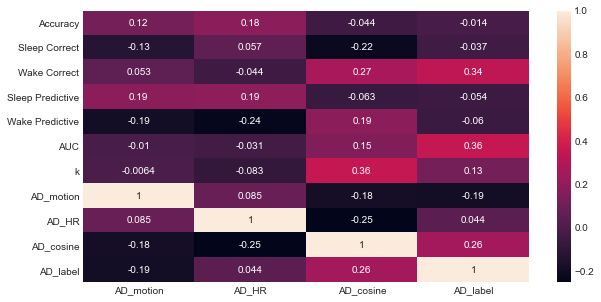



================ [Logistic Regression] ================
   Accuracy  Sleep Correct  Wake Correct  Sleep Predictive  Wake Predictive  \
0  0.929952       0.983471      0.549020          0.939474         0.823529   
1  0.757576       0.767981      0.612903          0.965015         0.159664   
2  0.862745       0.945508      0.452555          0.895397         0.626263   

        AUC         k  AD_motion      AD_HR   AD_cosine    AD_label  
0  0.896505  0.621524  39.264590  71.144092  165.861145   10.173056  
1  0.827408  0.164368  34.214831  19.181918  122.012325    0.820017  
2  0.905733  0.447616   8.241666  83.981984    5.018962  102.291392  


(1) Pearson Corr of [Accuracy] and [AD_motion] = -0.269760 | p-value: 0.142212
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.264648 | p-value: 0.150223
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.356324 | p-value: 0.049123

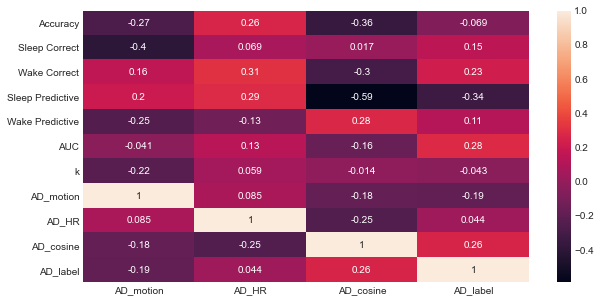



================ [Random Forest] ================
   Accuracy  Sleep Correct  Wake Correct  Sleep Predictive  Wake Predictive  \
0  0.920290       0.944904      0.745098          0.963483         0.655172   
1  0.740260       0.726218      0.935484          0.993651         0.197279   
2  0.890931       0.938144      0.656934          0.931287         0.681818   

        AUC         k  AD_motion      AD_HR   AD_cosine    AD_label  
0  0.947766  0.651568  39.264590  71.144092  165.861145   10.173056  
1  0.922386  0.241815  34.214831  19.181918  122.012325    0.820017  
2  0.888442  0.603875   8.241666  83.981984    5.018962  102.291392  


(1) Pearson Corr of [Accuracy] and [AD_motion] = -0.380697 | p-value: 0.034616
    1: The correlation is statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.195642 | p-value: 0.291536
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.105727 | p-value: 0.571350
    0: Th

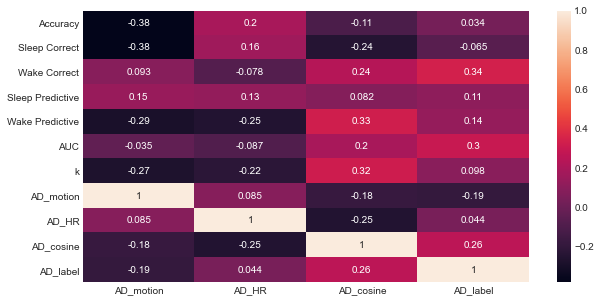



================ [k-Nearest Neighbors] ================
   Accuracy  Sleep Correct  Wake Correct  Sleep Predictive  Wake Predictive  \
0  0.876812       1.000000      0.000000          0.876812         0.000000   
1  0.919913       0.979118      0.096774          0.937778         0.250000   
2  0.835784       0.997054      0.036496          0.836836         0.714286   

        AUC         k  AD_motion      AD_HR   AD_cosine    AD_label  
0  0.936693  0.000000  39.264590  71.144092  165.861145   10.173056  
1  0.860714  0.106056  34.214831  19.181918  122.012325    0.820017  
2  0.878455  0.054003   8.241666  83.981984    5.018962  102.291392  


(1) Pearson Corr of [Accuracy] and [AD_motion] = 0.228128 | p-value: 0.217084
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.263675 | p-value: 0.151784
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.611842 | p-value: 0.000255


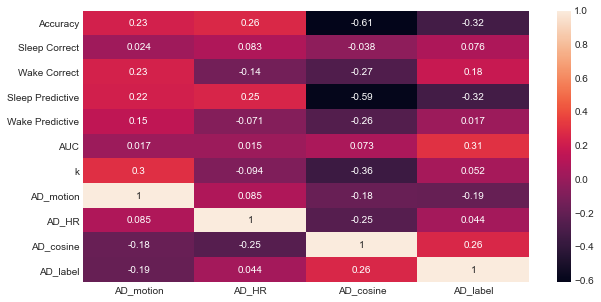

<Figure size 720x360 with 0 Axes>

In [ ]:
#RESULTS: Pearson R for Sleep-Wake

# Sleep-Wake:
model_correlation_analysis(models=models, classes='SW', border_index=7)


#### Pearson Correlation [3-Class]



================ [Neural Net] ================
   Accuracy  Wake Correct  NREM Correct  REM Correct         k  AD_motion  \
0  0.818841      0.549020      0.475859     0.480435  0.371890  39.264590   
1  0.067100      0.000000      0.000000     0.000000  0.000000  34.214831   
2  0.718137      0.249841      0.734701     0.732701  0.533986   8.241666   

       AD_HR   AD_cosine    AD_label  
0  71.144092  165.861145  122.346398  
1  19.181918  122.012325   98.221407  
2  83.981984    5.018962  310.047028  


(1) Pearson Corr of [Accuracy] and [AD_motion] = -0.080031 | p-value: 0.668674
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.194145 | p-value: 0.295316
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.332597 | p-value: 0.067525
    0: The correlation is NOT statistically significant
(4) Pearson Corr of [Accuracy] and [AD_label] = 0.401639 | p-value: 0.025118
    1: 

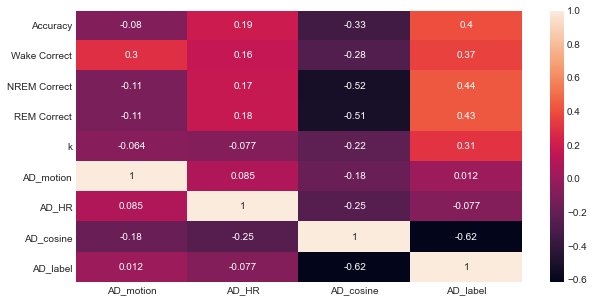



================ [Logistic Regression] ================
   Accuracy  Wake Correct  NREM Correct  REM Correct         k  AD_motion  \
0  0.811594      0.363791      0.658882     0.665217  0.357066  39.264590   
1  0.067100      0.000000      0.000000     0.000000  0.000000  34.214831   
2  0.661765      0.275220      0.663379     0.661698  0.450669   8.241666   

       AD_HR   AD_cosine    AD_label  
0  71.144092  165.861145  122.346398  
1  19.181918  122.012325   98.221407  
2  83.981984    5.018962  310.047028  


(1) Pearson Corr of [Accuracy] and [AD_motion] = -0.093136 | p-value: 0.618248
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.197676 | p-value: 0.286448
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.314793 | p-value: 0.084558
    0: The correlation is NOT statistically significant
(4) Pearson Corr of [Accuracy] and [AD_label] = 0.414740 | p-value: 0.02034

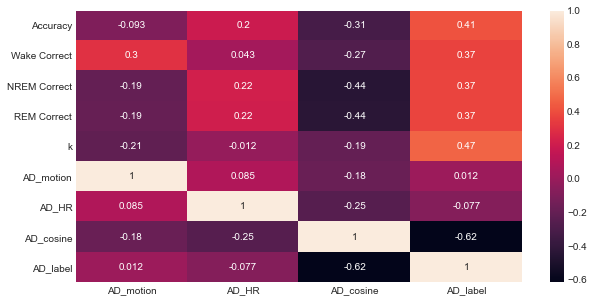



================ [Random Forest] ================
   Accuracy  Wake Correct  NREM Correct  REM Correct         k  AD_motion  \
0  0.719807      0.549020      0.442899     0.443478  0.218817  39.264590   
1  0.173160      0.000000      0.104408     0.000000  0.016923  34.214831   
2  0.687500      0.277874      0.693935     0.695646  0.474446   8.241666   

       AD_HR   AD_cosine    AD_label  
0  71.144092  165.861145  122.346398  
1  19.181918  122.012325   98.221407  
2  83.981984    5.018962  310.047028  


(1) Pearson Corr of [Accuracy] and [AD_motion] = -0.116073 | p-value: 0.534062
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.194827 | p-value: 0.293590
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.289987 | p-value: 0.113548
    0: The correlation is NOT statistically significant
(4) Pearson Corr of [Accuracy] and [AD_label] = 0.388706 | p-value: 0.030689
    

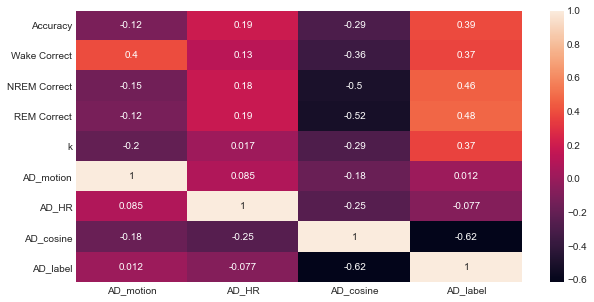



================ [k-Nearest Neighbors] ================
   Accuracy  Wake Correct  NREM Correct  REM Correct         k  AD_motion  \
0  0.816425      0.549020      0.436798     0.443478  0.366896  39.264590   
1  0.077922      0.000000      0.004640     0.000000  0.001573  34.214831   
2  0.693627      0.262199      0.700459     0.701210  0.506332   8.241666   

       AD_HR   AD_cosine    AD_label  
0  71.144092  165.861145  122.346398  
1  19.181918  122.012325   98.221407  
2  83.981984    5.018962  310.047028  


(1) Pearson Corr of [Accuracy] and [AD_motion] = -0.047902 | p-value: 0.798034
    0: The correlation is NOT statistically significant
(2) Pearson Corr of [Accuracy] and [AD_HR] = 0.219738 | p-value: 0.234929
    0: The correlation is NOT statistically significant
(3) Pearson Corr of [Accuracy] and [AD_cosine] = -0.330620 | p-value: 0.069272
    0: The correlation is NOT statistically significant
(4) Pearson Corr of [Accuracy] and [AD_label] = 0.380696 | p-value: 0.03461

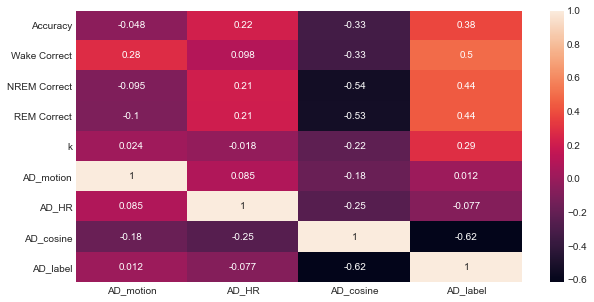

<Figure size 720x360 with 0 Axes>

In [ ]:
#RESULTS: Pearson for 3-Class (Wake-REM-NREM)

# Three-Class:
model_correlation_analysis(models=models, classes='TC', border_index=5)
